In [1]:
!nvidia-smi

Tue Jul 14 06:25:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch 
import torchvision
import numpy as np 
import random
import os
import glob
import copy
from tqdm import tqdm as tqdm
from torchsummary import summary

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# train class samples 
print('Normal Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/NORMAL | wc -l
print('Pneumonia Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/PNEUMONIA | wc -l

Normal Samples in Training Data
1342
Pneumonia Samples in Training Data
3876


In [5]:
# Validation samples
print('Normal Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/NORMAL | wc -l
print('Pneumonia Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/PNEUMONIA | wc -l

Normal Samples in Validation Data
9
Pneumonia Samples in Validation Data
9


In [6]:
# Testing samples
print('Normal Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/NORMAL | wc -l
print('Pneumonia Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/PNEUMONIA | wc -l

Normal Samples in Testing Data
235
Pneumonia Samples in Testing Data
391


In [7]:
# Copying to Non DP data(train, val and test) to local to process/run faster during training & inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/train ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/val ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/test ./

In [8]:
!ls -lrt

total 20
drwxr-xr-x 1 root root 4096 Jul 10 16:29 sample_data
drwx------ 4 root root 4096 Jul 14 06:26 drive
drwx------ 4 root root 4096 Jul 14 06:36 train
drwx------ 4 root root 4096 Jul 14 07:00 val
drwx------ 4 root root 4096 Jul 14 07:01 test


In [9]:
!ls -l ./train/NORMAL | wc -l

!ls -l ./train/PNEUMONIA | wc -l

1342
3876


In [10]:
!ls -l ./val/NORMAL | wc -l

!ls -l ./val/PNEUMONIA | wc -l

9
9


In [11]:
!ls -l ./test/NORMAL | wc -l

!ls -l ./test/PNEUMONIA | wc -l

235
391


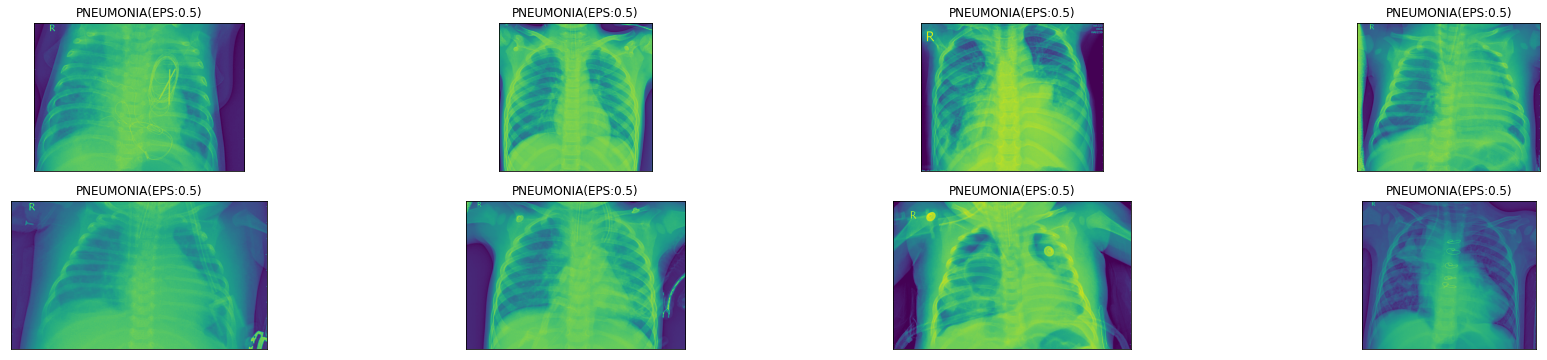

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 PNEUMONIA images(train) for Epsilon :0.5
train_imgs = os.listdir(base_dir+"/PNEUMONIA")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/PNEUMONIA/" + img)
    plt.imshow(im)
    ax.set_title('PNEUMONIA(EPS:0.5)')

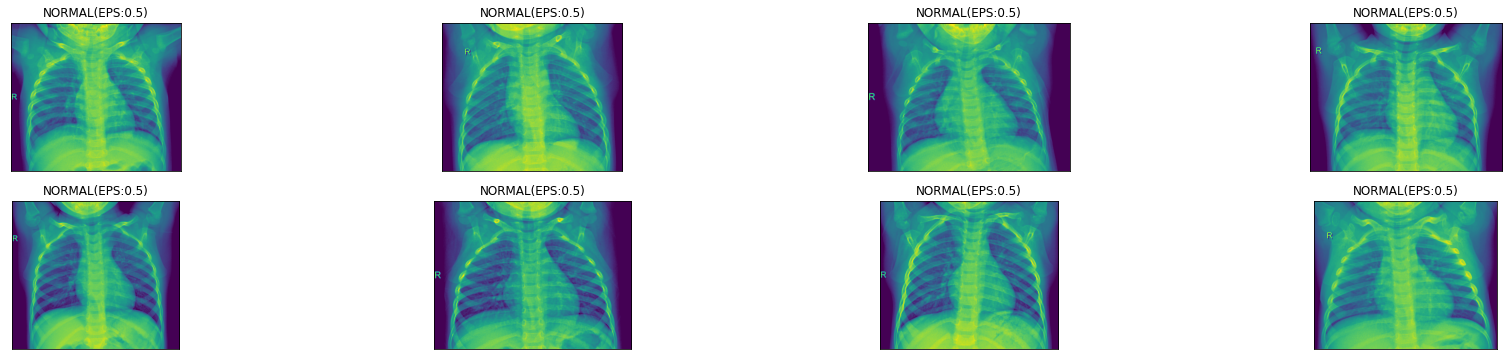

In [13]:
fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 NORMAL images(train) for Epsilon :0.5
train_imgs = os.listdir(base_dir+"/NORMAL")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/NORMAL/" + img)
    plt.imshow(im)
    ax.set_title('NORMAL(EPS:0.5)')

In [14]:
class ChestXRay(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target
       

In [15]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ChestXRay('./train/', transform=train_transforms)
val_dataset = ChestXRay('./val/', transform=train_transforms)
test_dataset = ChestXRay('./test/', transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [19]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 32
    S = 1
    z = 9.7 #DP-SGD with sampling rate = 2.45% and noise_multiplier = 9.7 iterated over 2039 steps satisfies differential privacy with eps = 0.5 and delta = 0.0001.
            #The optimal RDP order is 38.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [20]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [21]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [22]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0
train batch [0/41]: loss 0.5737420320510864

1it [00:12, 12.40s/it]

train batch [1/41]: loss 0.49247169494628906

2it [00:24, 12.37s/it]

train batch [2/41]: loss 0.5463559627532959

3it [00:37, 12.46s/it]

train batch [3/41]: loss 0.5576351284980774

4it [00:50, 12.66s/it]

train batch [4/41]: loss 0.5056967735290527

5it [01:03, 12.74s/it]

train batch [5/41]: loss 0.4874545931816101

6it [01:16, 12.82s/it]

train batch [6/41]: loss 0.5309461355209351

7it [01:29, 13.02s/it]

train batch [7/41]: loss 0.46200019121170044

8it [01:43, 13.20s/it]

train batch [8/41]: loss 0.5033877491950989

9it [01:57, 13.48s/it]

train batch [9/41]: loss 0.4910155236721039

10it [02:11, 13.65s/it]

train batch [10/41]: loss 0.4665900766849518

11it [02:25, 13.65s/it]

train batch [11/41]: loss 0.45294123888015747

12it [02:38, 13.61s/it]

train batch [12/41]: loss 0.5252952575683594

13it [02:52, 13.61s/it]

train batch [13/41]: loss 0.4885445833206177

14it [03:06, 13.63s/it]

train batch [14/41]: loss 0.4906151294708252

15it [03:19, 13.69s/it]

train batch [15/41]: loss 0.5403227806091309

16it [03:33, 13.73s/it]

train batch [16/41]: loss 0.4598834812641144

17it [03:47, 13.71s/it]

train batch [17/41]: loss 0.5759754180908203

18it [04:01, 13.76s/it]

train batch [18/41]: loss 0.5046634078025818

19it [04:14, 13.71s/it]

train batch [19/41]: loss 0.4932618737220764

20it [04:28, 13.76s/it]

train batch [20/41]: loss 0.47840553522109985

21it [04:42, 13.75s/it]

train batch [21/41]: loss 0.4703420400619507

22it [04:56, 13.70s/it]

train batch [22/41]: loss 0.4998125433921814

23it [05:09, 13.69s/it]

train batch [23/41]: loss 0.502569317817688

24it [05:23, 13.72s/it]

train batch [24/41]: loss 0.5069877505302429

25it [05:37, 13.78s/it]

train batch [25/41]: loss 0.5550696849822998

26it [05:51, 13.79s/it]

train batch [26/41]: loss 0.4572345018386841

27it [06:04, 13.75s/it]

train batch [27/41]: loss 0.5628698468208313

28it [06:18, 13.77s/it]

train batch [28/41]: loss 0.4773012101650238

29it [06:32, 13.70s/it]

train batch [29/41]: loss 0.49737492203712463

30it [06:46, 13.71s/it]

train batch [30/41]: loss 0.4822002649307251

31it [06:59, 13.71s/it]

train batch [31/41]: loss 0.49828460812568665

32it [07:13, 13.73s/it]

train batch [32/41]: loss 0.5551725625991821

33it [07:27, 13.77s/it]

train batch [33/41]: loss 0.5250390768051147

34it [07:41, 13.76s/it]

train batch [34/41]: loss 0.5346663594245911

35it [07:54, 13.77s/it]

train batch [35/41]: loss 0.483440637588501

36it [08:08, 13.70s/it]

train batch [36/41]: loss 0.5219549536705017

37it [08:22, 13.79s/it]

train batch [37/41]: loss 0.4904061555862427

38it [08:36, 13.77s/it]

train batch [38/41]: loss 0.5115506649017334

39it [08:50, 13.79s/it]

train batch [39/41]: loss 0.5406166315078735

40it [09:03, 13.78s/it]

train batch [40/41]: loss 0.6058260798454285

41it [09:14, 13.52s/it]

val batch [1/4]: loss 1.3918426036834717

test batch [4/5]: loss 0.22419242560863495

0it [00:00, ?it/s]


Train loss: 0.5099005909954629, Train accuracy: 0.751725435256958
Val loss: 0.8823491707444191, Val accuracy: 0.5
Test loss: 0.7149944633245469, Test accuracy: 0.625

=============== Epoch: 1
train batch [0/41]: loss 0.5524328947067261

1it [00:13, 13.73s/it]

train batch [1/41]: loss 0.44794201850891113

2it [00:27, 13.75s/it]

train batch [2/41]: loss 0.5264756083488464

3it [00:41, 13.87s/it]

train batch [3/41]: loss 0.5576540231704712

4it [00:55, 13.88s/it]

train batch [4/41]: loss 0.5731077790260315

5it [01:09, 13.86s/it]

train batch [5/41]: loss 0.5471494197845459

6it [01:23, 13.82s/it]

train batch [6/41]: loss 0.6316410303115845

7it [01:36, 13.83s/it]

train batch [7/41]: loss 0.45797622203826904

8it [01:50, 13.80s/it]

train batch [8/41]: loss 0.5183399319648743

9it [02:04, 13.81s/it]

train batch [9/41]: loss 0.5550001859664917

10it [02:18, 13.80s/it]

train batch [10/41]: loss 0.43340685963630676

11it [02:31, 13.71s/it]

train batch [11/41]: loss 0.5308746099472046

12it [02:45, 13.71s/it]

train batch [12/41]: loss 0.48364630341529846

13it [02:59, 13.67s/it]

train batch [13/41]: loss 0.6279300451278687

14it [03:13, 13.74s/it]

train batch [14/41]: loss 0.6306290030479431

15it [03:27, 13.86s/it]

train batch [15/41]: loss 0.5699270963668823

16it [03:40, 13.86s/it]

train batch [16/41]: loss 0.5812104344367981

17it [03:54, 13.90s/it]

train batch [17/41]: loss 0.5342401266098022

18it [04:08, 13.83s/it]

train batch [18/41]: loss 0.4841277599334717

19it [04:22, 13.77s/it]

train batch [19/41]: loss 0.5339174270629883

20it [04:35, 13.73s/it]

train batch [20/41]: loss 0.540174126625061

21it [04:49, 13.68s/it]

train batch [21/41]: loss 0.5483284592628479

22it [05:03, 13.64s/it]

train batch [22/41]: loss 0.5298346877098083

23it [05:16, 13.59s/it]

train batch [23/41]: loss 0.5036267042160034

24it [05:30, 13.60s/it]

train batch [24/41]: loss 0.5571531057357788

25it [05:43, 13.61s/it]

train batch [25/41]: loss 0.5793306827545166

26it [05:57, 13.68s/it]

train batch [26/41]: loss 0.5435934066772461

27it [06:11, 13.68s/it]

train batch [27/41]: loss 0.4898892939090729

28it [06:24, 13.65s/it]

train batch [28/41]: loss 0.5890625715255737

29it [06:38, 13.72s/it]

train batch [29/41]: loss 0.5319358110427856

30it [06:52, 13.71s/it]

train batch [30/41]: loss 0.5120760202407837

31it [07:06, 13.74s/it]

train batch [31/41]: loss 0.5404723882675171

32it [07:19, 13.73s/it]

train batch [32/41]: loss 0.548976719379425

33it [07:33, 13.70s/it]

train batch [33/41]: loss 0.6156686544418335

34it [07:47, 13.73s/it]

train batch [34/41]: loss 0.5169466137886047

35it [08:01, 13.75s/it]

train batch [35/41]: loss 0.5856122970581055

36it [08:15, 13.85s/it]

train batch [36/41]: loss 0.5613323450088501

37it [08:28, 13.79s/it]

train batch [37/41]: loss 0.46348583698272705

38it [08:42, 13.75s/it]

train batch [38/41]: loss 0.5615572333335876

39it [08:56, 13.80s/it]

train batch [39/41]: loss 0.47608470916748047

40it [09:10, 13.72s/it]

train batch [40/41]: loss 0.5949177742004395

41it [09:20, 13.67s/it]

val batch [1/4]: loss 1.2091593742370605

test batch [4/5]: loss 0.3661195635795593

0it [00:00, ?it/s]


Train loss: 0.5406753151881986, Train accuracy: 0.7427147030830383
Val loss: 0.7508404850959778, Val accuracy: 0.5
Test loss: 0.6290858149528503, Test accuracy: 0.6330128312110901

=============== Epoch: 2
train batch [0/41]: loss 0.507696270942688

1it [00:13, 13.83s/it]

train batch [1/41]: loss 0.4947296977043152

2it [00:27, 13.88s/it]

train batch [2/41]: loss 0.5613055229187012

3it [00:41, 13.91s/it]

train batch [3/41]: loss 0.5736565589904785

4it [00:55, 13.86s/it]

train batch [4/41]: loss 0.6029700040817261

5it [01:09, 13.81s/it]

train batch [5/41]: loss 0.6260057687759399

6it [01:22, 13.75s/it]

train batch [6/41]: loss 0.5546044111251831

7it [01:36, 13.82s/it]

train batch [7/41]: loss 0.6406369805335999

8it [01:50, 13.89s/it]

train batch [8/41]: loss 0.5556752681732178

9it [02:04, 13.87s/it]

train batch [9/41]: loss 0.5400980710983276

10it [02:18, 13.85s/it]

train batch [10/41]: loss 0.5056373476982117

11it [02:32, 13.82s/it]

train batch [11/41]: loss 0.5676538348197937

12it [02:45, 13.79s/it]

train batch [12/41]: loss 0.5608364343643188

13it [02:59, 13.78s/it]

train batch [13/41]: loss 0.5596083402633667

14it [03:13, 13.82s/it]

train batch [14/41]: loss 0.5716831684112549

15it [03:27, 13.81s/it]

train batch [15/41]: loss 0.49982941150665283

16it [03:41, 13.86s/it]

train batch [16/41]: loss 0.6002537608146667

17it [03:55, 13.85s/it]

train batch [17/41]: loss 0.5049499273300171

18it [04:09, 13.87s/it]

train batch [18/41]: loss 0.49287235736846924

19it [04:22, 13.82s/it]

train batch [19/41]: loss 0.5625581741333008

20it [04:36, 13.82s/it]

train batch [20/41]: loss 0.520550549030304

21it [04:50, 13.78s/it]

train batch [21/41]: loss 0.5399795770645142

22it [05:04, 13.77s/it]

train batch [22/41]: loss 0.54266357421875

23it [05:17, 13.80s/it]

train batch [23/41]: loss 0.615364670753479

24it [05:31, 13.79s/it]

train batch [24/41]: loss 0.48076754808425903

25it [05:45, 13.72s/it]

train batch [25/41]: loss 0.4486362636089325

26it [05:58, 13.70s/it]

train batch [26/41]: loss 0.6901623010635376

27it [06:12, 13.74s/it]

train batch [27/41]: loss 0.5320768356323242

28it [06:26, 13.74s/it]

train batch [28/41]: loss 0.6067744493484497

29it [06:40, 13.77s/it]

train batch [29/41]: loss 0.57130366563797

30it [06:54, 13.73s/it]

train batch [30/41]: loss 0.567050039768219

31it [07:07, 13.72s/it]

train batch [31/41]: loss 0.6073886156082153

32it [07:21, 13.74s/it]

train batch [32/41]: loss 0.6321971416473389

33it [07:35, 13.77s/it]

train batch [33/41]: loss 0.5917313098907471

34it [07:49, 13.79s/it]

train batch [34/41]: loss 0.5201778411865234

35it [08:02, 13.74s/it]

train batch [35/41]: loss 0.5000324249267578

36it [08:16, 13.71s/it]

train batch [36/41]: loss 0.5164721012115479

37it [08:30, 13.68s/it]

train batch [37/41]: loss 0.5052862167358398

38it [08:43, 13.67s/it]

train batch [38/41]: loss 0.5258663892745972

39it [08:57, 13.69s/it]

train batch [39/41]: loss 0.49754106998443604

40it [09:11, 13.66s/it]

train batch [40/41]: loss 0.544901967048645

41it [09:21, 13.69s/it]

val batch [1/4]: loss 1.8379416465759277

test batch [4/5]: loss 0.18277408182621002

0it [00:00, ?it/s]


Train loss: 0.5521996515553173, Train accuracy: 0.7427147030830383
Val loss: 1.002246204763651, Val accuracy: 0.5
Test loss: 0.7945154398679733, Test accuracy: 0.625

=============== Epoch: 3
train batch [0/41]: loss 0.504886269569397

1it [00:13, 13.55s/it]

train batch [1/41]: loss 0.5996136665344238

2it [00:27, 13.75s/it]

train batch [2/41]: loss 0.5040378570556641

3it [00:41, 13.83s/it]

train batch [3/41]: loss 0.667540967464447

4it [00:55, 13.86s/it]

train batch [4/41]: loss 0.592408299446106

5it [01:09, 13.80s/it]

train batch [5/41]: loss 0.5910848379135132

6it [01:23, 13.77s/it]

train batch [6/41]: loss 0.5100976824760437

7it [01:36, 13.72s/it]

train batch [7/41]: loss 0.6459665298461914

8it [01:50, 13.80s/it]

train batch [8/41]: loss 0.5133412480354309

9it [02:04, 13.75s/it]

train batch [9/41]: loss 0.5201085805892944

10it [02:17, 13.68s/it]

train batch [10/41]: loss 0.6204029321670532

11it [02:31, 13.75s/it]

train batch [11/41]: loss 0.5446513295173645

12it [02:45, 13.74s/it]

train batch [12/41]: loss 0.5768781900405884

13it [02:59, 13.76s/it]

train batch [13/41]: loss 0.5210198163986206

14it [03:12, 13.75s/it]

train batch [14/41]: loss 0.47276467084884644

15it [03:26, 13.72s/it]

train batch [15/41]: loss 0.5708576440811157

16it [03:40, 13.76s/it]

train batch [16/41]: loss 0.5350478887557983

17it [03:54, 13.73s/it]

train batch [17/41]: loss 0.5315635800361633

18it [04:07, 13.71s/it]

train batch [18/41]: loss 0.5717575550079346

19it [04:21, 13.75s/it]

train batch [19/41]: loss 0.5356825590133667

20it [04:35, 13.73s/it]

train batch [20/41]: loss 0.5206835865974426

21it [04:48, 13.70s/it]

train batch [21/41]: loss 0.5815446376800537

22it [05:02, 13.74s/it]

train batch [22/41]: loss 0.5638035535812378

23it [05:16, 13.74s/it]

train batch [23/41]: loss 0.5769466161727905

24it [05:30, 13.79s/it]

train batch [24/41]: loss 0.5657894611358643

25it [05:44, 13.78s/it]

train batch [25/41]: loss 0.5671219825744629

26it [05:58, 13.82s/it]

train batch [26/41]: loss 0.5312365293502808

27it [06:11, 13.76s/it]

train batch [27/41]: loss 0.5598002672195435

28it [06:25, 13.73s/it]

train batch [28/41]: loss 0.6621346473693848

29it [06:39, 13.75s/it]

train batch [29/41]: loss 0.6232918500900269

30it [06:53, 13.83s/it]

train batch [30/41]: loss 0.6386218070983887

31it [07:07, 13.88s/it]

train batch [31/41]: loss 0.5395621061325073

32it [07:20, 13.83s/it]

train batch [32/41]: loss 0.574000895023346

33it [07:34, 13.79s/it]

train batch [33/41]: loss 0.6179200410842896

34it [07:48, 13.83s/it]

train batch [34/41]: loss 0.5553064942359924

35it [08:02, 13.83s/it]

train batch [35/41]: loss 0.5262884497642517

36it [08:15, 13.76s/it]

train batch [36/41]: loss 0.5409821271896362

37it [08:29, 13.73s/it]

train batch [37/41]: loss 0.5622327327728271

38it [08:43, 13.67s/it]

train batch [38/41]: loss 0.5890714526176453

39it [08:56, 13.72s/it]

train batch [39/41]: loss 0.5902454257011414

40it [09:10, 13.75s/it]

train batch [40/41]: loss 0.6301693916320801

41it [09:21, 13.69s/it]

val batch [1/4]: loss 0.7782748937606812

test batch [4/5]: loss 0.5402966737747192

0it [00:00, ?it/s]


Train loss: 0.566986982415362, Train accuracy: 0.7434815764427185
Val loss: 0.7406240701675415, Val accuracy: 0.5
Test loss: 0.6693123936653137, Test accuracy: 0.5993589758872986

=============== Epoch: 4
train batch [0/41]: loss 0.5691343545913696

1it [00:13, 13.63s/it]

train batch [1/41]: loss 0.5632407069206238

2it [00:27, 13.81s/it]

train batch [2/41]: loss 0.5933096408843994

3it [00:41, 13.87s/it]

train batch [3/41]: loss 0.5222146511077881

4it [00:55, 13.81s/it]

train batch [4/41]: loss 0.5530471205711365

5it [01:09, 13.77s/it]

train batch [5/41]: loss 0.539607048034668

6it [01:22, 13.70s/it]

train batch [6/41]: loss 0.5235840678215027

7it [01:36, 13.72s/it]

train batch [7/41]: loss 0.4634588360786438

8it [01:50, 13.78s/it]

train batch [8/41]: loss 0.4983338713645935

9it [02:04, 13.77s/it]

train batch [9/41]: loss 0.6098869442939758

10it [02:18, 13.81s/it]

train batch [10/41]: loss 0.5205084085464478

11it [02:31, 13.78s/it]

train batch [11/41]: loss 0.5644581317901611

12it [02:45, 13.77s/it]

train batch [12/41]: loss 0.5920268893241882

13it [02:59, 13.78s/it]

train batch [13/41]: loss 0.5561847686767578

14it [03:13, 13.76s/it]

train batch [14/41]: loss 0.5305211544036865

15it [03:26, 13.77s/it]

train batch [15/41]: loss 0.5636270046234131

16it [03:40, 13.76s/it]

train batch [16/41]: loss 0.5820178985595703

17it [03:54, 13.75s/it]

train batch [17/41]: loss 0.6119088530540466

18it [04:08, 13.75s/it]

train batch [18/41]: loss 0.4483087658882141

19it [04:21, 13.69s/it]

train batch [19/41]: loss 0.5298318862915039

20it [04:35, 13.66s/it]

train batch [20/41]: loss 0.5868781805038452

21it [04:48, 13.68s/it]

train batch [21/41]: loss 0.47937121987342834

22it [05:02, 13.65s/it]

train batch [22/41]: loss 0.6578171253204346

23it [05:16, 13.70s/it]

train batch [23/41]: loss 0.6041486263275146

24it [05:29, 13.64s/it]

train batch [24/41]: loss 0.7607468366622925

25it [05:43, 13.70s/it]

train batch [25/41]: loss 0.7655062079429626

26it [05:57, 13.78s/it]

train batch [26/41]: loss 0.4610491394996643

27it [06:11, 13.72s/it]

train batch [27/41]: loss 0.7236897945404053

28it [06:25, 13.75s/it]

train batch [28/41]: loss 0.751454770565033

29it [06:38, 13.78s/it]

train batch [29/41]: loss 0.6759931445121765

30it [06:52, 13.82s/it]

train batch [30/41]: loss 0.789055347442627

31it [07:06, 13.87s/it]

train batch [31/41]: loss 0.7944381833076477

32it [07:20, 13.88s/it]

train batch [32/41]: loss 0.5981185436248779

33it [07:34, 13.86s/it]

train batch [33/41]: loss 0.5891871452331543

34it [07:48, 13.83s/it]

train batch [34/41]: loss 0.5758501291275024

35it [08:02, 13.80s/it]

train batch [35/41]: loss 0.7721337080001831

36it [08:15, 13.83s/it]

train batch [36/41]: loss 0.6582476496696472

37it [08:29, 13.80s/it]

train batch [37/41]: loss 0.64604252576828

38it [08:43, 13.85s/it]

train batch [38/41]: loss 0.6291884183883667

39it [08:57, 13.84s/it]

train batch [39/41]: loss 0.7195650935173035

40it [09:11, 13.90s/it]

train batch [40/41]: loss 0.79240882396698

41it [09:22, 13.71s/it]

val batch [0/4]: loss 1.8727736473083496

test batch [4/5]: loss 0.14593061804771423

0it [00:00, ?it/s]


Train loss: 0.6089293120837793, Train accuracy: 0.7436733245849609
Val loss: 1.003578059375286, Val accuracy: 0.5
Test loss: 0.8258754074573517, Test accuracy: 0.625

=============== Epoch: 5
train batch [0/41]: loss 0.6207516193389893

1it [00:13, 13.94s/it]

train batch [1/41]: loss 0.5657814741134644

2it [00:28, 14.02s/it]

train batch [2/41]: loss 0.6739324927330017

3it [00:42, 14.08s/it]

train batch [3/41]: loss 0.6222832202911377

4it [00:56, 13.98s/it]

train batch [4/41]: loss 0.6554571390151978

5it [01:09, 13.84s/it]

train batch [5/41]: loss 0.6706172227859497

6it [01:23, 13.78s/it]

train batch [6/41]: loss 0.38988208770751953

7it [01:36, 13.68s/it]

train batch [7/41]: loss 0.5914841890335083

8it [01:50, 13.76s/it]

train batch [8/41]: loss 0.6758489608764648

9it [02:04, 13.84s/it]

train batch [9/41]: loss 0.6762006282806396

10it [02:18, 13.84s/it]

train batch [10/41]: loss 0.7727696895599365

11it [02:32, 13.81s/it]

train batch [11/41]: loss 0.5115286111831665

12it [02:45, 13.74s/it]

train batch [12/41]: loss 0.6596741080284119

13it [02:59, 13.70s/it]

train batch [13/41]: loss 0.696759819984436

14it [03:13, 13.77s/it]

train batch [14/41]: loss 0.713930070400238

15it [03:27, 13.78s/it]

train batch [15/41]: loss 0.7704818248748779

16it [03:41, 13.80s/it]

train batch [16/41]: loss 0.8705461025238037

17it [03:55, 13.86s/it]

train batch [17/41]: loss 0.633473813533783

18it [04:08, 13.81s/it]

train batch [18/41]: loss 0.7288166284561157

19it [04:22, 13.86s/it]

train batch [19/41]: loss 0.49942636489868164

20it [04:36, 13.76s/it]

train batch [20/41]: loss 0.6453876495361328

21it [04:50, 13.78s/it]

train batch [21/41]: loss 0.6497333645820618

22it [05:03, 13.78s/it]

train batch [22/41]: loss 0.603844940662384

23it [05:17, 13.74s/it]

train batch [23/41]: loss 0.6105234622955322

24it [05:31, 13.74s/it]

train batch [24/41]: loss 0.649111270904541

25it [05:44, 13.72s/it]

train batch [25/41]: loss 0.8443984985351562

26it [05:58, 13.79s/it]

train batch [26/41]: loss 0.5895588397979736

27it [06:12, 13.79s/it]

train batch [27/41]: loss 0.6236792206764221

28it [06:26, 13.78s/it]

train batch [28/41]: loss 0.7624648809432983

29it [06:40, 13.81s/it]

train batch [29/41]: loss 0.61350017786026

30it [06:53, 13.78s/it]

train batch [30/41]: loss 0.7321101427078247

31it [07:07, 13.80s/it]

train batch [31/41]: loss 0.7180896997451782

32it [07:21, 13.80s/it]

train batch [32/41]: loss 0.8214184045791626

33it [07:35, 13.85s/it]

train batch [33/41]: loss 0.681452214717865

34it [07:49, 13.87s/it]

train batch [34/41]: loss 0.5898526906967163

35it [08:03, 13.80s/it]

train batch [35/41]: loss 0.5308482646942139

36it [08:16, 13.75s/it]

train batch [36/41]: loss 0.6025136709213257

37it [08:30, 13.74s/it]

train batch [37/41]: loss 0.6043721437454224

38it [08:44, 13.75s/it]

train batch [38/41]: loss 0.7670334577560425

39it [08:58, 13.77s/it]

train batch [39/41]: loss 0.5291389226913452

40it [09:11, 13.70s/it]

train batch [40/41]: loss 0.5928493142127991

41it [09:22, 13.71s/it]

val batch [1/4]: loss 2.228271484375

test batch [4/5]: loss 0.06953638792037964

0it [00:00, ?it/s]


Train loss: 0.6527201707770185, Train accuracy: 0.7429064512252808
Val loss: 1.1747116446495056, Val accuracy: 0.5
Test loss: 0.9523171231150627, Test accuracy: 0.625

=============== Epoch: 6
train batch [0/41]: loss 0.7387140989303589

1it [00:13, 13.70s/it]

train batch [1/41]: loss 0.7136541604995728

2it [00:27, 13.84s/it]

train batch [2/41]: loss 0.7095115184783936

3it [00:42, 13.98s/it]

train batch [3/41]: loss 0.5882899761199951

4it [00:56, 13.96s/it]

train batch [4/41]: loss 0.6688429117202759

5it [01:09, 13.85s/it]

train batch [5/41]: loss 0.7235324382781982

6it [01:23, 13.78s/it]

train batch [6/41]: loss 0.47473037242889404

7it [01:36, 13.67s/it]

train batch [7/41]: loss 0.5005335211753845

8it [01:50, 13.66s/it]

train batch [8/41]: loss 0.7205665111541748

9it [02:04, 13.76s/it]

train batch [9/41]: loss 0.534794270992279

10it [02:18, 13.74s/it]

train batch [10/41]: loss 0.6534290313720703

11it [02:31, 13.79s/it]

train batch [11/41]: loss 0.5143564939498901

12it [02:45, 13.75s/it]

train batch [12/41]: loss 0.5147377252578735

13it [02:59, 13.73s/it]

train batch [13/41]: loss 0.622755765914917

14it [03:13, 13.79s/it]

train batch [14/41]: loss 0.5487572550773621

15it [03:26, 13.74s/it]

train batch [15/41]: loss 0.5861978530883789

16it [03:40, 13.77s/it]

train batch [16/41]: loss 0.650884747505188

17it [03:54, 13.78s/it]

train batch [17/41]: loss 0.5600011944770813

18it [04:08, 13.73s/it]

train batch [18/41]: loss 0.5783436894416809

19it [04:21, 13.74s/it]

train batch [19/41]: loss 0.6771423816680908

20it [04:35, 13.80s/it]

train batch [20/41]: loss 0.7238650321960449

21it [04:49, 13.81s/it]

train batch [21/41]: loss 0.6431697607040405

22it [05:03, 13.85s/it]

train batch [22/41]: loss 0.558502197265625

23it [05:17, 13.84s/it]

train batch [23/41]: loss 0.5966095328330994

24it [05:31, 13.80s/it]

train batch [24/41]: loss 0.6476733684539795

25it [05:44, 13.74s/it]

train batch [25/41]: loss 0.6067427396774292

26it [05:58, 13.81s/it]

train batch [26/41]: loss 0.5869491100311279

27it [06:12, 13.83s/it]

train batch [27/41]: loss 0.49855995178222656

28it [06:26, 13.85s/it]

train batch [28/41]: loss 0.5038662552833557

29it [06:40, 13.87s/it]

train batch [29/41]: loss 0.6048499941825867

30it [06:54, 13.86s/it]

train batch [30/41]: loss 0.5924065113067627

31it [07:07, 13.84s/it]

train batch [31/41]: loss 0.5731582641601562

32it [07:21, 13.83s/it]

train batch [32/41]: loss 0.504311203956604

33it [07:35, 13.81s/it]

train batch [33/41]: loss 0.5411032438278198

34it [07:49, 13.79s/it]

train batch [34/41]: loss 0.6649152040481567

35it [08:03, 13.88s/it]

train batch [35/41]: loss 0.6092297434806824

36it [08:17, 13.90s/it]

train batch [36/41]: loss 0.6866509914398193

37it [08:31, 13.91s/it]

train batch [37/41]: loss 0.5143098831176758

38it [08:44, 13.84s/it]

train batch [38/41]: loss 0.4985957145690918

39it [08:58, 13.76s/it]

train batch [39/41]: loss 0.5085875988006592

40it [09:12, 13.77s/it]

train batch [40/41]: loss 0.7176184058189392

41it [09:22, 13.73s/it]

val batch [0/4]: loss 1.390347957611084

test batch [4/5]: loss 0.21260295808315277

0it [00:00, ?it/s]


Train loss: 0.6014987913573661, Train accuracy: 0.7429064512252808
Val loss: 0.7938751801848412, Val accuracy: 0.5
Test loss: 0.7168334573507309, Test accuracy: 0.625

=============== Epoch: 7
train batch [0/41]: loss 0.536652684211731

1it [00:13, 13.56s/it]

train batch [1/41]: loss 0.4979870319366455

2it [00:27, 13.68s/it]

train batch [2/41]: loss 0.6173962354660034

3it [00:41, 13.84s/it]

train batch [3/41]: loss 0.590091347694397

4it [00:55, 13.88s/it]

train batch [4/41]: loss 0.67573082447052

5it [01:09, 13.86s/it]

train batch [5/41]: loss 0.4918273091316223

6it [01:23, 13.87s/it]

train batch [6/41]: loss 0.4349444508552551

7it [01:37, 13.87s/it]

train batch [7/41]: loss 0.5344456434249878

8it [01:51, 13.88s/it]

train batch [8/41]: loss 0.562270998954773

9it [02:04, 13.82s/it]

train batch [9/41]: loss 0.6705018877983093

10it [02:18, 13.86s/it]

train batch [10/41]: loss 0.5108280181884766

11it [02:32, 13.81s/it]

train batch [11/41]: loss 0.6236869096755981

12it [02:46, 13.85s/it]

train batch [12/41]: loss 0.6774419546127319

13it [03:00, 13.97s/it]

train batch [13/41]: loss 0.5541704297065735

14it [03:14, 13.96s/it]

train batch [14/41]: loss 0.6712082624435425

15it [03:28, 14.00s/it]

train batch [15/41]: loss 0.6488773226737976

16it [03:42, 14.01s/it]

train batch [16/41]: loss 0.6777952909469604

17it [03:56, 14.02s/it]

train batch [17/41]: loss 0.6922229528427124

18it [04:11, 14.07s/it]

train batch [18/41]: loss 0.5773847103118896

19it [04:25, 14.09s/it]

train batch [19/41]: loss 0.5503475069999695

20it [04:39, 14.06s/it]

train batch [20/41]: loss 0.5368085503578186

21it [04:53, 14.03s/it]

train batch [21/41]: loss 0.6351357698440552

22it [05:07, 14.06s/it]

train batch [22/41]: loss 0.6318987607955933

23it [05:21, 14.10s/it]

train batch [23/41]: loss 0.5975217223167419

24it [05:35, 14.09s/it]

train batch [24/41]: loss 0.6162905693054199

25it [05:49, 14.12s/it]

train batch [25/41]: loss 0.5592575073242188

26it [06:03, 14.07s/it]

train batch [26/41]: loss 0.5713484287261963

27it [06:17, 14.02s/it]

train batch [27/41]: loss 0.4965043067932129

28it [06:31, 13.95s/it]

train batch [28/41]: loss 0.6135402917861938

29it [06:45, 13.93s/it]

train batch [29/41]: loss 0.7141726016998291

30it [06:59, 13.99s/it]

train batch [30/41]: loss 0.5155344009399414

31it [07:13, 13.96s/it]

train batch [31/41]: loss 0.5892593264579773

32it [07:27, 13.96s/it]

train batch [32/41]: loss 0.563430905342102

33it [07:41, 14.02s/it]

train batch [33/41]: loss 0.5775982141494751

34it [07:55, 14.05s/it]

train batch [34/41]: loss 0.45841407775878906

35it [08:09, 13.95s/it]

train batch [35/41]: loss 0.5360527038574219

36it [08:23, 13.94s/it]

train batch [36/41]: loss 0.5641026496887207

37it [08:37, 13.95s/it]

train batch [37/41]: loss 0.5694432258605957

38it [08:50, 13.91s/it]

train batch [38/41]: loss 0.5212246179580688

39it [09:04, 13.95s/it]

train batch [39/41]: loss 0.5052357316017151

40it [09:18, 13.91s/it]

train batch [40/41]: loss 0.5476652383804321

41it [09:29, 13.88s/it]

val batch [0/4]: loss 1.4485116004943848

test batch [4/5]: loss 0.2309020310640335

0it [00:00, ?it/s]


Train loss: 0.5784451590805519, Train accuracy: 0.7429064512252808
Val loss: 0.901194840669632, Val accuracy: 0.5
Test loss: 0.7212510406970978, Test accuracy: 0.625

=============== Epoch: 8
train batch [0/41]: loss 0.5888358354568481

1it [00:13, 13.90s/it]

train batch [1/41]: loss 0.5596107244491577

2it [00:28, 14.03s/it]

train batch [2/41]: loss 0.6008246541023254

3it [00:42, 14.15s/it]

train batch [3/41]: loss 0.4932210147380829

4it [00:56, 14.06s/it]

train batch [4/41]: loss 0.6303078532218933

5it [01:10, 14.01s/it]

train batch [5/41]: loss 0.5049159526824951

6it [01:24, 13.94s/it]

train batch [6/41]: loss 0.5530056357383728

7it [01:37, 13.88s/it]

train batch [7/41]: loss 0.5584705471992493

8it [01:51, 13.93s/it]

train batch [8/41]: loss 0.5060176253318787

9it [02:05, 13.92s/it]

train batch [9/41]: loss 0.4903910160064697

10it [02:19, 13.87s/it]

train batch [10/41]: loss 0.5352354049682617

11it [02:33, 13.89s/it]

train batch [11/41]: loss 0.614082932472229

12it [02:47, 13.90s/it]

train batch [12/41]: loss 0.49696916341781616

13it [03:01, 13.91s/it]

train batch [13/41]: loss 0.5715157985687256

14it [03:15, 13.98s/it]

train batch [14/41]: loss 0.5307052135467529

15it [03:29, 13.97s/it]

train batch [15/41]: loss 0.5679750442504883

16it [03:43, 13.93s/it]

train batch [16/41]: loss 0.5318961143493652

17it [03:57, 13.89s/it]

train batch [17/41]: loss 0.5938191413879395

18it [04:11, 13.89s/it]

train batch [18/41]: loss 0.4838806390762329

19it [04:24, 13.82s/it]

train batch [19/41]: loss 0.4231938123703003

20it [04:38, 13.78s/it]

train batch [20/41]: loss 0.4574342966079712

21it [04:52, 13.78s/it]

train batch [21/41]: loss 0.4630528390407562

22it [05:05, 13.75s/it]

train batch [22/41]: loss 0.5677237510681152

23it [05:19, 13.78s/it]

train batch [23/41]: loss 0.600492537021637

24it [05:33, 13.83s/it]

train batch [24/41]: loss 0.4929078221321106

25it [05:47, 13.82s/it]

train batch [25/41]: loss 0.4882797598838806

26it [06:01, 13.84s/it]

train batch [26/41]: loss 0.5968285799026489

27it [06:15, 13.86s/it]

train batch [27/41]: loss 0.4974744915962219

28it [06:28, 13.83s/it]

train batch [28/41]: loss 0.5147900581359863

29it [06:42, 13.85s/it]

train batch [29/41]: loss 0.5862300395965576

30it [06:56, 13.85s/it]

train batch [30/41]: loss 0.5247972011566162

31it [07:10, 13.88s/it]

train batch [31/41]: loss 0.5041446685791016

32it [07:24, 13.85s/it]

train batch [32/41]: loss 0.5107632875442505

33it [07:38, 13.87s/it]

train batch [33/41]: loss 0.5960143208503723

34it [07:52, 13.89s/it]

train batch [34/41]: loss 0.5444328784942627

35it [08:06, 13.90s/it]

train batch [35/41]: loss 0.6153298020362854

36it [08:20, 13.93s/it]

train batch [36/41]: loss 0.6151800155639648

37it [08:34, 13.98s/it]

train batch [37/41]: loss 0.5129193067550659

38it [08:48, 13.96s/it]

train batch [38/41]: loss 0.5627816915512085

39it [09:02, 13.98s/it]

train batch [39/41]: loss 0.5347225069999695

40it [09:16, 13.98s/it]

train batch [40/41]: loss 0.47133272886276245

41it [09:26, 13.82s/it]

val batch [0/4]: loss 1.4982807636260986

test batch [4/5]: loss 0.2677097022533417

0it [00:00, ?it/s]


Train loss: 0.5388416182704088, Train accuracy: 0.7434815764427185
Val loss: 0.8451741561293602, Val accuracy: 0.5
Test loss: 0.6355496942996979, Test accuracy: 0.629807710647583

=============== Epoch: 9
train batch [0/41]: loss 0.40540146827697754

1it [00:13, 13.67s/it]

train batch [1/41]: loss 0.5662375688552856

2it [00:27, 13.86s/it]

train batch [2/41]: loss 0.5674560070037842

3it [00:42, 14.02s/it]

train batch [3/41]: loss 0.5243234634399414

4it [00:56, 14.02s/it]

train batch [4/41]: loss 0.4981832206249237

5it [01:10, 13.95s/it]

train batch [5/41]: loss 0.4421923756599426

6it [01:23, 13.90s/it]

train batch [6/41]: loss 0.5111314058303833

7it [01:37, 13.91s/it]

train batch [7/41]: loss 0.44158869981765747

8it [01:51, 13.97s/it]

train batch [8/41]: loss 0.584320604801178

9it [02:06, 14.03s/it]

train batch [9/41]: loss 0.5063744783401489

10it [02:20, 13.99s/it]

train batch [10/41]: loss 0.4645681083202362

11it [02:33, 13.90s/it]

train batch [11/41]: loss 0.5919595956802368

12it [02:47, 13.89s/it]

train batch [12/41]: loss 0.5599495768547058

13it [03:01, 13.93s/it]

train batch [13/41]: loss 0.443606436252594

14it [03:15, 13.90s/it]

train batch [14/41]: loss 0.5425190925598145

15it [03:29, 13.95s/it]

train batch [15/41]: loss 0.5732787251472473

16it [03:43, 13.94s/it]

train batch [16/41]: loss 0.5291219353675842

17it [03:57, 13.94s/it]

train batch [17/41]: loss 0.46155625581741333

18it [04:11, 13.91s/it]

train batch [18/41]: loss 0.552081823348999

19it [04:25, 13.91s/it]

train batch [19/41]: loss 0.5149982571601868

20it [04:38, 13.89s/it]

train batch [20/41]: loss 0.543749213218689

21it [04:52, 13.91s/it]

train batch [21/41]: loss 0.4913184642791748

22it [05:06, 13.95s/it]

train batch [22/41]: loss 0.6562545895576477

23it [05:20, 13.93s/it]

train batch [23/41]: loss 0.47959381341934204

24it [05:34, 13.88s/it]

train batch [24/41]: loss 0.6275644898414612

25it [05:48, 13.96s/it]

train batch [25/41]: loss 0.5370469689369202

26it [06:02, 13.96s/it]

train batch [26/41]: loss 0.4699535369873047

27it [06:16, 13.91s/it]

train batch [27/41]: loss 0.4689290225505829

28it [06:30, 13.88s/it]

train batch [28/41]: loss 0.49433398246765137

29it [06:44, 13.85s/it]

train batch [29/41]: loss 0.5143090486526489

30it [06:58, 13.92s/it]

train batch [30/41]: loss 0.5221149921417236

31it [07:12, 13.94s/it]

train batch [31/41]: loss 0.5372629761695862

32it [07:25, 13.87s/it]

train batch [32/41]: loss 0.6408864259719849

33it [07:40, 13.96s/it]

train batch [33/41]: loss 0.5347949266433716

34it [07:53, 13.90s/it]

train batch [34/41]: loss 0.5011047124862671

35it [08:07, 13.90s/it]

train batch [35/41]: loss 0.482674777507782

36it [08:21, 13.87s/it]

train batch [36/41]: loss 0.5349289774894714

37it [08:35, 13.84s/it]

train batch [37/41]: loss 0.5583205223083496

38it [08:49, 13.88s/it]

train batch [38/41]: loss 0.5317631363868713

39it [09:03, 13.91s/it]

train batch [39/41]: loss 0.49104881286621094

40it [09:16, 13.86s/it]

train batch [40/41]: loss 0.6669318079948425

41it [09:27, 13.85s/it]

val batch [0/4]: loss 1.3880646228790283

test batch [4/5]: loss 0.2540324926376343

0it [00:00, ?it/s]


Train loss: 0.5259935259819031, Train accuracy: 0.745398759841919
Val loss: 0.7719477973878384, Val accuracy: 0.5
Test loss: 0.6903700858354569, Test accuracy: 0.6282051205635071

=============== Epoch: 10
train batch [0/41]: loss 0.4975607395172119

1it [00:13, 13.73s/it]

train batch [1/41]: loss 0.5616183280944824

2it [00:28, 13.91s/it]

train batch [2/41]: loss 0.5932592153549194

3it [00:42, 14.01s/it]

train batch [3/41]: loss 0.5544031858444214

4it [00:56, 13.96s/it]

train batch [4/41]: loss 0.5848016738891602

5it [01:10, 13.95s/it]

train batch [5/41]: loss 0.5257781147956848

6it [01:23, 13.92s/it]

train batch [6/41]: loss 0.4749096632003784

7it [01:37, 13.88s/it]

train batch [7/41]: loss 0.5145858526229858

8it [01:51, 13.89s/it]

train batch [8/41]: loss 0.5090205073356628

9it [02:05, 13.99s/it]

train batch [9/41]: loss 0.5566424131393433

10it [02:19, 13.97s/it]

train batch [10/41]: loss 0.4959791898727417

11it [02:33, 13.96s/it]

train batch [11/41]: loss 0.529813289642334

12it [02:47, 13.93s/it]

train batch [12/41]: loss 0.5356675386428833

13it [03:01, 13.94s/it]

train batch [13/41]: loss 0.4834347665309906

14it [03:15, 13.96s/it]

train batch [14/41]: loss 0.48806875944137573

15it [03:29, 13.92s/it]

train batch [15/41]: loss 0.5323958396911621

16it [03:43, 13.96s/it]

train batch [16/41]: loss 0.4623272716999054

17it [03:57, 13.95s/it]

train batch [17/41]: loss 0.5703582167625427

18it [04:11, 14.02s/it]

train batch [18/41]: loss 0.5027453899383545

19it [04:25, 14.03s/it]

train batch [19/41]: loss 0.4754248261451721

20it [04:39, 13.97s/it]

train batch [20/41]: loss 0.4892856478691101

21it [04:53, 13.94s/it]

train batch [21/41]: loss 0.5296152234077454

22it [05:07, 13.96s/it]

train batch [22/41]: loss 0.47892048954963684

23it [05:21, 13.98s/it]

train batch [23/41]: loss 0.5490447282791138

24it [05:35, 13.96s/it]

train batch [24/41]: loss 0.5146837830543518

25it [05:49, 13.95s/it]

train batch [25/41]: loss 0.5326348543167114

26it [06:03, 13.98s/it]

train batch [26/41]: loss 0.5540279746055603

27it [06:17, 13.93s/it]

train batch [27/41]: loss 0.49563395977020264

28it [06:30, 13.90s/it]

train batch [28/41]: loss 0.43502485752105713

29it [06:44, 13.85s/it]

train batch [29/41]: loss 0.49081072211265564

30it [06:58, 13.89s/it]

train batch [30/41]: loss 0.6005512475967407

31it [07:12, 13.94s/it]

train batch [31/41]: loss 0.535508930683136

32it [07:26, 13.96s/it]

train batch [32/41]: loss 0.556515097618103

33it [07:40, 13.92s/it]

train batch [33/41]: loss 0.5014914870262146

34it [07:54, 13.92s/it]

train batch [34/41]: loss 0.5082061290740967

35it [08:08, 13.91s/it]

train batch [35/41]: loss 0.5545278787612915

36it [08:22, 13.87s/it]

train batch [36/41]: loss 0.5809810161590576

37it [08:36, 13.95s/it]

train batch [37/41]: loss 0.44408148527145386

38it [08:50, 13.92s/it]

train batch [38/41]: loss 0.5202663540840149

39it [09:04, 13.96s/it]

train batch [39/41]: loss 0.5063091516494751

40it [09:17, 13.94s/it]

train batch [40/41]: loss 0.4884374737739563

41it [09:28, 13.86s/it]

val batch [0/4]: loss 0.8358474969863892

test batch [4/5]: loss 0.5147417187690735

0it [00:00, ?it/s]


Train loss: 0.5198866557784196, Train accuracy: 0.7488496899604797
Val loss: 0.5420347228646278, Val accuracy: 0.625
Test loss: 0.6127310574054718, Test accuracy: 0.6682692170143127

=============== Epoch: 11
train batch [0/41]: loss 0.5270565748214722

1it [00:14, 14.08s/it]

train batch [1/41]: loss 0.5187102556228638

2it [00:28, 14.15s/it]

train batch [2/41]: loss 0.437406986951828

3it [00:42, 14.16s/it]

train batch [3/41]: loss 0.5538500547409058

4it [00:56, 14.11s/it]

train batch [4/41]: loss 0.4988880455493927

5it [01:10, 14.03s/it]

train batch [5/41]: loss 0.5371308326721191

6it [01:24, 14.03s/it]

train batch [6/41]: loss 0.5205888748168945

7it [01:38, 14.03s/it]

train batch [7/41]: loss 0.4816904067993164

8it [01:52, 14.08s/it]

train batch [8/41]: loss 0.5573275685310364

9it [02:06, 14.13s/it]

train batch [9/41]: loss 0.5084952116012573

10it [02:20, 14.10s/it]

train batch [10/41]: loss 0.5207864046096802

11it [02:34, 14.06s/it]

train batch [11/41]: loss 0.5198208093643188

12it [02:48, 14.00s/it]

train batch [12/41]: loss 0.44156381487846375

13it [03:02, 13.96s/it]

train batch [13/41]: loss 0.48548460006713867

14it [03:16, 13.95s/it]

train batch [14/41]: loss 0.5344538688659668

15it [03:30, 13.96s/it]

train batch [15/41]: loss 0.5001236200332642

16it [03:44, 13.90s/it]

train batch [16/41]: loss 0.42631494998931885

17it [03:57, 13.82s/it]

train batch [17/41]: loss 0.553446352481842

18it [04:11, 13.87s/it]

train batch [18/41]: loss 0.5538735389709473

19it [04:26, 13.94s/it]

train batch [19/41]: loss 0.48432087898254395

20it [04:40, 13.96s/it]

train batch [20/41]: loss 0.5058034658432007

21it [04:53, 13.94s/it]

train batch [21/41]: loss 0.46425753831863403

22it [05:07, 13.92s/it]

train batch [22/41]: loss 0.5279938578605652

23it [05:21, 13.86s/it]

train batch [23/41]: loss 0.543700098991394

24it [05:35, 13.87s/it]

train batch [24/41]: loss 0.6137009859085083

25it [05:49, 13.92s/it]

train batch [25/41]: loss 0.5822838544845581

26it [06:03, 13.99s/it]

train batch [26/41]: loss 0.4880827069282532

27it [06:17, 13.98s/it]

train batch [27/41]: loss 0.5082697868347168

28it [06:31, 13.98s/it]

train batch [28/41]: loss 0.5282149910926819

29it [06:45, 14.01s/it]

train batch [29/41]: loss 0.5668845772743225

30it [06:59, 14.01s/it]

train batch [30/41]: loss 0.42301541566848755

31it [07:13, 13.99s/it]

train batch [31/41]: loss 0.4863903522491455

32it [07:27, 13.96s/it]

train batch [32/41]: loss 0.5389676094055176

33it [07:41, 13.95s/it]

train batch [33/41]: loss 0.4805397093296051

34it [07:55, 13.89s/it]

train batch [34/41]: loss 0.5765291452407837

35it [08:09, 13.93s/it]

train batch [35/41]: loss 0.5985362529754639

36it [08:23, 13.93s/it]

train batch [36/41]: loss 0.5899214148521423

37it [08:37, 14.01s/it]

train batch [37/41]: loss 0.4967881441116333

38it [08:51, 13.95s/it]

train batch [38/41]: loss 0.510087251663208

39it [09:05, 13.97s/it]

train batch [39/41]: loss 0.490680456161499

40it [09:18, 13.93s/it]

train batch [40/41]: loss 0.5593463182449341

41it [09:29, 13.90s/it]

val batch [0/4]: loss 1.2538785934448242

test batch [4/5]: loss 0.33004695177078247

0it [00:00, ?it/s]


Train loss: 0.5180811605802397, Train accuracy: 0.7459738850593567
Val loss: 0.7733253538608551, Val accuracy: 0.5
Test loss: 0.5884962499141693, Test accuracy: 0.6458333134651184

=============== Epoch: 12
train batch [0/41]: loss 0.48661768436431885

1it [00:13, 13.75s/it]

train batch [1/41]: loss 0.5267709493637085

2it [00:28, 13.99s/it]

train batch [2/41]: loss 0.5386444926261902

3it [00:42, 14.02s/it]

train batch [3/41]: loss 0.4990094006061554

4it [00:56, 13.99s/it]

train batch [4/41]: loss 0.41938742995262146

5it [01:09, 13.85s/it]

train batch [5/41]: loss 0.43913668394088745

6it [01:23, 13.84s/it]

train batch [6/41]: loss 0.5096946954727173

7it [01:37, 13.84s/it]

train batch [7/41]: loss 0.5776646137237549

8it [01:51, 13.96s/it]

train batch [8/41]: loss 0.5526004433631897

9it [02:05, 13.98s/it]

train batch [9/41]: loss 0.4964928925037384

10it [02:19, 13.96s/it]

train batch [10/41]: loss 0.5841408967971802

11it [02:33, 13.97s/it]

train batch [11/41]: loss 0.4855808615684509

12it [02:47, 13.95s/it]

train batch [12/41]: loss 0.47638875246047974

13it [03:01, 13.93s/it]

train batch [13/41]: loss 0.46062812209129333

14it [03:15, 13.88s/it]

train batch [14/41]: loss 0.4657168984413147

15it [03:29, 13.91s/it]

train batch [15/41]: loss 0.5572786331176758

16it [03:43, 13.95s/it]

train batch [16/41]: loss 0.5231708884239197

17it [03:57, 13.96s/it]

train batch [17/41]: loss 0.5018498301506042

18it [04:11, 13.94s/it]

train batch [18/41]: loss 0.4944814443588257

19it [04:25, 13.96s/it]

train batch [19/41]: loss 0.47340357303619385

20it [04:38, 13.92s/it]

train batch [20/41]: loss 0.4426959455013275

21it [04:52, 13.88s/it]

train batch [21/41]: loss 0.509116530418396

22it [05:06, 13.94s/it]

train batch [22/41]: loss 0.5350857973098755

23it [05:20, 13.94s/it]

train batch [23/41]: loss 0.542556881904602

24it [05:34, 14.02s/it]

train batch [24/41]: loss 0.5305145382881165

25it [05:49, 14.06s/it]

train batch [25/41]: loss 0.5011969208717346

26it [06:02, 13.97s/it]

train batch [26/41]: loss 0.4832732677459717

27it [06:16, 13.97s/it]

train batch [27/41]: loss 0.5258698463439941

28it [06:31, 14.06s/it]

train batch [28/41]: loss 0.4745987355709076

29it [06:45, 14.09s/it]

train batch [29/41]: loss 0.4666953682899475

30it [06:59, 14.07s/it]

train batch [30/41]: loss 0.5117753744125366

31it [07:13, 14.08s/it]

train batch [31/41]: loss 0.5088709592819214

32it [07:27, 14.02s/it]

train batch [32/41]: loss 0.555639386177063

33it [07:41, 14.03s/it]

train batch [33/41]: loss 0.5121023058891296

34it [07:55, 14.01s/it]

train batch [34/41]: loss 0.5121342539787292

35it [08:09, 13.99s/it]

train batch [35/41]: loss 0.48695117235183716

36it [08:23, 13.97s/it]

train batch [36/41]: loss 0.5480201244354248

37it [08:37, 13.99s/it]

train batch [37/41]: loss 0.5383268594741821

38it [08:51, 14.03s/it]

train batch [38/41]: loss 0.6250488758087158

39it [09:05, 14.06s/it]

train batch [39/41]: loss 0.4748061001300812

40it [09:19, 14.00s/it]

train batch [40/41]: loss 0.511497974395752

41it [09:30, 13.90s/it]

val batch [0/4]: loss 0.8009358644485474

test batch [4/5]: loss 0.526969313621521

0it [00:00, ?it/s]


Train loss: 0.5089130859549452, Train accuracy: 0.7588189840316772
Val loss: 0.6250908821821213, Val accuracy: 0.6875
Test loss: 0.6051340222358703, Test accuracy: 0.6666666865348816

=============== Epoch: 13
train batch [0/41]: loss 0.5255078077316284

1it [00:13, 13.95s/it]

train batch [1/41]: loss 0.5428167581558228

2it [00:28, 14.11s/it]

train batch [2/41]: loss 0.5017513036727905

3it [00:42, 14.16s/it]

train batch [3/41]: loss 0.5553485155105591

4it [00:56, 14.08s/it]

train batch [4/41]: loss 0.5736809968948364

5it [01:10, 14.03s/it]

train batch [5/41]: loss 0.44891083240509033

6it [01:24, 13.93s/it]

train batch [6/41]: loss 0.5037532448768616

7it [01:38, 13.94s/it]

train batch [7/41]: loss 0.4372364282608032

8it [01:52, 13.92s/it]

train batch [8/41]: loss 0.5216284990310669

9it [02:06, 14.00s/it]

train batch [9/41]: loss 0.5154439210891724

10it [02:20, 13.96s/it]

train batch [10/41]: loss 0.45945608615875244

11it [02:34, 13.95s/it]

train batch [11/41]: loss 0.5081537961959839

12it [02:48, 13.97s/it]

train batch [12/41]: loss 0.5001363754272461

13it [03:02, 14.01s/it]

train batch [13/41]: loss 0.4719087779521942

14it [03:16, 13.98s/it]

train batch [14/41]: loss 0.49581193923950195

15it [03:30, 14.01s/it]

train batch [15/41]: loss 0.4548581540584564

16it [03:44, 13.98s/it]

train batch [16/41]: loss 0.5178122520446777

17it [03:57, 13.96s/it]

train batch [17/41]: loss 0.43727201223373413

18it [04:11, 13.97s/it]

train batch [18/41]: loss 0.4589487314224243

19it [04:25, 13.92s/it]

train batch [19/41]: loss 0.45248889923095703

20it [04:39, 13.91s/it]

train batch [20/41]: loss 0.43504026532173157

21it [04:53, 13.92s/it]

train batch [21/41]: loss 0.541271448135376

22it [05:07, 13.98s/it]

train batch [22/41]: loss 0.44604212045669556

23it [05:21, 13.93s/it]

train batch [23/41]: loss 0.4532560110092163

24it [05:35, 13.94s/it]

train batch [24/41]: loss 0.40216752886772156

25it [05:49, 13.92s/it]

train batch [25/41]: loss 0.451474666595459

26it [06:03, 13.99s/it]

train batch [26/41]: loss 0.40418463945388794

27it [06:17, 14.00s/it]

train batch [27/41]: loss 0.43540745973587036

28it [06:31, 14.04s/it]

train batch [28/41]: loss 0.5233862400054932

29it [06:45, 14.06s/it]

train batch [29/41]: loss 0.5522690415382385

30it [07:00, 14.12s/it]

train batch [30/41]: loss 0.4750838875770569

31it [07:14, 14.11s/it]

train batch [31/41]: loss 0.3807348906993866

32it [07:27, 14.01s/it]

train batch [32/41]: loss 0.45083189010620117

33it [07:42, 14.05s/it]

train batch [33/41]: loss 0.34951478242874146

34it [07:55, 13.93s/it]

train batch [34/41]: loss 0.4463568925857544

35it [08:09, 13.89s/it]

train batch [35/41]: loss 0.4794218838214874

36it [08:23, 13.93s/it]

train batch [36/41]: loss 0.416329562664032

37it [08:37, 13.94s/it]

train batch [37/41]: loss 0.5228502750396729

38it [08:51, 13.98s/it]

train batch [38/41]: loss 0.3583574891090393

39it [09:05, 13.92s/it]

train batch [39/41]: loss 0.43580323457717896

40it [09:19, 13.94s/it]

train batch [40/41]: loss 0.5098187327384949

41it [09:30, 13.90s/it]

val batch [0/4]: loss 1.2654330730438232

test batch [4/5]: loss 0.3418446481227875

0it [00:00, ?it/s]


Train loss: 0.4720128818256099, Train accuracy: 0.7641870975494385
Val loss: 0.6868925243616104, Val accuracy: 0.625
Test loss: 0.6130512535572052, Test accuracy: 0.6474359035491943

=============== Epoch: 14
train batch [0/41]: loss 0.4239456057548523

1it [00:13, 13.73s/it]

train batch [1/41]: loss 0.49573814868927

2it [00:28, 13.91s/it]

train batch [2/41]: loss 0.412892609834671

3it [00:42, 14.04s/it]

train batch [3/41]: loss 0.45935457944869995

4it [00:56, 14.04s/it]

train batch [4/41]: loss 0.4444572925567627

5it [01:10, 13.97s/it]

train batch [5/41]: loss 0.5258713364601135

6it [01:24, 13.93s/it]

train batch [6/41]: loss 0.47317540645599365

7it [01:37, 13.87s/it]

train batch [7/41]: loss 0.543204128742218

8it [01:51, 13.93s/it]

train batch [8/41]: loss 0.4507372975349426

9it [02:05, 13.96s/it]

train batch [9/41]: loss 0.574480414390564

10it [02:19, 13.98s/it]

train batch [10/41]: loss 0.4205394685268402

11it [02:33, 13.96s/it]

train batch [11/41]: loss 0.5034830570220947

12it [02:47, 13.91s/it]

train batch [12/41]: loss 0.45642149448394775

13it [03:01, 13.88s/it]

train batch [13/41]: loss 0.4998660087585449

14it [03:15, 13.87s/it]

train batch [14/41]: loss 0.6559367179870605

15it [03:29, 13.95s/it]

train batch [15/41]: loss 0.48635679483413696

16it [03:43, 13.86s/it]

train batch [16/41]: loss 0.590737521648407

17it [03:57, 13.92s/it]

train batch [17/41]: loss 0.5101817846298218

18it [04:10, 13.87s/it]

train batch [18/41]: loss 0.48696795105934143

19it [04:24, 13.83s/it]

train batch [19/41]: loss 0.601861298084259

20it [04:38, 13.87s/it]

train batch [20/41]: loss 0.4813816547393799

21it [04:52, 13.85s/it]

train batch [21/41]: loss 0.49173852801322937

22it [05:06, 13.82s/it]

train batch [22/41]: loss 0.4093817174434662

23it [05:19, 13.77s/it]

train batch [23/41]: loss 0.43606483936309814

24it [05:33, 13.76s/it]

train batch [24/41]: loss 0.36459943652153015

25it [05:47, 13.78s/it]

train batch [25/41]: loss 0.4460163414478302

26it [06:01, 13.81s/it]

train batch [26/41]: loss 0.5726803541183472

27it [06:15, 13.92s/it]

train batch [27/41]: loss 0.5472709536552429

28it [06:29, 13.94s/it]

train batch [28/41]: loss 0.5544425249099731

29it [06:43, 13.94s/it]

train batch [29/41]: loss 0.4130290746688843

30it [06:57, 13.93s/it]

train batch [30/41]: loss 0.47449952363967896

31it [07:10, 13.86s/it]

train batch [31/41]: loss 0.5501928329467773

32it [07:24, 13.85s/it]

train batch [32/41]: loss 0.4644952416419983

33it [07:38, 13.82s/it]

train batch [33/41]: loss 0.5702329277992249

34it [07:52, 13.92s/it]

train batch [34/41]: loss 0.4279305338859558

35it [08:06, 13.87s/it]

train batch [35/41]: loss 0.5287736654281616

36it [08:20, 13.87s/it]

train batch [36/41]: loss 0.5272759795188904

37it [08:34, 13.86s/it]

train batch [37/41]: loss 0.4679500460624695

38it [08:47, 13.84s/it]

train batch [38/41]: loss 0.5217443704605103

39it [09:01, 13.86s/it]

train batch [39/41]: loss 0.5181788206100464

40it [09:15, 13.89s/it]

train batch [40/41]: loss 0.5820081233978271

41it [09:26, 13.82s/it]

val batch [0/4]: loss 1.1595940589904785

test batch [4/5]: loss 0.3337456285953522

0it [00:00, ?it/s]


Train loss: 0.49673405435027146, Train accuracy: 0.7503834366798401
Val loss: 0.6033359430730343, Val accuracy: 0.6875
Test loss: 0.6282541692256928, Test accuracy: 0.6426281929016113

=============== Epoch: 15
train batch [0/41]: loss 0.5515521168708801

1it [00:14, 14.11s/it]

train batch [1/41]: loss 0.5138530731201172

2it [00:28, 14.18s/it]

train batch [2/41]: loss 0.43929195404052734

3it [00:42, 14.18s/it]

train batch [3/41]: loss 0.5663871765136719

4it [00:56, 14.12s/it]

train batch [4/41]: loss 0.5277613401412964

5it [01:10, 14.02s/it]

train batch [5/41]: loss 0.476046621799469

6it [01:24, 13.93s/it]

train batch [6/41]: loss 0.46959662437438965

7it [01:37, 13.91s/it]

train batch [7/41]: loss 0.463702917098999

8it [01:52, 13.95s/it]

train batch [8/41]: loss 0.40272191166877747

9it [02:05, 13.90s/it]

train batch [9/41]: loss 0.49734607338905334

10it [02:19, 13.90s/it]

train batch [10/41]: loss 0.34755387902259827

11it [02:33, 13.88s/it]

train batch [11/41]: loss 0.4512941241264343

12it [02:47, 13.90s/it]

train batch [12/41]: loss 0.45350193977355957

13it [03:01, 13.88s/it]

train batch [13/41]: loss 0.5111928582191467

14it [03:15, 13.90s/it]

train batch [14/41]: loss 0.44268837571144104

15it [03:29, 13.87s/it]

train batch [15/41]: loss 0.5340880155563354

16it [03:43, 13.89s/it]

train batch [16/41]: loss 0.38385647535324097

17it [03:56, 13.83s/it]

train batch [17/41]: loss 0.5119534730911255

18it [04:10, 13.88s/it]

train batch [18/41]: loss 0.5480388402938843

19it [04:24, 13.89s/it]

train batch [19/41]: loss 0.4330888092517853

20it [04:38, 13.85s/it]

train batch [20/41]: loss 0.5336613059043884

21it [04:52, 13.92s/it]

train batch [21/41]: loss 0.48420819640159607

22it [05:06, 13.91s/it]

train batch [22/41]: loss 0.4473777413368225

23it [05:19, 13.83s/it]

train batch [23/41]: loss 0.5401701927185059

24it [05:33, 13.88s/it]

train batch [24/41]: loss 0.43798384070396423

25it [05:47, 13.90s/it]

train batch [25/41]: loss 0.5862720012664795

26it [06:01, 13.93s/it]

train batch [26/41]: loss 0.5185407400131226

27it [06:15, 13.93s/it]

train batch [27/41]: loss 0.4869179129600525

28it [06:29, 13.93s/it]

train batch [28/41]: loss 0.4373944401741028

29it [06:43, 13.94s/it]

train batch [29/41]: loss 0.47661834955215454

30it [06:57, 13.95s/it]

train batch [30/41]: loss 0.547873854637146

31it [07:11, 13.94s/it]

train batch [31/41]: loss 0.4410766363143921

32it [07:25, 13.97s/it]

train batch [32/41]: loss 0.4423428773880005

33it [07:39, 13.91s/it]

train batch [33/41]: loss 0.4350522458553314

34it [07:53, 13.89s/it]

train batch [34/41]: loss 0.4685593247413635

35it [08:07, 13.91s/it]

train batch [35/41]: loss 0.4384884834289551

36it [08:21, 13.96s/it]

train batch [36/41]: loss 0.45477494597435

37it [08:35, 13.98s/it]

train batch [37/41]: loss 0.4372919201850891

38it [08:49, 13.92s/it]

train batch [38/41]: loss 0.3820720613002777

39it [09:02, 13.89s/it]

train batch [39/41]: loss 0.4876514673233032

40it [09:16, 13.88s/it]

train batch [40/41]: loss 0.4419637620449066

41it [09:27, 13.84s/it]

val batch [0/4]: loss 1.9364540576934814

test batch [4/5]: loss 0.21013446152210236

0it [00:00, ?it/s]


Train loss: 0.4744343604983353, Train accuracy: 0.7538343667984009
Val loss: 0.8989619538187981, Val accuracy: 0.5
Test loss: 0.6935363650321961, Test accuracy: 0.6314102411270142

=============== Epoch: 16
train batch [0/41]: loss 0.48193639516830444

1it [00:13, 13.78s/it]

train batch [1/41]: loss 0.40416330099105835

2it [00:27, 13.90s/it]

train batch [2/41]: loss 0.469901978969574

3it [00:42, 14.01s/it]

train batch [3/41]: loss 0.47506624460220337

4it [00:56, 13.98s/it]

train batch [4/41]: loss 0.43876945972442627

5it [01:09, 13.89s/it]

train batch [5/41]: loss 0.6275694370269775

6it [01:23, 13.89s/it]

train batch [6/41]: loss 0.44611629843711853

7it [01:37, 13.94s/it]

train batch [7/41]: loss 0.35388094186782837

8it [01:51, 13.92s/it]

train batch [8/41]: loss 0.5604137182235718

9it [02:05, 13.93s/it]

train batch [9/41]: loss 0.5955108404159546

10it [02:19, 13.95s/it]

train batch [10/41]: loss 0.5745159387588501

11it [02:33, 13.95s/it]

train batch [11/41]: loss 0.5359314680099487

12it [02:47, 13.95s/it]

train batch [12/41]: loss 0.47063949704170227

13it [03:01, 13.90s/it]

train batch [13/41]: loss 0.49808764457702637

14it [03:15, 13.94s/it]

train batch [14/41]: loss 0.5143975615501404

15it [03:29, 13.92s/it]

train batch [15/41]: loss 0.5197455883026123

16it [03:43, 13.94s/it]

train batch [16/41]: loss 0.6225478649139404

17it [03:57, 13.95s/it]

train batch [17/41]: loss 0.4633671045303345

18it [04:11, 14.01s/it]

train batch [18/41]: loss 0.5925445556640625

19it [04:25, 13.99s/it]

train batch [19/41]: loss 0.5708007216453552

20it [04:39, 14.00s/it]

train batch [20/41]: loss 0.5078573226928711

21it [04:53, 14.03s/it]

train batch [21/41]: loss 0.5317809581756592

22it [05:07, 13.97s/it]

train batch [22/41]: loss 0.4924413561820984

23it [05:21, 13.95s/it]

train batch [23/41]: loss 0.5243940353393555

24it [05:34, 13.92s/it]

train batch [24/41]: loss 0.5057291984558105

25it [05:48, 13.90s/it]

train batch [25/41]: loss 0.5254222750663757

26it [06:02, 13.93s/it]

train batch [26/41]: loss 0.5893427133560181

27it [06:16, 13.94s/it]

train batch [27/41]: loss 0.7341564893722534

28it [06:30, 14.02s/it]

train batch [28/41]: loss 0.4208974540233612

29it [06:44, 13.94s/it]

train batch [29/41]: loss 0.5084474086761475

30it [06:58, 13.94s/it]

train batch [30/41]: loss 0.5395762920379639

31it [07:12, 13.94s/it]

train batch [31/41]: loss 0.6083229780197144

32it [07:26, 14.06s/it]

train batch [32/41]: loss 0.5580475926399231

33it [07:40, 14.05s/it]

train batch [33/41]: loss 0.622163712978363

34it [07:55, 14.06s/it]

train batch [34/41]: loss 0.6160146594047546

35it [08:09, 14.07s/it]

train batch [35/41]: loss 0.448299765586853

36it [08:23, 14.05s/it]

train batch [36/41]: loss 0.46520400047302246

37it [08:37, 14.02s/it]

train batch [37/41]: loss 0.3782963752746582

38it [08:50, 13.91s/it]

train batch [38/41]: loss 0.44943737983703613

39it [09:04, 13.95s/it]

train batch [39/41]: loss 0.5043208599090576

40it [09:18, 13.97s/it]

train batch [40/41]: loss 0.5549485683441162

41it [09:29, 13.89s/it]

val batch [0/4]: loss 1.6702626943588257

test batch [4/5]: loss 0.22392597794532776

0it [00:00, ?it/s]


Train loss: 0.5195367830555614, Train accuracy: 0.7484662532806396
Val loss: 0.7714968640357256, Val accuracy: 0.5625
Test loss: 0.6155904918909073, Test accuracy: 0.6538461446762085

=============== Epoch: 17
train batch [0/41]: loss 0.5897965431213379

1it [00:14, 14.11s/it]

train batch [1/41]: loss 0.4773898124694824

2it [00:28, 14.22s/it]

train batch [2/41]: loss 0.5215444564819336

3it [00:43, 14.29s/it]

train batch [3/41]: loss 0.4334322512149811

4it [00:57, 14.19s/it]

train batch [4/41]: loss 0.49732595682144165

5it [01:10, 14.02s/it]

train batch [5/41]: loss 0.5025666356086731

6it [01:24, 13.88s/it]

train batch [6/41]: loss 0.4619532823562622

7it [01:38, 13.88s/it]

train batch [7/41]: loss 0.442979097366333

8it [01:52, 13.94s/it]

train batch [8/41]: loss 0.5546365976333618

9it [02:06, 14.00s/it]

train batch [9/41]: loss 0.5909465551376343

10it [02:20, 14.08s/it]

train batch [10/41]: loss 0.45463669300079346

11it [02:34, 14.01s/it]

train batch [11/41]: loss 0.5518460869789124

12it [02:48, 14.04s/it]

train batch [12/41]: loss 0.47933539748191833

13it [03:02, 13.99s/it]

train batch [13/41]: loss 0.4628024995326996

14it [03:16, 13.94s/it]

train batch [14/41]: loss 0.49196723103523254

15it [03:30, 13.99s/it]

train batch [15/41]: loss 0.5221201181411743

16it [03:44, 13.98s/it]

train batch [16/41]: loss 0.45580586791038513

17it [03:58, 13.98s/it]

train batch [17/41]: loss 0.46225765347480774

18it [04:12, 13.96s/it]

train batch [18/41]: loss 0.5070967078208923

19it [04:25, 13.92s/it]

train batch [19/41]: loss 0.44150084257125854

20it [04:39, 13.90s/it]

train batch [20/41]: loss 0.5054188966751099

21it [04:53, 13.91s/it]

train batch [21/41]: loss 0.4914073944091797

22it [05:07, 13.93s/it]

train batch [22/41]: loss 0.54438316822052

23it [05:21, 13.93s/it]

train batch [23/41]: loss 0.401197612285614

24it [05:35, 13.91s/it]

train batch [24/41]: loss 0.6496879458427429

25it [05:49, 14.00s/it]

train batch [25/41]: loss 0.5139044523239136

26it [06:03, 14.05s/it]

train batch [26/41]: loss 0.49224427342414856

27it [06:17, 13.99s/it]

train batch [27/41]: loss 0.5159969329833984

28it [06:31, 13.99s/it]

train batch [28/41]: loss 0.5176752209663391

29it [06:45, 14.01s/it]

train batch [29/41]: loss 0.4041662812232971

30it [06:59, 13.92s/it]

train batch [30/41]: loss 0.6764544248580933

31it [07:13, 14.00s/it]

train batch [31/41]: loss 0.7038009166717529

32it [07:27, 14.06s/it]

train batch [32/41]: loss 0.5484267473220825

33it [07:41, 14.06s/it]

train batch [33/41]: loss 0.5182052850723267

34it [07:55, 14.02s/it]

train batch [34/41]: loss 0.6194682121276855

35it [08:10, 14.06s/it]

train batch [35/41]: loss 0.49322831630706787

36it [08:24, 14.03s/it]

train batch [36/41]: loss 0.5214632749557495

37it [08:37, 13.97s/it]

train batch [37/41]: loss 0.632233738899231

38it [08:51, 13.99s/it]

train batch [38/41]: loss 0.5098717212677002

39it [09:05, 14.01s/it]

train batch [39/41]: loss 0.5740573406219482

40it [09:19, 14.01s/it]

train batch [40/41]: loss 0.571133553981781

41it [09:30, 13.92s/it]

val batch [0/4]: loss 2.215716600418091

test batch [4/5]: loss 0.09864617884159088

0it [00:00, ?it/s]


Train loss: 0.5196674640585737, Train accuracy: 0.747124195098877
Val loss: 1.0829398203641176, Val accuracy: 0.5
Test loss: 0.76655243486166, Test accuracy: 0.6266025900840759

=============== Epoch: 18
train batch [0/41]: loss 0.5042569637298584

1it [00:13, 13.80s/it]

train batch [1/41]: loss 0.46327656507492065

2it [00:28, 13.94s/it]

train batch [2/41]: loss 0.5753588676452637

3it [00:42, 14.09s/it]

train batch [3/41]: loss 0.49400806427001953

4it [00:56, 14.04s/it]

train batch [4/41]: loss 0.5209746956825256

5it [01:10, 13.94s/it]

train batch [5/41]: loss 0.527361273765564

6it [01:23, 13.88s/it]

train batch [6/41]: loss 0.5633163452148438

7it [01:37, 13.93s/it]

train batch [7/41]: loss 0.41352152824401855

8it [01:51, 13.93s/it]

train batch [8/41]: loss 0.6408983469009399

9it [02:05, 13.93s/it]

train batch [9/41]: loss 0.48578715324401855

10it [02:19, 13.95s/it]

train batch [10/41]: loss 0.6024407148361206

11it [02:33, 13.97s/it]

train batch [11/41]: loss 0.5703722238540649

12it [02:47, 14.00s/it]

train batch [12/41]: loss 0.4716762900352478

13it [03:01, 13.97s/it]

train batch [13/41]: loss 0.5630361437797546

14it [03:15, 13.94s/it]

train batch [14/41]: loss 0.4358910918235779

15it [03:29, 13.90s/it]

train batch [15/41]: loss 0.5025060772895813

16it [03:43, 13.97s/it]

train batch [16/41]: loss 0.4927041530609131

17it [03:57, 13.99s/it]

train batch [17/41]: loss 0.44913721084594727

18it [04:11, 13.89s/it]

train batch [18/41]: loss 0.43237781524658203

19it [04:24, 13.83s/it]

train batch [19/41]: loss 0.49025818705558777

20it [04:38, 13.82s/it]

train batch [20/41]: loss 0.5664762258529663

21it [04:52, 13.90s/it]

train batch [21/41]: loss 0.35060757398605347

22it [05:06, 13.86s/it]

train batch [22/41]: loss 0.4301222264766693

23it [05:20, 13.89s/it]

train batch [23/41]: loss 0.5725950002670288

24it [05:34, 13.96s/it]

train batch [24/41]: loss 0.47288990020751953

25it [05:48, 13.98s/it]

train batch [25/41]: loss 0.6581861972808838

26it [06:03, 14.09s/it]

train batch [26/41]: loss 0.4870856702327728

27it [06:17, 14.08s/it]

train batch [27/41]: loss 0.4772336781024933

28it [06:31, 14.10s/it]

train batch [28/41]: loss 0.5303949117660522

29it [06:45, 14.12s/it]

train batch [29/41]: loss 0.45263606309890747

30it [06:59, 14.03s/it]

train batch [30/41]: loss 0.38073307275772095

31it [07:13, 13.96s/it]

train batch [31/41]: loss 0.4464399814605713

32it [07:27, 13.97s/it]

train batch [32/41]: loss 0.462765097618103

33it [07:40, 13.96s/it]

train batch [33/41]: loss 0.39039164781570435

34it [07:54, 13.94s/it]

train batch [34/41]: loss 0.3937588930130005

35it [08:08, 13.87s/it]

train batch [35/41]: loss 0.4943864941596985

36it [08:22, 13.88s/it]

train batch [36/41]: loss 0.5071089863777161

37it [08:36, 13.94s/it]

train batch [37/41]: loss 0.4182586073875427

38it [08:50, 13.91s/it]

train batch [38/41]: loss 0.45547932386398315

39it [09:04, 13.88s/it]

train batch [39/41]: loss 0.3973845839500427

40it [09:18, 13.89s/it]

train batch [40/41]: loss 0.537217378616333

41it [09:28, 13.88s/it]

val batch [0/4]: loss 1.5835407972335815

test batch [4/5]: loss 0.2834922969341278

0it [00:00, ?it/s]


Train loss: 0.4897880764996133, Train accuracy: 0.7572852373123169
Val loss: 0.6789342649281025, Val accuracy: 0.625
Test loss: 0.56579310297966, Test accuracy: 0.6778846383094788

=============== Epoch: 19
train batch [0/41]: loss 0.5525771379470825

1it [00:14, 14.06s/it]

train batch [1/41]: loss 0.44707852602005005

2it [00:28, 14.14s/it]

train batch [2/41]: loss 0.4533756971359253

3it [00:42, 14.21s/it]

train batch [3/41]: loss 0.46900075674057007

4it [00:57, 14.22s/it]

train batch [4/41]: loss 0.4303634762763977

5it [01:10, 14.12s/it]

train batch [5/41]: loss 0.44846493005752563

6it [01:24, 14.04s/it]

train batch [6/41]: loss 0.5183941721916199

7it [01:38, 14.03s/it]

train batch [7/41]: loss 0.4946005046367645

8it [01:52, 14.05s/it]

train batch [8/41]: loss 0.46726277470588684

9it [02:06, 14.00s/it]

train batch [9/41]: loss 0.465823769569397

10it [02:20, 14.08s/it]

train batch [10/41]: loss 0.4033404588699341

11it [02:35, 14.06s/it]

train batch [11/41]: loss 0.4921119213104248

12it [02:49, 14.05s/it]

train batch [12/41]: loss 0.4069128632545471

13it [03:02, 13.95s/it]

train batch [13/41]: loss 0.4758252203464508

14it [03:16, 14.00s/it]

train batch [14/41]: loss 0.5572235584259033

15it [03:31, 14.15s/it]

train batch [15/41]: loss 0.4351406395435333

16it [03:45, 14.15s/it]

train batch [16/41]: loss 0.49537163972854614

17it [03:59, 14.14s/it]

train batch [17/41]: loss 0.5742331743240356

18it [04:13, 14.10s/it]

train batch [18/41]: loss 0.5259237289428711

19it [04:27, 14.08s/it]

train batch [19/41]: loss 0.43198877573013306

20it [04:41, 14.04s/it]

train batch [20/41]: loss 0.44590476155281067

21it [04:55, 14.00s/it]

train batch [21/41]: loss 0.584452211856842

22it [05:09, 14.08s/it]

train batch [22/41]: loss 0.46080201864242554

23it [05:23, 14.07s/it]

train batch [23/41]: loss 0.5569993257522583

24it [05:37, 13.98s/it]

train batch [24/41]: loss 0.5491197109222412

25it [05:51, 13.99s/it]

train batch [25/41]: loss 0.5055183172225952

26it [06:05, 13.96s/it]

train batch [26/41]: loss 0.5411404967308044

27it [06:19, 13.93s/it]

train batch [27/41]: loss 0.4754912853240967

28it [06:33, 13.95s/it]

train batch [28/41]: loss 0.5323526263237

29it [06:47, 13.95s/it]

train batch [29/41]: loss 0.5075911283493042

30it [07:01, 13.91s/it]

train batch [30/41]: loss 0.3785386085510254

31it [07:15, 13.90s/it]

train batch [31/41]: loss 0.49437394738197327

32it [07:28, 13.90s/it]

train batch [32/41]: loss 0.4623103141784668

33it [07:42, 13.89s/it]

train batch [33/41]: loss 0.543834924697876

34it [07:56, 13.93s/it]

train batch [34/41]: loss 0.44539159536361694

35it [08:10, 13.93s/it]

train batch [35/41]: loss 0.48171335458755493

36it [08:24, 13.90s/it]

train batch [36/41]: loss 0.6174734830856323

37it [08:38, 13.92s/it]

train batch [37/41]: loss 0.39702486991882324

38it [08:52, 13.85s/it]

train batch [38/41]: loss 0.4142780303955078

39it [09:05, 13.82s/it]

train batch [39/41]: loss 0.46393221616744995

40it [09:19, 13.84s/it]

train batch [40/41]: loss 0.5853545069694519

41it [09:30, 13.91s/it]

val batch [0/4]: loss 2.4992332458496094

test batch [4/5]: loss 0.12634631991386414

0it [00:00, ?it/s]


Train loss: 0.48752710659329485, Train accuracy: 0.7551763653755188
Val loss: 1.1619839742779732, Val accuracy: 0.5
Test loss: 0.8417594790458679, Test accuracy: 0.6282051205635071

=============== Epoch: 20
train batch [0/41]: loss 0.7510240077972412

1it [00:14, 14.03s/it]

train batch [1/41]: loss 0.49603211879730225

2it [00:28, 14.10s/it]

train batch [2/41]: loss 0.5471036434173584

3it [00:42, 14.15s/it]

train batch [3/41]: loss 0.5616391897201538

4it [00:56, 14.03s/it]

train batch [4/41]: loss 0.6072754859924316

5it [01:10, 13.95s/it]

train batch [5/41]: loss 0.49966686964035034

6it [01:23, 13.87s/it]

train batch [6/41]: loss 0.678584098815918

7it [01:38, 14.01s/it]

train batch [7/41]: loss 0.5214108824729919

8it [01:52, 14.01s/it]

train batch [8/41]: loss 0.7135912179946899

9it [02:06, 14.05s/it]

train batch [9/41]: loss 0.5304520130157471

10it [02:20, 13.98s/it]

train batch [10/41]: loss 0.605164110660553

11it [02:34, 13.98s/it]

train batch [11/41]: loss 0.49077218770980835

12it [02:47, 13.97s/it]

train batch [12/41]: loss 0.45175784826278687

13it [03:01, 13.88s/it]

train batch [13/41]: loss 0.5192722082138062

14it [03:15, 13.93s/it]

train batch [14/41]: loss 0.5682030916213989

15it [03:29, 13.98s/it]

train batch [15/41]: loss 0.5668737888336182

16it [03:43, 14.04s/it]

train batch [16/41]: loss 0.5099184513092041

17it [03:57, 14.02s/it]

train batch [17/41]: loss 0.5459907054901123

18it [04:11, 14.01s/it]

train batch [18/41]: loss 0.5480561256408691

19it [04:25, 13.94s/it]

train batch [19/41]: loss 0.5099870562553406

20it [04:39, 13.92s/it]

train batch [20/41]: loss 0.6249562501907349

21it [04:53, 13.98s/it]

train batch [21/41]: loss 0.43717169761657715

22it [05:07, 13.93s/it]

train batch [22/41]: loss 0.49796172976493835

23it [05:21, 13.99s/it]

train batch [23/41]: loss 0.5125728845596313

24it [05:35, 13.99s/it]

train batch [24/41]: loss 0.448479026556015

25it [05:49, 13.96s/it]

train batch [25/41]: loss 0.4955560863018036

26it [06:03, 13.95s/it]

train batch [26/41]: loss 0.5228869915008545

27it [06:17, 13.98s/it]

train batch [27/41]: loss 0.4613725543022156

28it [06:31, 13.96s/it]

train batch [28/41]: loss 0.49416759610176086

29it [06:45, 13.93s/it]

train batch [29/41]: loss 0.522919774055481

30it [06:59, 13.92s/it]

train batch [30/41]: loss 0.5916489362716675

31it [07:13, 13.97s/it]

train batch [31/41]: loss 0.5250881910324097

32it [07:27, 13.96s/it]

train batch [32/41]: loss 0.5117648243904114

33it [07:41, 13.93s/it]

train batch [33/41]: loss 0.5330873727798462

34it [07:55, 13.97s/it]

train batch [34/41]: loss 0.5124589204788208

35it [08:09, 14.03s/it]

train batch [35/41]: loss 0.5390017628669739

36it [08:23, 14.07s/it]

train batch [36/41]: loss 0.5196935534477234

37it [08:37, 14.07s/it]

train batch [37/41]: loss 0.5374752879142761

38it [08:51, 14.07s/it]

train batch [38/41]: loss 0.4725892245769501

39it [09:05, 14.04s/it]

train batch [39/41]: loss 0.4945220351219177

40it [09:19, 14.01s/it]

train batch [40/41]: loss 0.4958901107311249

41it [09:30, 13.91s/it]

val batch [0/4]: loss 1.546297311782837

test batch [4/5]: loss 0.2005929797887802

0it [00:00, ?it/s]


Train loss: 0.5359521915272969, Train accuracy: 0.7427147030830383
Val loss: 0.829921793192625, Val accuracy: 0.5
Test loss: 0.6456891089677811, Test accuracy: 0.6330128312110901

=============== Epoch: 21
train batch [0/41]: loss 0.5247015953063965

1it [00:13, 13.87s/it]

train batch [1/41]: loss 0.47452396154403687

2it [00:28, 13.96s/it]

train batch [2/41]: loss 0.4579499661922455

3it [00:42, 14.02s/it]

train batch [3/41]: loss 0.5888175964355469

4it [00:56, 14.01s/it]

train batch [4/41]: loss 0.4775243103504181

5it [01:09, 13.95s/it]

train batch [5/41]: loss 0.5515442490577698

6it [01:24, 13.97s/it]

train batch [6/41]: loss 0.40158388018608093

7it [01:37, 13.92s/it]

train batch [7/41]: loss 0.510332465171814

8it [01:51, 13.93s/it]

train batch [8/41]: loss 0.4878353476524353

9it [02:05, 13.97s/it]

train batch [9/41]: loss 0.5346470475196838

10it [02:19, 13.99s/it]

train batch [10/41]: loss 0.5341475009918213

11it [02:33, 13.94s/it]

train batch [11/41]: loss 0.5681871771812439

12it [02:47, 14.05s/it]

train batch [12/41]: loss 0.4618169665336609

13it [03:02, 14.05s/it]

train batch [13/41]: loss 0.4337001144886017

14it [03:16, 14.03s/it]

train batch [14/41]: loss 0.4900223910808563

15it [03:29, 14.00s/it]

train batch [15/41]: loss 0.431656152009964

16it [03:43, 13.91s/it]

train batch [16/41]: loss 0.4935517907142639

17it [03:57, 13.92s/it]

train batch [17/41]: loss 0.4803920090198517

18it [04:11, 13.89s/it]

train batch [18/41]: loss 0.43796929717063904

19it [04:25, 13.87s/it]

train batch [19/41]: loss 0.49020931124687195

20it [04:39, 13.90s/it]

train batch [20/41]: loss 0.419161319732666

21it [04:53, 13.87s/it]

train batch [21/41]: loss 0.511725664138794

22it [05:07, 13.96s/it]

train batch [22/41]: loss 0.6541782021522522

23it [05:21, 14.04s/it]

train batch [23/41]: loss 0.47167664766311646

24it [05:35, 13.99s/it]

train batch [24/41]: loss 0.4266059398651123

25it [05:49, 13.93s/it]

train batch [25/41]: loss 0.5150877833366394

26it [06:03, 13.93s/it]

train batch [26/41]: loss 0.6009875535964966

27it [06:17, 13.98s/it]

train batch [27/41]: loss 0.5941748023033142

28it [06:31, 13.99s/it]

train batch [28/41]: loss 0.5278089046478271

29it [06:45, 13.98s/it]

train batch [29/41]: loss 0.5628800392150879

30it [06:59, 14.03s/it]

train batch [30/41]: loss 0.5161423683166504

31it [07:13, 14.01s/it]

train batch [31/41]: loss 0.4784363806247711

32it [07:27, 13.99s/it]

train batch [32/41]: loss 0.46731919050216675

33it [07:41, 14.00s/it]

train batch [33/41]: loss 0.5613918304443359

34it [07:55, 14.03s/it]

train batch [34/41]: loss 0.4630875289440155

35it [08:09, 14.01s/it]

train batch [35/41]: loss 0.45808491110801697

36it [08:23, 14.00s/it]

train batch [36/41]: loss 0.5599378347396851

37it [08:37, 14.03s/it]

train batch [37/41]: loss 0.5561403632164001

38it [08:51, 14.06s/it]

train batch [38/41]: loss 0.4512278139591217

39it [09:05, 14.02s/it]

train batch [39/41]: loss 0.45219045877456665

40it [09:19, 14.02s/it]

train batch [40/41]: loss 0.5537195205688477

41it [09:30, 13.91s/it]

val batch [0/4]: loss 2.099423408508301

test batch [4/5]: loss 0.17442546784877777

0it [00:00, ?it/s]


Train loss: 0.5032458050948817, Train accuracy: 0.751725435256958
Val loss: 0.9851589724421501, Val accuracy: 0.5
Test loss: 0.7138293504714965, Test accuracy: 0.6217948794364929

=============== Epoch: 22
train batch [0/41]: loss 0.43232429027557373

1it [00:13, 13.72s/it]

train batch [1/41]: loss 0.5649138689041138

2it [00:28, 13.92s/it]

train batch [2/41]: loss 0.6009844541549683

3it [00:42, 14.07s/it]

train batch [3/41]: loss 0.574921727180481

4it [00:56, 14.07s/it]

train batch [4/41]: loss 0.5423588752746582

5it [01:10, 14.00s/it]

train batch [5/41]: loss 0.47405511140823364

6it [01:24, 13.99s/it]

train batch [6/41]: loss 0.4685492217540741

7it [01:38, 13.95s/it]

train batch [7/41]: loss 0.5201170444488525

8it [01:52, 13.98s/it]

train batch [8/41]: loss 0.5292981266975403

9it [02:06, 14.04s/it]

train batch [9/41]: loss 0.46439945697784424

10it [02:20, 14.03s/it]

train batch [10/41]: loss 0.5070199370384216

11it [02:34, 14.00s/it]

train batch [11/41]: loss 0.5084093809127808

12it [02:48, 14.06s/it]

train batch [12/41]: loss 0.4655769467353821

13it [03:02, 14.07s/it]

train batch [13/41]: loss 0.3803207278251648

14it [03:16, 14.00s/it]

train batch [14/41]: loss 0.5039587020874023

15it [03:30, 13.98s/it]

train batch [15/41]: loss 0.5381112098693848

16it [03:44, 14.07s/it]

train batch [16/41]: loss 0.39011624455451965

17it [03:58, 14.01s/it]

train batch [17/41]: loss 0.5552568435668945

18it [04:12, 14.11s/it]

train batch [18/41]: loss 0.5704852342605591

19it [04:27, 14.12s/it]

train batch [19/41]: loss 0.46462664008140564

20it [04:40, 14.05s/it]

train batch [20/41]: loss 0.4627326726913452

21it [04:54, 14.01s/it]

train batch [21/41]: loss 0.5293538570404053

22it [05:09, 14.04s/it]

train batch [22/41]: loss 0.4936562776565552

23it [05:22, 14.00s/it]

train batch [23/41]: loss 0.4786600172519684

24it [05:36, 13.99s/it]

train batch [24/41]: loss 0.4949539005756378

25it [05:50, 13.97s/it]

train batch [25/41]: loss 0.47000452876091003

26it [06:04, 13.94s/it]

train batch [26/41]: loss 0.42092353105545044

27it [06:18, 13.88s/it]

train batch [27/41]: loss 0.4636208713054657

28it [06:32, 13.87s/it]

train batch [28/41]: loss 0.421871155500412

29it [06:46, 13.84s/it]

train batch [29/41]: loss 0.4352019429206848

30it [06:59, 13.79s/it]

train batch [30/41]: loss 0.5709702968597412

31it [07:13, 13.82s/it]

train batch [31/41]: loss 0.6254395246505737

32it [07:27, 13.86s/it]

train batch [32/41]: loss 0.5623317956924438

33it [07:41, 13.89s/it]

train batch [33/41]: loss 0.4933954179286957

34it [07:55, 13.89s/it]

train batch [34/41]: loss 0.47428059577941895

35it [08:09, 13.90s/it]

train batch [35/41]: loss 0.5253386497497559

36it [08:23, 13.90s/it]

train batch [36/41]: loss 0.5015724897384644

37it [08:36, 13.85s/it]

train batch [37/41]: loss 0.5931797027587891

38it [08:50, 13.89s/it]

train batch [38/41]: loss 0.6324936151504517

39it [09:04, 13.89s/it]

train batch [39/41]: loss 0.5874353051185608

40it [09:18, 13.92s/it]

train batch [40/41]: loss 0.3885962665081024

41it [09:29, 13.88s/it]

val batch [0/4]: loss 1.6302350759506226

test batch [4/5]: loss 0.23255768418312073

0it [00:00, ?it/s]


Train loss: 0.5044345550420808, Train accuracy: 0.7551763653755188
Val loss: 0.8517619110643864, Val accuracy: 0.625
Test loss: 0.6685712516307831, Test accuracy: 0.6314102411270142

=============== Epoch: 23
train batch [0/41]: loss 0.4500405490398407

1it [00:13, 13.83s/it]

train batch [1/41]: loss 0.458143949508667

2it [00:27, 13.90s/it]

train batch [2/41]: loss 0.6050528287887573

3it [00:42, 14.00s/it]

train batch [3/41]: loss 0.5884057283401489

4it [00:56, 13.98s/it]

train batch [4/41]: loss 0.49740463495254517

5it [01:09, 13.89s/it]

train batch [5/41]: loss 0.6566849946975708

6it [01:23, 13.92s/it]

train batch [6/41]: loss 0.44544294476509094

7it [01:37, 13.86s/it]

train batch [7/41]: loss 0.4745195806026459

8it [01:51, 13.87s/it]

train batch [8/41]: loss 0.45172035694122314

9it [02:05, 13.84s/it]

train batch [9/41]: loss 0.4148549437522888

10it [02:18, 13.80s/it]

train batch [10/41]: loss 0.45246320962905884

11it [02:32, 13.83s/it]

train batch [11/41]: loss 0.5015878677368164

12it [02:46, 13.85s/it]

train batch [12/41]: loss 0.4402666687965393

13it [03:00, 13.85s/it]

train batch [13/41]: loss 0.49578720331192017

14it [03:14, 13.79s/it]

train batch [14/41]: loss 0.434247761964798

15it [03:27, 13.81s/it]

train batch [15/41]: loss 0.5477817058563232

16it [03:41, 13.83s/it]

train batch [16/41]: loss 0.5583986043930054

17it [03:55, 13.85s/it]

train batch [17/41]: loss 0.4954998791217804

18it [04:09, 13.93s/it]

train batch [18/41]: loss 0.3765571415424347

19it [04:23, 13.86s/it]

train batch [19/41]: loss 0.48450830578804016

20it [04:37, 13.92s/it]

train batch [20/41]: loss 0.4927819073200226

21it [04:51, 13.95s/it]

train batch [21/41]: loss 0.40609365701675415

22it [05:05, 13.84s/it]

train batch [22/41]: loss 0.4209378957748413

23it [05:19, 13.83s/it]

train batch [23/41]: loss 0.4819736182689667

24it [05:32, 13.78s/it]

train batch [24/41]: loss 0.43289610743522644

25it [05:46, 13.75s/it]

train batch [25/41]: loss 0.5168087482452393

26it [06:00, 13.80s/it]

train batch [26/41]: loss 0.5160870552062988

27it [06:14, 13.81s/it]

train batch [27/41]: loss 0.3992418050765991

28it [06:27, 13.80s/it]

train batch [28/41]: loss 0.39100998640060425

29it [06:41, 13.78s/it]

train batch [29/41]: loss 0.43178173899650574

30it [06:55, 13.76s/it]

train batch [30/41]: loss 0.47535502910614014

31it [07:09, 13.81s/it]

train batch [31/41]: loss 0.45928189158439636

32it [07:23, 13.80s/it]

train batch [32/41]: loss 0.4795956611633301

33it [07:36, 13.77s/it]

train batch [33/41]: loss 0.634614109992981

34it [07:50, 13.84s/it]

train batch [34/41]: loss 0.4550265073776245

35it [08:04, 13.83s/it]

train batch [35/41]: loss 0.4554402828216553

36it [08:18, 13.84s/it]

train batch [36/41]: loss 0.42818546295166016

37it [08:32, 13.82s/it]

train batch [37/41]: loss 0.5235735177993774

38it [08:46, 13.93s/it]

train batch [38/41]: loss 0.5035115480422974

39it [09:00, 13.92s/it]

train batch [39/41]: loss 0.40619128942489624

40it [09:14, 13.90s/it]

train batch [40/41]: loss 0.37736213207244873

41it [09:24, 13.77s/it]

val batch [0/4]: loss 1.1414129734039307

test batch [4/5]: loss 0.2122543603181839

0it [00:00, ?it/s]


Train loss: 0.4760272873610985, Train accuracy: 0.7636119723320007
Val loss: 0.7369796633720398, Val accuracy: 0.5625
Test loss: 0.6204575210809707, Test accuracy: 0.6602564454078674

=============== Epoch: 24
train batch [0/41]: loss 0.4194601774215698

1it [00:13, 13.68s/it]

train batch [1/41]: loss 0.48203492164611816

2it [00:27, 13.87s/it]

train batch [2/41]: loss 0.4759346842765808

3it [00:42, 13.99s/it]

train batch [3/41]: loss 0.5065589547157288

4it [00:56, 13.99s/it]

train batch [4/41]: loss 0.558650016784668

5it [01:10, 14.05s/it]

train batch [5/41]: loss 0.49727165699005127

6it [01:23, 13.89s/it]

train batch [6/41]: loss 0.46096521615982056

7it [01:37, 13.88s/it]

train batch [7/41]: loss 0.6302920579910278

8it [01:52, 14.00s/it]

train batch [8/41]: loss 0.584093451499939

9it [02:06, 14.09s/it]

train batch [9/41]: loss 0.5457661151885986

10it [02:20, 14.03s/it]

train batch [10/41]: loss 0.5217568874359131

11it [02:34, 13.95s/it]

train batch [11/41]: loss 0.4553394913673401

12it [02:47, 13.90s/it]

train batch [12/41]: loss 0.6490849256515503

13it [03:01, 13.89s/it]

train batch [13/41]: loss 0.5190845131874084

14it [03:15, 13.87s/it]

train batch [14/41]: loss 0.48265179991722107

15it [03:29, 13.90s/it]

train batch [15/41]: loss 0.4046298563480377

16it [03:43, 13.86s/it]

train batch [16/41]: loss 0.4588586091995239

17it [03:56, 13.77s/it]

train batch [17/41]: loss 0.4328656494617462

18it [04:10, 13.72s/it]

train batch [18/41]: loss 0.561976432800293

19it [04:24, 13.74s/it]

train batch [19/41]: loss 0.45055073499679565

20it [04:38, 13.76s/it]

train batch [20/41]: loss 0.5561478137969971

21it [04:51, 13.78s/it]

train batch [21/41]: loss 0.5451593399047852

22it [05:05, 13.77s/it]

train batch [22/41]: loss 0.43231719732284546

23it [05:19, 13.77s/it]

train batch [23/41]: loss 0.6573251485824585

24it [05:33, 13.85s/it]

train batch [24/41]: loss 0.5104162096977234

25it [05:47, 13.88s/it]

train batch [25/41]: loss 0.5567878484725952

26it [06:01, 13.87s/it]

train batch [26/41]: loss 0.554599404335022

27it [06:15, 13.87s/it]

train batch [27/41]: loss 0.398604154586792

28it [06:28, 13.81s/it]

train batch [28/41]: loss 0.5991727709770203

29it [06:42, 13.80s/it]

train batch [29/41]: loss 0.5690934658050537

30it [06:56, 13.80s/it]

train batch [30/41]: loss 0.5127535462379456

31it [07:10, 13.86s/it]

train batch [31/41]: loss 0.4900916516780853

32it [07:24, 13.85s/it]

train batch [32/41]: loss 0.4853487014770508

33it [07:38, 13.89s/it]

train batch [33/41]: loss 0.4389439821243286

34it [07:51, 13.85s/it]

train batch [34/41]: loss 0.48471498489379883

35it [08:05, 13.83s/it]

train batch [35/41]: loss 0.4132115840911865

36it [08:19, 13.80s/it]

train batch [36/41]: loss 0.560167670249939

37it [08:33, 13.80s/it]

train batch [37/41]: loss 0.5217400193214417

38it [08:47, 13.85s/it]

train batch [38/41]: loss 0.5164605379104614

39it [09:01, 13.88s/it]

train batch [39/41]: loss 0.4853293299674988

40it [09:14, 13.85s/it]

train batch [40/41]: loss 0.5769420862197876

41it [09:25, 13.79s/it]

val batch [0/4]: loss 2.1661322116851807

test batch [4/5]: loss 0.13603316247463226

0it [00:00, ?it/s]


Train loss: 0.51129643800782, Train accuracy: 0.747507631778717
Val loss: 0.9841926842927933, Val accuracy: 0.5
Test loss: 0.6892853111028672, Test accuracy: 0.6314102411270142

=============== Epoch: 25
train batch [0/41]: loss 0.6022354960441589

1it [00:13, 13.78s/it]

train batch [1/41]: loss 0.5171985626220703

2it [00:28, 13.92s/it]

train batch [2/41]: loss 0.5967273712158203

3it [00:42, 13.98s/it]

train batch [3/41]: loss 0.5129994750022888

4it [00:56, 13.97s/it]

train batch [4/41]: loss 0.45352885127067566

5it [01:09, 13.88s/it]

train batch [5/41]: loss 0.6631556153297424

6it [01:23, 13.92s/it]

train batch [6/41]: loss 0.36013370752334595

7it [01:37, 13.84s/it]

train batch [7/41]: loss 0.7026394605636597

8it [01:51, 13.95s/it]

train batch [8/41]: loss 0.46232643723487854

9it [02:05, 13.87s/it]

train batch [9/41]: loss 0.4449915289878845

10it [02:19, 13.87s/it]

train batch [10/41]: loss 0.5099705457687378

11it [02:32, 13.83s/it]

train batch [11/41]: loss 0.558253288269043

12it [02:47, 13.94s/it]

train batch [12/41]: loss 0.4593021869659424

13it [03:01, 13.95s/it]

train batch [13/41]: loss 0.42613163590431213

14it [03:14, 13.91s/it]

train batch [14/41]: loss 0.4410526156425476

15it [03:28, 13.89s/it]

train batch [15/41]: loss 0.34662777185440063

16it [03:42, 13.82s/it]

train batch [16/41]: loss 0.5555891990661621

17it [03:56, 13.84s/it]

train batch [17/41]: loss 0.44705531001091003

18it [04:09, 13.80s/it]

train batch [18/41]: loss 0.49616530537605286

19it [04:23, 13.81s/it]

train batch [19/41]: loss 0.4201916456222534

20it [04:37, 13.78s/it]

train batch [20/41]: loss 0.5794178247451782

21it [04:51, 13.83s/it]

train batch [21/41]: loss 0.4717870056629181

22it [05:05, 13.82s/it]

train batch [22/41]: loss 0.5195723176002502

23it [05:19, 13.83s/it]

train batch [23/41]: loss 0.5553771257400513

24it [05:32, 13.80s/it]

train batch [24/41]: loss 0.4746829569339752

25it [05:46, 13.86s/it]

train batch [25/41]: loss 0.4365808665752411

26it [06:00, 13.83s/it]

train batch [26/41]: loss 0.36480504274368286

27it [06:14, 13.79s/it]

train batch [27/41]: loss 0.4268075227737427

28it [06:28, 13.78s/it]

train batch [28/41]: loss 0.5508025884628296

29it [06:41, 13.77s/it]

train batch [29/41]: loss 0.48582735657691956

30it [06:55, 13.78s/it]

train batch [30/41]: loss 0.5801150798797607

31it [07:09, 13.82s/it]

train batch [31/41]: loss 0.38098758459091187

32it [07:23, 13.79s/it]

train batch [32/41]: loss 0.38592275977134705

33it [07:37, 13.81s/it]

train batch [33/41]: loss 0.4311714172363281

34it [07:50, 13.83s/it]

train batch [34/41]: loss 0.4070366621017456

35it [08:04, 13.83s/it]

train batch [35/41]: loss 0.5100837349891663

36it [08:18, 13.84s/it]

train batch [36/41]: loss 0.5066038370132446

37it [08:32, 13.87s/it]

train batch [37/41]: loss 0.4557543396949768

38it [08:46, 13.84s/it]

train batch [38/41]: loss 0.3464212119579315

39it [09:00, 13.86s/it]

train batch [39/41]: loss 0.4150174856185913

40it [09:13, 13.80s/it]

train batch [40/41]: loss 0.48730430006980896

41it [09:24, 13.77s/it]

val batch [0/4]: loss 1.2896102666854858

test batch [4/5]: loss 0.1734859049320221

0it [00:00, ?it/s]


Train loss: 0.4816671966052637, Train accuracy: 0.7613113522529602
Val loss: 0.8038894385099411, Val accuracy: 0.5625
Test loss: 0.6477605283260346, Test accuracy: 0.6442307829856873

=============== Epoch: 26
train batch [0/41]: loss 0.39270344376564026

1it [00:13, 13.67s/it]

train batch [1/41]: loss 0.45301198959350586

2it [00:27, 13.86s/it]

train batch [2/41]: loss 0.5150250196456909

3it [00:42, 13.94s/it]

train batch [3/41]: loss 0.4463716745376587

4it [00:55, 13.87s/it]

train batch [4/41]: loss 0.424782931804657

5it [01:09, 13.81s/it]

train batch [5/41]: loss 0.5350520610809326

6it [01:23, 13.83s/it]

train batch [6/41]: loss 0.4069126844406128

7it [01:37, 13.85s/it]

train batch [7/41]: loss 0.41483035683631897

8it [01:51, 13.85s/it]

train batch [8/41]: loss 0.4680396616458893

9it [02:05, 13.93s/it]

train batch [9/41]: loss 0.40522515773773193

10it [02:19, 13.92s/it]

train batch [10/41]: loss 0.43452656269073486

11it [02:33, 13.92s/it]

train batch [11/41]: loss 0.4526991546154022

12it [02:46, 13.86s/it]

train batch [12/41]: loss 0.46004238724708557

13it [03:00, 13.85s/it]

train batch [13/41]: loss 0.44038623571395874

14it [03:14, 13.82s/it]

train batch [14/41]: loss 0.4060061573982239

15it [03:28, 13.79s/it]

train batch [15/41]: loss 0.4807736277580261

16it [03:41, 13.84s/it]

train batch [16/41]: loss 0.4276387691497803

17it [03:55, 13.77s/it]

train batch [17/41]: loss 0.4654877781867981

18it [04:09, 13.81s/it]

train batch [18/41]: loss 0.38166171312332153

19it [04:23, 13.79s/it]

train batch [19/41]: loss 0.3798145353794098

20it [04:37, 13.79s/it]

train batch [20/41]: loss 0.3819074034690857

21it [04:50, 13.82s/it]

train batch [21/41]: loss 0.4044640064239502

22it [05:04, 13.83s/it]

train batch [22/41]: loss 0.4469580352306366

23it [05:18, 13.84s/it]

train batch [23/41]: loss 0.3784483075141907

24it [05:32, 13.84s/it]

train batch [24/41]: loss 0.5190764665603638

25it [05:46, 13.83s/it]

train batch [25/41]: loss 0.3893658518791199

26it [06:00, 13.88s/it]

train batch [26/41]: loss 0.419739305973053

27it [06:14, 13.89s/it]

train batch [27/41]: loss 0.46808093786239624

28it [06:28, 13.92s/it]

train batch [28/41]: loss 0.40280571579933167

29it [06:41, 13.87s/it]

train batch [29/41]: loss 0.40792322158813477

30it [06:56, 13.94s/it]

train batch [30/41]: loss 0.4063715636730194

31it [07:10, 13.96s/it]

train batch [31/41]: loss 0.467812716960907

32it [07:24, 13.99s/it]

train batch [32/41]: loss 0.3750755786895752

33it [07:37, 13.89s/it]

train batch [33/41]: loss 0.3904821276664734

34it [07:51, 13.94s/it]

train batch [34/41]: loss 0.4478437304496765

35it [08:05, 13.84s/it]

train batch [35/41]: loss 0.40447044372558594

36it [08:19, 13.81s/it]

train batch [36/41]: loss 0.47168296575546265

37it [08:33, 13.84s/it]

train batch [37/41]: loss 0.4407515525817871

38it [08:47, 13.90s/it]

train batch [38/41]: loss 0.3457607626914978

39it [09:00, 13.88s/it]

train batch [39/41]: loss 0.5399247407913208

40it [09:15, 13.94s/it]

train batch [40/41]: loss 0.4497401714324951

41it [09:25, 13.79s/it]

val batch [1/4]: loss 0.9180525541305542

test batch [4/5]: loss 0.2031448930501938

0it [00:00, ?it/s]


Train loss: 0.4329189658164978, Train accuracy: 0.7831671833992004
Val loss: 0.6593308076262474, Val accuracy: 0.6875
Test loss: 0.5748890995979309, Test accuracy: 0.692307710647583

=============== Epoch: 27
train batch [0/41]: loss 0.4980907142162323

1it [00:13, 13.78s/it]

train batch [1/41]: loss 0.5371482372283936

2it [00:28, 13.93s/it]

train batch [2/41]: loss 0.37309789657592773

3it [00:42, 14.01s/it]

train batch [3/41]: loss 0.5098464488983154

4it [00:56, 13.96s/it]

train batch [4/41]: loss 0.4964403212070465

5it [01:09, 13.82s/it]

train batch [5/41]: loss 0.5206001996994019

6it [01:23, 13.81s/it]

train batch [6/41]: loss 0.34409087896347046

7it [01:36, 13.74s/it]

train batch [7/41]: loss 0.5756852626800537

8it [01:51, 13.86s/it]

train batch [8/41]: loss 0.5656539797782898

9it [02:05, 13.94s/it]

train batch [9/41]: loss 0.5540909767150879

10it [02:19, 13.94s/it]

train batch [10/41]: loss 0.4970985949039459

11it [02:32, 13.90s/it]

train batch [11/41]: loss 0.5032655000686646

12it [02:46, 13.91s/it]

train batch [12/41]: loss 0.5113279819488525

13it [03:00, 13.87s/it]

train batch [13/41]: loss 0.43190810084342957

14it [03:14, 13.79s/it]

train batch [14/41]: loss 0.4418058693408966

15it [03:27, 13.72s/it]

train batch [15/41]: loss 0.5005285143852234

16it [03:41, 13.73s/it]

train batch [16/41]: loss 0.4627768099308014

17it [03:55, 13.75s/it]

train batch [17/41]: loss 0.49529463052749634

18it [04:09, 13.73s/it]

train batch [18/41]: loss 0.47826626896858215

19it [04:22, 13.77s/it]

train batch [19/41]: loss 0.4667903184890747

20it [04:36, 13.75s/it]

train batch [20/41]: loss 0.5103982090950012

21it [04:50, 13.74s/it]

train batch [21/41]: loss 0.46932458877563477

22it [05:03, 13.70s/it]

train batch [22/41]: loss 0.41074585914611816

23it [05:17, 13.70s/it]

train batch [23/41]: loss 0.3960625231266022

24it [05:31, 13.66s/it]

train batch [24/41]: loss 0.45336881279945374

25it [05:44, 13.68s/it]

train batch [25/41]: loss 0.4520638585090637

26it [05:58, 13.63s/it]

train batch [26/41]: loss 0.4975075125694275

27it [06:12, 13.64s/it]

train batch [27/41]: loss 0.40296098589897156

28it [06:25, 13.66s/it]

train batch [28/41]: loss 0.39457112550735474

29it [06:39, 13.61s/it]

train batch [29/41]: loss 0.4252168834209442

30it [06:52, 13.60s/it]

train batch [30/41]: loss 0.45681843161582947

31it [07:06, 13.64s/it]

train batch [31/41]: loss 0.4306242763996124

32it [07:20, 13.63s/it]

train batch [32/41]: loss 0.4516119062900543

33it [07:34, 13.67s/it]

train batch [33/41]: loss 0.47533345222473145

34it [07:47, 13.62s/it]

train batch [34/41]: loss 0.46116259694099426

35it [08:01, 13.65s/it]

train batch [35/41]: loss 0.43578529357910156

36it [08:14, 13.66s/it]

train batch [36/41]: loss 0.3903568983078003

37it [08:28, 13.63s/it]

train batch [37/41]: loss 0.459819495677948

38it [08:42, 13.62s/it]

train batch [38/41]: loss 0.4744780659675598

39it [08:55, 13.62s/it]

train batch [39/41]: loss 0.41943424940109253

40it [09:09, 13.57s/it]

train batch [40/41]: loss 0.4546334743499756

41it [09:19, 13.65s/it]

val batch [1/4]: loss 1.3488919734954834

test batch [4/5]: loss 0.1505715250968933

0it [00:00, ?it/s]


Train loss: 0.4655142891697767, Train accuracy: 0.7661042809486389
Val loss: 0.7762414589524269, Val accuracy: 0.625
Test loss: 0.6620350152254104, Test accuracy: 0.6538461446762085

=============== Epoch: 28
train batch [0/41]: loss 0.3505191206932068

1it [00:13, 13.43s/it]

train batch [1/41]: loss 0.497793972492218

2it [00:27, 13.60s/it]

train batch [2/41]: loss 0.4780142307281494

3it [00:41, 13.70s/it]

train batch [3/41]: loss 0.40712374448776245

4it [00:54, 13.65s/it]

train batch [4/41]: loss 0.45586204528808594

5it [01:08, 13.62s/it]

train batch [5/41]: loss 0.5036860108375549

6it [01:22, 13.65s/it]

train batch [6/41]: loss 0.4896613657474518

7it [01:35, 13.66s/it]

train batch [7/41]: loss 0.5608622431755066

8it [01:49, 13.73s/it]

train batch [8/41]: loss 0.39231255650520325

9it [02:03, 13.70s/it]

train batch [9/41]: loss 0.4511212408542633

10it [02:16, 13.63s/it]

train batch [10/41]: loss 0.4563932716846466

11it [02:30, 13.66s/it]

train batch [11/41]: loss 0.45511049032211304

12it [02:44, 13.70s/it]

train batch [12/41]: loss 0.4647039771080017

13it [02:58, 13.72s/it]

train batch [13/41]: loss 0.38121503591537476

14it [03:11, 13.72s/it]

train batch [14/41]: loss 0.41265225410461426

15it [03:25, 13.72s/it]

train batch [15/41]: loss 0.5265085697174072

16it [03:39, 13.79s/it]

train batch [16/41]: loss 0.6041109561920166

17it [03:53, 13.84s/it]

train batch [17/41]: loss 0.5637231469154358

18it [04:07, 13.90s/it]

train batch [18/41]: loss 0.4349871873855591

19it [04:21, 13.86s/it]

train batch [19/41]: loss 0.5515632629394531

20it [04:35, 13.88s/it]

train batch [20/41]: loss 0.41254889965057373

21it [04:48, 13.76s/it]

train batch [21/41]: loss 0.3484133780002594

22it [05:01, 13.60s/it]

train batch [22/41]: loss 0.560709536075592

23it [05:15, 13.67s/it]

train batch [23/41]: loss 0.385825514793396

24it [05:29, 13.62s/it]

train batch [24/41]: loss 0.4419836699962616

25it [05:42, 13.63s/it]

train batch [25/41]: loss 0.5612739324569702

26it [05:56, 13.65s/it]

train batch [26/41]: loss 0.4831274151802063

27it [06:10, 13.59s/it]

train batch [27/41]: loss 0.4846978187561035

28it [06:23, 13.59s/it]

train batch [28/41]: loss 0.5060601830482483

29it [06:37, 13.66s/it]

train batch [29/41]: loss 0.4374381899833679

30it [06:50, 13.59s/it]

train batch [30/41]: loss 0.5320972204208374

31it [07:04, 13.68s/it]

train batch [31/41]: loss 0.49041953682899475

32it [07:18, 13.75s/it]

train batch [32/41]: loss 0.4279649257659912

33it [07:32, 13.73s/it]

train batch [33/41]: loss 0.4779697358608246

34it [07:45, 13.69s/it]

train batch [34/41]: loss 0.48826783895492554

35it [07:59, 13.73s/it]

train batch [35/41]: loss 0.44728901982307434

36it [08:13, 13.69s/it]

train batch [36/41]: loss 0.4948268234729767

37it [08:26, 13.66s/it]

train batch [37/41]: loss 0.5741440057754517

38it [08:40, 13.68s/it]

train batch [38/41]: loss 0.49361950159072876

39it [08:54, 13.65s/it]

train batch [39/41]: loss 0.5393532514572144

40it [09:08, 13.70s/it]

train batch [40/41]: loss 0.4258381128311157

41it [09:18, 13.62s/it]

val batch [1/4]: loss 0.6485036611557007

test batch [4/5]: loss 0.1802094727754593

0it [00:00, ?it/s]


Train loss: 0.4744339788832316, Train accuracy: 0.7699386477470398
Val loss: 0.6589871533215046, Val accuracy: 0.625
Test loss: 0.6198321461677552, Test accuracy: 0.6554487347602844

=============== Epoch: 29
train batch [0/41]: loss 0.5645468235015869

1it [00:13, 13.47s/it]

train batch [1/41]: loss 0.4437313377857208

2it [00:27, 13.60s/it]

train batch [2/41]: loss 0.44930699467658997

3it [00:41, 13.71s/it]

train batch [3/41]: loss 0.47259992361068726

4it [00:54, 13.64s/it]

train batch [4/41]: loss 0.418285071849823

5it [01:08, 13.57s/it]

train batch [5/41]: loss 0.4244749844074249

6it [01:21, 13.54s/it]

train batch [6/41]: loss 0.40596941113471985

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.6469559669494629

8it [01:49, 13.66s/it]

train batch [8/41]: loss 0.6623996496200562

9it [02:03, 13.76s/it]

train batch [9/41]: loss 0.481803297996521

10it [02:16, 13.70s/it]

train batch [10/41]: loss 0.4601716697216034

11it [02:30, 13.67s/it]

train batch [11/41]: loss 0.49785149097442627

12it [02:43, 13.63s/it]

train batch [12/41]: loss 0.4598294496536255

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.5694231986999512

14it [03:11, 13.62s/it]

train batch [14/41]: loss 0.7952584624290466

15it [03:25, 13.72s/it]

train batch [15/41]: loss 0.4630889892578125

16it [03:38, 13.67s/it]

train batch [16/41]: loss 0.578376054763794

17it [03:52, 13.74s/it]

train batch [17/41]: loss 0.5682355165481567

18it [04:06, 13.70s/it]

train batch [18/41]: loss 0.6221526861190796

19it [04:19, 13.74s/it]

train batch [19/41]: loss 0.6991688013076782

20it [04:33, 13.75s/it]

train batch [20/41]: loss 0.6704679727554321

21it [04:47, 13.73s/it]

train batch [21/41]: loss 0.5588318109512329

22it [05:01, 13.70s/it]

train batch [22/41]: loss 0.578361988067627

23it [05:14, 13.72s/it]

train batch [23/41]: loss 0.521236002445221

24it [05:28, 13.75s/it]

train batch [24/41]: loss 0.44383999705314636

25it [05:42, 13.67s/it]

train batch [25/41]: loss 0.6463723182678223

26it [05:55, 13.68s/it]

train batch [26/41]: loss 0.7472236156463623

27it [06:09, 13.71s/it]

train batch [27/41]: loss 0.4683455526828766

28it [06:23, 13.68s/it]

train batch [28/41]: loss 0.5338482856750488

29it [06:36, 13.67s/it]

train batch [29/41]: loss 0.6987969875335693

30it [06:50, 13.72s/it]

train batch [30/41]: loss 0.5875623226165771

31it [07:04, 13.72s/it]

train batch [31/41]: loss 0.6259288191795349

32it [07:18, 13.73s/it]

train batch [32/41]: loss 0.4924844205379486

33it [07:31, 13.70s/it]

train batch [33/41]: loss 0.5918722152709961

34it [07:45, 13.68s/it]

train batch [34/41]: loss 0.5996177196502686

35it [07:59, 13.65s/it]

train batch [35/41]: loss 0.6742178201675415

36it [08:12, 13.68s/it]

train batch [36/41]: loss 0.5368919372558594

37it [08:26, 13.64s/it]

train batch [37/41]: loss 0.6355441212654114

38it [08:40, 13.66s/it]

train batch [38/41]: loss 0.5414235591888428

39it [08:53, 13.60s/it]

train batch [39/41]: loss 0.6757866740226746

40it [09:07, 13.58s/it]

train batch [40/41]: loss 0.5540428161621094

41it [09:17, 13.59s/it]

val batch [1/4]: loss 1.8738433122634888

test batch [4/5]: loss 0.06739892810583115

0it [00:00, ?it/s]


Train loss: 0.5625933197940268, Train accuracy: 0.7526840567588806
Val loss: 1.1363054867833853, Val accuracy: 0.5625
Test loss: 0.8907550305128098, Test accuracy: 0.6217948794364929

=============== Epoch: 30
train batch [0/41]: loss 0.7369709014892578

1it [00:13, 13.58s/it]

train batch [1/41]: loss 0.6436121463775635

2it [00:27, 13.74s/it]

train batch [2/41]: loss 0.6495941281318665

3it [00:41, 13.78s/it]

train batch [3/41]: loss 0.50678950548172

4it [00:55, 13.76s/it]

train batch [4/41]: loss 0.6225025057792664

5it [01:08, 13.71s/it]

train batch [5/41]: loss 0.36267080903053284

6it [01:22, 13.54s/it]

train batch [6/41]: loss 0.6672052145004272

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.6293248534202576

8it [01:49, 13.61s/it]

train batch [8/41]: loss 0.4890734851360321

9it [02:03, 13.62s/it]

train batch [9/41]: loss 0.783527135848999

10it [02:16, 13.72s/it]

train batch [10/41]: loss 0.48666271567344666

11it [02:30, 13.65s/it]

train batch [11/41]: loss 0.6645593643188477

12it [02:44, 13.67s/it]

train batch [12/41]: loss 0.6146889925003052

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.4961968660354614

14it [03:11, 13.56s/it]

train batch [14/41]: loss 0.5824344158172607

15it [03:24, 13.55s/it]

train batch [15/41]: loss 0.6147438883781433

16it [03:38, 13.61s/it]

train batch [16/41]: loss 0.5395371913909912

17it [03:52, 13.64s/it]

train batch [17/41]: loss 0.606857180595398

18it [04:05, 13.64s/it]

train batch [18/41]: loss 0.7084972262382507

19it [04:19, 13.67s/it]

train batch [19/41]: loss 0.5040604472160339

20it [04:33, 13.67s/it]

train batch [20/41]: loss 0.5458523035049438

21it [04:46, 13.59s/it]

train batch [21/41]: loss 0.504073977470398

22it [05:00, 13.61s/it]

train batch [22/41]: loss 0.6994579434394836

23it [05:13, 13.61s/it]

train batch [23/41]: loss 0.589677631855011

24it [05:27, 13.59s/it]

train batch [24/41]: loss 0.48887357115745544

25it [05:41, 13.62s/it]

train batch [25/41]: loss 0.6216752529144287

26it [05:54, 13.68s/it]

train batch [26/41]: loss 0.8419890999794006

27it [06:08, 13.72s/it]

train batch [27/41]: loss 0.6712166666984558

28it [06:22, 13.66s/it]

train batch [28/41]: loss 0.6356068849563599

29it [06:35, 13.67s/it]

train batch [29/41]: loss 0.8880763649940491

30it [06:49, 13.75s/it]

train batch [30/41]: loss 0.44257691502571106

31it [07:03, 13.69s/it]

train batch [31/41]: loss 0.6488299369812012

32it [07:17, 13.68s/it]

train batch [32/41]: loss 0.4995361566543579

33it [07:30, 13.65s/it]

train batch [33/41]: loss 0.5553150177001953

34it [07:44, 13.61s/it]

train batch [34/41]: loss 0.5757166147232056

35it [07:57, 13.63s/it]

train batch [35/41]: loss 0.5802615284919739

36it [08:11, 13.62s/it]

train batch [36/41]: loss 0.6605616211891174

37it [08:25, 13.65s/it]

train batch [37/41]: loss 0.6223875284194946

38it [08:38, 13.64s/it]

train batch [38/41]: loss 0.6308168768882751

39it [08:52, 13.70s/it]

train batch [39/41]: loss 0.537996768951416

40it [09:06, 13.71s/it]

train batch [40/41]: loss 0.54793381690979

41it [09:16, 13.58s/it]

val batch [0/4]: loss 1.8180516958236694

test batch [4/5]: loss 0.12174874544143677

0it [00:00, ?it/s]


Train loss: 0.6023888159088973, Train accuracy: 0.7526840567588806
Val loss: 0.9559088349342346, Val accuracy: 0.5
Test loss: 0.6208032757043839, Test accuracy: 0.6714743971824646

=============== Epoch: 31
train batch [0/41]: loss 0.5296952724456787

1it [00:13, 13.45s/it]

train batch [1/41]: loss 0.7877304553985596

2it [00:27, 13.74s/it]

train batch [2/41]: loss 0.4653903841972351

3it [00:41, 13.82s/it]

train batch [3/41]: loss 0.5273319482803345

4it [00:55, 13.79s/it]

train batch [4/41]: loss 0.4228249192237854

5it [01:09, 13.70s/it]

train batch [5/41]: loss 0.5260464549064636

6it [01:22, 13.68s/it]

train batch [6/41]: loss 0.5488510131835938

7it [01:36, 13.75s/it]

train batch [7/41]: loss 0.4803750514984131

8it [01:50, 13.74s/it]

train batch [8/41]: loss 0.42702215909957886

9it [02:04, 13.74s/it]

train batch [9/41]: loss 0.4539574980735779

10it [02:17, 13.76s/it]

train batch [10/41]: loss 0.3766566216945648

11it [02:31, 13.70s/it]

train batch [11/41]: loss 0.44010210037231445

12it [02:45, 13.70s/it]

train batch [12/41]: loss 0.4601396918296814

13it [02:58, 13.74s/it]

train batch [13/41]: loss 0.5987014770507812

14it [03:12, 13.74s/it]

train batch [14/41]: loss 0.5145467519760132

15it [03:26, 13.74s/it]

train batch [15/41]: loss 0.5452344417572021

16it [03:40, 13.68s/it]

train batch [16/41]: loss 0.43494799733161926

17it [03:53, 13.62s/it]

train batch [17/41]: loss 0.31950318813323975

18it [04:07, 13.61s/it]

train batch [18/41]: loss 0.41960012912750244

19it [04:20, 13.64s/it]

train batch [19/41]: loss 0.37342002987861633

20it [04:34, 13.60s/it]

train batch [20/41]: loss 0.47739535570144653

21it [04:48, 13.66s/it]

train batch [21/41]: loss 0.3666311800479889

22it [05:01, 13.58s/it]

train batch [22/41]: loss 0.3783676028251648

23it [05:15, 13.57s/it]

train batch [23/41]: loss 0.3625178933143616

24it [05:28, 13.58s/it]

train batch [24/41]: loss 0.35536912083625793

25it [05:42, 13.57s/it]

train batch [25/41]: loss 0.4883763790130615

26it [05:55, 13.61s/it]

train batch [26/41]: loss 0.3278373181819916

27it [06:09, 13.62s/it]

train batch [27/41]: loss 0.5009412169456482

28it [06:23, 13.61s/it]

train batch [28/41]: loss 0.5901535153388977

29it [06:36, 13.67s/it]

train batch [29/41]: loss 0.516716718673706

30it [06:50, 13.64s/it]

train batch [30/41]: loss 0.4031367301940918

31it [07:04, 13.69s/it]

train batch [31/41]: loss 0.32950353622436523

32it [07:17, 13.68s/it]

train batch [32/41]: loss 0.2834591269493103

33it [07:31, 13.66s/it]

train batch [33/41]: loss 0.4286152720451355

34it [07:45, 13.65s/it]

train batch [34/41]: loss 0.3281857967376709

35it [07:58, 13.63s/it]

train batch [35/41]: loss 0.2958337962627411

36it [08:12, 13.62s/it]

train batch [36/41]: loss 0.41783589124679565

37it [08:26, 13.67s/it]

train batch [37/41]: loss 0.4140225648880005

38it [08:39, 13.63s/it]

train batch [38/41]: loss 0.41231173276901245

39it [08:53, 13.61s/it]

train batch [39/41]: loss 0.48308804631233215

40it [09:06, 13.63s/it]

train batch [40/41]: loss 0.35407453775405884

41it [09:17, 13.59s/it]

val batch [1/4]: loss 2.1012825965881348

test batch [4/5]: loss 0.06509215384721756

0it [00:00, ?it/s]


Train loss: 0.44308416218292423, Train accuracy: 0.7887269854545593
Val loss: 1.116190031170845, Val accuracy: 0.5
Test loss: 0.8592409931123257, Test accuracy: 0.6330128312110901

=============== Epoch: 32
train batch [0/41]: loss 0.4588347375392914

1it [00:13, 13.53s/it]

train batch [1/41]: loss 0.38880351185798645

2it [00:27, 13.71s/it]

train batch [2/41]: loss 0.3978845477104187

3it [00:41, 13.78s/it]

train batch [3/41]: loss 0.42442587018013

4it [00:55, 13.78s/it]

train batch [4/41]: loss 0.43160977959632874

5it [01:09, 13.77s/it]

train batch [5/41]: loss 0.44311434030532837

6it [01:22, 13.76s/it]

train batch [6/41]: loss 0.45482856035232544

7it [01:36, 13.79s/it]

train batch [7/41]: loss 0.33537301421165466

8it [01:50, 13.78s/it]

train batch [8/41]: loss 0.411715567111969

9it [02:04, 13.76s/it]

train batch [9/41]: loss 0.42259255051612854

10it [02:17, 13.77s/it]

train batch [10/41]: loss 0.39240801334381104

11it [02:31, 13.71s/it]

train batch [11/41]: loss 0.39756685495376587

12it [02:45, 13.71s/it]

train batch [12/41]: loss 0.32910802960395813

13it [02:58, 13.68s/it]

train batch [13/41]: loss 0.40115994215011597

14it [03:12, 13.68s/it]

train batch [14/41]: loss 0.37301748991012573

15it [03:26, 13.70s/it]

train batch [15/41]: loss 0.40926235914230347

16it [03:39, 13.70s/it]

train batch [16/41]: loss 0.3447820246219635

17it [03:53, 13.65s/it]

train batch [17/41]: loss 0.3931894600391388

18it [04:07, 13.69s/it]

train batch [18/41]: loss 0.37209951877593994

19it [04:20, 13.66s/it]

train batch [19/41]: loss 0.4169113337993622

20it [04:34, 13.59s/it]

train batch [20/41]: loss 0.308624267578125

21it [04:48, 13.65s/it]

train batch [21/41]: loss 0.3332419693470001

22it [05:01, 13.66s/it]

train batch [22/41]: loss 0.435311883687973

23it [05:15, 13.66s/it]

train batch [23/41]: loss 0.3022211790084839

24it [05:28, 13.62s/it]

train batch [24/41]: loss 0.3372095227241516

25it [05:42, 13.65s/it]

train batch [25/41]: loss 0.31162989139556885

26it [05:56, 13.54s/it]

train batch [26/41]: loss 0.32936185598373413

27it [06:09, 13.48s/it]

train batch [27/41]: loss 0.3538132905960083

28it [06:22, 13.42s/it]

train batch [28/41]: loss 0.29901784658432007

29it [06:36, 13.46s/it]

train batch [29/41]: loss 0.4447908401489258

30it [06:49, 13.43s/it]

train batch [30/41]: loss 0.39796119928359985

31it [07:03, 13.51s/it]

train batch [31/41]: loss 0.3313565254211426

32it [07:16, 13.47s/it]

train batch [32/41]: loss 0.4170147776603699

33it [07:30, 13.46s/it]

train batch [33/41]: loss 0.38722503185272217

34it [07:43, 13.42s/it]

train batch [34/41]: loss 0.38694021105766296

35it [07:56, 13.44s/it]

train batch [35/41]: loss 0.4477095603942871

36it [08:10, 13.41s/it]

train batch [36/41]: loss 0.4342770576477051

37it [08:23, 13.44s/it]

train batch [37/41]: loss 0.32464146614074707

38it [08:37, 13.45s/it]

train batch [38/41]: loss 0.31601375341415405

39it [08:50, 13.53s/it]

train batch [39/41]: loss 0.35516422986984253

40it [09:04, 13.61s/it]

train batch [40/41]: loss 0.32529962062835693

41it [09:15, 13.54s/it]

val batch [1/4]: loss 0.24995775520801544

test batch [4/5]: loss 0.6312821507453918

0it [00:00, ?it/s]


Train loss: 0.3799393547744286, Train accuracy: 0.8209355473518372
Val loss: 0.39960648491978645, Val accuracy: 0.8125
Test loss: 0.5224161803722381, Test accuracy: 0.7580128312110901

=============== Epoch: 33
train batch [0/41]: loss 0.4000927805900574

1it [00:13, 13.56s/it]

train batch [1/41]: loss 0.41501152515411377

2it [00:27, 13.71s/it]

train batch [2/41]: loss 0.37033236026763916

3it [00:41, 13.76s/it]

train batch [3/41]: loss 0.33516159653663635

4it [00:55, 13.74s/it]

train batch [4/41]: loss 0.44518738985061646

5it [01:08, 13.74s/it]

train batch [5/41]: loss 0.3823193907737732

6it [01:22, 13.69s/it]

train batch [6/41]: loss 0.4770795702934265

7it [01:36, 13.65s/it]

train batch [7/41]: loss 0.35775262117385864

8it [01:49, 13.67s/it]

train batch [8/41]: loss 0.34137964248657227

9it [02:03, 13.65s/it]

train batch [9/41]: loss 0.4136963486671448

10it [02:16, 13.60s/it]

train batch [10/41]: loss 0.4570522606372833

11it [02:30, 13.57s/it]

train batch [11/41]: loss 0.3407040238380432

12it [02:43, 13.58s/it]

train batch [12/41]: loss 0.40246498584747314

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.47090452909469604

14it [03:11, 13.58s/it]

train batch [14/41]: loss 0.3600301146507263

15it [03:24, 13.61s/it]

train batch [15/41]: loss 0.3758646249771118

16it [03:38, 13.64s/it]

train batch [16/41]: loss 0.47904255986213684

17it [03:52, 13.67s/it]

train batch [17/41]: loss 0.3901016414165497

18it [04:06, 13.69s/it]

train batch [18/41]: loss 0.3369693160057068

19it [04:19, 13.64s/it]

train batch [19/41]: loss 0.5020719766616821

20it [04:33, 13.68s/it]

train batch [20/41]: loss 0.4558762311935425

21it [04:47, 13.68s/it]

train batch [21/41]: loss 0.4476735591888428

22it [05:00, 13.60s/it]

train batch [22/41]: loss 0.4209965169429779

23it [05:14, 13.64s/it]

train batch [23/41]: loss 0.4808458089828491

24it [05:28, 13.71s/it]

train batch [24/41]: loss 0.4320123791694641

25it [05:41, 13.73s/it]

train batch [25/41]: loss 0.36287927627563477

26it [05:55, 13.72s/it]

train batch [26/41]: loss 0.43562522530555725

27it [06:09, 13.69s/it]

train batch [27/41]: loss 0.4478481411933899

28it [06:22, 13.68s/it]

train batch [28/41]: loss 0.4527728855609894

29it [06:36, 13.64s/it]

train batch [29/41]: loss 0.3514976501464844

30it [06:50, 13.66s/it]

train batch [30/41]: loss 0.43028005957603455

31it [07:03, 13.62s/it]

train batch [31/41]: loss 0.4480054974555969

32it [07:17, 13.61s/it]

train batch [32/41]: loss 0.4056740403175354

33it [07:30, 13.59s/it]

train batch [33/41]: loss 0.593590259552002

34it [07:44, 13.63s/it]

train batch [34/41]: loss 0.2864055633544922

35it [07:58, 13.68s/it]

train batch [35/41]: loss 0.3447127938270569

36it [08:11, 13.69s/it]

train batch [36/41]: loss 0.4032028317451477

37it [08:25, 13.72s/it]

train batch [37/41]: loss 0.4695085883140564

38it [08:39, 13.67s/it]

train batch [38/41]: loss 0.3117203116416931

39it [08:52, 13.65s/it]

train batch [39/41]: loss 0.3900950849056244

40it [09:06, 13.61s/it]

train batch [40/41]: loss 0.4679819941520691

41it [09:16, 13.58s/it]

val batch [1/4]: loss 0.8993296027183533

test batch [4/5]: loss 0.3434836268424988

0it [00:00, ?it/s]


Train loss: 0.41201034624402116, Train accuracy: 0.8297545909881592
Val loss: 0.687255784869194, Val accuracy: 0.625
Test loss: 0.5646494686603546, Test accuracy: 0.7195512652397156

=============== Epoch: 34
train batch [0/41]: loss 0.3635388910770416

1it [00:13, 13.54s/it]

train batch [1/41]: loss 0.3076012134552002

2it [00:27, 13.67s/it]

train batch [2/41]: loss 0.41085609793663025

3it [00:41, 13.76s/it]

train batch [3/41]: loss 0.332377165555954

4it [00:55, 13.71s/it]

train batch [4/41]: loss 0.4045773148536682

5it [01:08, 13.62s/it]

train batch [5/41]: loss 0.36535924673080444

6it [01:21, 13.58s/it]

train batch [6/41]: loss 0.2986021935939789

7it [01:35, 13.60s/it]

train batch [7/41]: loss 0.37248045206069946

8it [01:49, 13.65s/it]

train batch [8/41]: loss 0.310889333486557

9it [02:03, 13.66s/it]

train batch [9/41]: loss 0.460610568523407

10it [02:16, 13.68s/it]

train batch [10/41]: loss 0.37226536870002747

11it [02:30, 13.67s/it]

train batch [11/41]: loss 0.3480142056941986

12it [02:44, 13.73s/it]

train batch [12/41]: loss 0.28565219044685364

13it [02:57, 13.70s/it]

train batch [13/41]: loss 0.3208100497722626

14it [03:11, 13.68s/it]

train batch [14/41]: loss 0.35589590668678284

15it [03:25, 13.66s/it]

train batch [15/41]: loss 0.3999581038951874

16it [03:38, 13.63s/it]

train batch [16/41]: loss 0.303876668214798

17it [03:52, 13.68s/it]

train batch [17/41]: loss 0.39776888489723206

18it [04:06, 13.64s/it]

train batch [18/41]: loss 0.42614954710006714

19it [04:19, 13.68s/it]

train batch [19/41]: loss 0.38408172130584717

20it [04:33, 13.65s/it]

train batch [20/41]: loss 0.3627616763114929

21it [04:47, 13.69s/it]

train batch [21/41]: loss 0.3650735020637512

22it [05:00, 13.69s/it]

train batch [22/41]: loss 0.36055082082748413

23it [05:14, 13.71s/it]

train batch [23/41]: loss 0.39933621883392334

24it [05:28, 13.64s/it]

train batch [24/41]: loss 0.3951821029186249

25it [05:41, 13.64s/it]

train batch [25/41]: loss 0.2812308073043823

26it [05:55, 13.61s/it]

train batch [26/41]: loss 0.37318018078804016

27it [06:08, 13.61s/it]

train batch [27/41]: loss 0.3798872232437134

28it [06:22, 13.62s/it]

train batch [28/41]: loss 0.4605756998062134

29it [06:36, 13.62s/it]

train batch [29/41]: loss 0.28585439920425415

30it [06:49, 13.63s/it]

train batch [30/41]: loss 0.3939683735370636

31it [07:03, 13.69s/it]

train batch [31/41]: loss 0.32607632875442505

32it [07:17, 13.67s/it]

train batch [32/41]: loss 0.41814929246902466

33it [07:31, 13.71s/it]

train batch [33/41]: loss 0.3243876099586487

34it [07:44, 13.62s/it]

train batch [34/41]: loss 0.37591636180877686

35it [07:58, 13.63s/it]

train batch [35/41]: loss 0.3954373896121979

36it [08:12, 13.76s/it]

train batch [36/41]: loss 0.40025436878204346

37it [08:25, 13.70s/it]

train batch [37/41]: loss 0.3480464220046997

38it [08:39, 13.66s/it]

train batch [38/41]: loss 0.40057680010795593

39it [08:53, 13.69s/it]

train batch [39/41]: loss 0.3937525451183319

40it [09:06, 13.68s/it]

train batch [40/41]: loss 0.3532424867153168

41it [09:17, 13.59s/it]

val batch [1/4]: loss 0.4815785884857178

test batch [4/5]: loss 0.38436242938041687

0it [00:00, ?it/s]


Train loss: 0.3662147747307289, Train accuracy: 0.8355061411857605
Val loss: 0.43553905189037323, Val accuracy: 0.6875
Test loss: 0.47422749996185304, Test accuracy: 0.7772436141967773

=============== Epoch: 35
train batch [0/41]: loss 0.33904314041137695

1it [00:13, 13.52s/it]

train batch [1/41]: loss 0.40098142623901367

2it [00:27, 13.59s/it]

train batch [2/41]: loss 0.27667906880378723

3it [00:40, 13.55s/it]

train batch [3/41]: loss 0.38623443245887756

4it [00:54, 13.60s/it]

train batch [4/41]: loss 0.37041914463043213

5it [01:08, 13.61s/it]

train batch [5/41]: loss 0.34779369831085205

6it [01:21, 13.58s/it]

train batch [6/41]: loss 0.39589178562164307

7it [01:35, 13.60s/it]

train batch [7/41]: loss 0.35312485694885254

8it [01:48, 13.50s/it]

train batch [8/41]: loss 0.42510345578193665

9it [02:01, 13.47s/it]

train batch [9/41]: loss 0.40879902243614197

10it [02:15, 13.46s/it]

train batch [10/41]: loss 0.42986783385276794

11it [02:28, 13.48s/it]

train batch [11/41]: loss 0.3841698467731476

12it [02:42, 13.54s/it]

train batch [12/41]: loss 0.39584726095199585

13it [02:56, 13.56s/it]

train batch [13/41]: loss 0.2650757133960724

14it [03:09, 13.56s/it]

train batch [14/41]: loss 0.3407014310359955

15it [03:23, 13.52s/it]

train batch [15/41]: loss 0.31589269638061523

16it [03:36, 13.52s/it]

train batch [16/41]: loss 0.4669027328491211

17it [03:50, 13.47s/it]

train batch [17/41]: loss 0.390874445438385

18it [04:03, 13.47s/it]

train batch [18/41]: loss 0.3087804317474365

19it [04:16, 13.44s/it]

train batch [19/41]: loss 0.350124716758728

20it [04:30, 13.51s/it]

train batch [20/41]: loss 0.36579379439353943

21it [04:44, 13.54s/it]

train batch [21/41]: loss 0.38266628980636597

22it [04:57, 13.60s/it]

train batch [22/41]: loss 0.4188249111175537

23it [05:11, 13.63s/it]

train batch [23/41]: loss 0.43002426624298096

24it [05:25, 13.65s/it]

train batch [24/41]: loss 0.459195613861084

25it [05:39, 13.69s/it]

train batch [25/41]: loss 0.47041070461273193

26it [05:52, 13.69s/it]

train batch [26/41]: loss 0.38664236664772034

27it [06:06, 13.67s/it]

train batch [27/41]: loss 0.4296976327896118

28it [06:19, 13.64s/it]

train batch [28/41]: loss 0.4731224477291107

29it [06:33, 13.67s/it]

train batch [29/41]: loss 0.31132635474205017

30it [06:47, 13.62s/it]

train batch [30/41]: loss 0.34656912088394165

31it [07:00, 13.60s/it]

train batch [31/41]: loss 0.4822033941745758

32it [07:14, 13.63s/it]

train batch [32/41]: loss 0.39777639508247375

33it [07:28, 13.65s/it]

train batch [33/41]: loss 0.3919993042945862

34it [07:41, 13.66s/it]

train batch [34/41]: loss 0.32081514596939087

35it [07:55, 13.66s/it]

train batch [35/41]: loss 0.3983164429664612

36it [08:08, 13.59s/it]

train batch [36/41]: loss 0.3011147379875183

37it [08:22, 13.62s/it]

train batch [37/41]: loss 0.4216808080673218

38it [08:36, 13.66s/it]

train batch [38/41]: loss 0.46219271421432495

39it [08:50, 13.66s/it]

train batch [39/41]: loss 0.5032665133476257

40it [09:03, 13.68s/it]

train batch [40/41]: loss 0.3939271867275238

41it [09:14, 13.52s/it]

val batch [1/4]: loss 0.8818194270133972

test batch [4/5]: loss 0.09639845788478851

0it [00:00, ?it/s]


Train loss: 0.3878017889290321, Train accuracy: 0.8165260553359985
Val loss: 0.8533342853188515, Val accuracy: 0.625
Test loss: 0.7282208949327469, Test accuracy: 0.6634615659713745

=============== Epoch: 36
train batch [0/41]: loss 0.3964897692203522

1it [00:13, 13.58s/it]

train batch [1/41]: loss 0.3446423411369324

2it [00:27, 13.63s/it]

train batch [2/41]: loss 0.44610077142715454

3it [00:41, 13.76s/it]

train batch [3/41]: loss 0.31699109077453613

4it [00:54, 13.71s/it]

train batch [4/41]: loss 0.4537253677845001

5it [01:08, 13.74s/it]

train batch [5/41]: loss 0.45544639229774475

6it [01:22, 13.71s/it]

train batch [6/41]: loss 0.5835684537887573

7it [01:36, 13.71s/it]

train batch [7/41]: loss 0.44615471363067627

8it [01:49, 13.69s/it]

train batch [8/41]: loss 0.5294128656387329

9it [02:03, 13.68s/it]

train batch [9/41]: loss 0.3213633894920349

10it [02:17, 13.70s/it]

train batch [10/41]: loss 0.4914092719554901

11it [02:30, 13.66s/it]

train batch [11/41]: loss 0.3420954644680023

12it [02:44, 13.63s/it]

train batch [12/41]: loss 0.4784330725669861

13it [02:57, 13.62s/it]

train batch [13/41]: loss 0.29890623688697815

14it [03:11, 13.58s/it]

train batch [14/41]: loss 0.4314110279083252

15it [03:24, 13.57s/it]

train batch [15/41]: loss 0.35921740531921387

16it [03:38, 13.61s/it]

train batch [16/41]: loss 0.40106940269470215

17it [03:52, 13.55s/it]

train batch [17/41]: loss 0.34654536843299866

18it [04:05, 13.52s/it]

train batch [18/41]: loss 0.5247440934181213

19it [04:19, 13.58s/it]

train batch [19/41]: loss 0.4437496066093445

20it [04:32, 13.57s/it]

train batch [20/41]: loss 0.517725944519043

21it [04:46, 13.57s/it]

train batch [21/41]: loss 0.46463465690612793

22it [04:59, 13.51s/it]

train batch [22/41]: loss 0.6101731657981873

23it [05:13, 13.58s/it]

train batch [23/41]: loss 0.31897038221359253

24it [05:26, 13.55s/it]

train batch [24/41]: loss 0.5109063386917114

25it [05:40, 13.52s/it]

train batch [25/41]: loss 0.48481765389442444

26it [05:53, 13.51s/it]

train batch [26/41]: loss 0.553592324256897

27it [06:07, 13.57s/it]

train batch [27/41]: loss 0.45850706100463867

28it [06:21, 13.65s/it]

train batch [28/41]: loss 0.40200090408325195

29it [06:35, 13.67s/it]

train batch [29/41]: loss 0.3706433176994324

30it [06:48, 13.66s/it]

train batch [30/41]: loss 0.35284531116485596

31it [07:02, 13.65s/it]

train batch [31/41]: loss 0.35303324460983276

32it [07:15, 13.63s/it]

train batch [32/41]: loss 0.4531947374343872

33it [07:29, 13.64s/it]

train batch [33/41]: loss 0.34831875562667847

34it [07:43, 13.69s/it]

train batch [34/41]: loss 0.46558624505996704

35it [07:57, 13.70s/it]

train batch [35/41]: loss 0.3312832713127136

36it [08:10, 13.65s/it]

train batch [36/41]: loss 0.3543434143066406

37it [08:24, 13.68s/it]

train batch [37/41]: loss 0.4520704746246338

38it [08:38, 13.69s/it]

train batch [38/41]: loss 0.410358190536499

39it [08:51, 13.71s/it]

train batch [39/41]: loss 0.43706458806991577

40it [09:05, 13.72s/it]

train batch [40/41]: loss 0.4584413170814514

41it [09:15, 13.56s/it]

val batch [1/4]: loss 0.9587247967720032

test batch [4/5]: loss 0.3176284730434418

0it [00:00, ?it/s]


Train loss: 0.4273167608714685, Train accuracy: 0.7946702241897583
Val loss: 0.6798393689095974, Val accuracy: 0.5625
Test loss: 0.5185193330049515, Test accuracy: 0.7275640964508057

=============== Epoch: 37
train batch [0/41]: loss 0.29568904638290405

1it [00:13, 13.33s/it]

train batch [1/41]: loss 0.3863944411277771

2it [00:26, 13.37s/it]

train batch [2/41]: loss 0.3629588782787323

3it [00:40, 13.37s/it]

train batch [3/41]: loss 0.41809189319610596

4it [00:53, 13.38s/it]

train batch [4/41]: loss 0.4051850438117981

5it [01:06, 13.36s/it]

train batch [5/41]: loss 0.39545297622680664

6it [01:20, 13.29s/it]

train batch [6/41]: loss 0.38130977749824524

7it [01:33, 13.30s/it]

train batch [7/41]: loss 0.3697187006473541

8it [01:46, 13.32s/it]

train batch [8/41]: loss 0.444589227437973

9it [02:00, 13.32s/it]

train batch [9/41]: loss 0.31513646245002747

10it [02:13, 13.29s/it]

train batch [10/41]: loss 0.49882635474205017

11it [02:26, 13.36s/it]

train batch [11/41]: loss 0.3927365243434906

12it [02:40, 13.37s/it]

train batch [12/41]: loss 0.3946215808391571

13it [02:53, 13.40s/it]

train batch [13/41]: loss 0.35936635732650757

14it [03:07, 13.40s/it]

train batch [14/41]: loss 0.40886634588241577

15it [03:20, 13.43s/it]

train batch [15/41]: loss 0.5296573638916016

16it [03:34, 13.49s/it]

train batch [16/41]: loss 0.5319214463233948

17it [03:47, 13.48s/it]

train batch [17/41]: loss 0.4092075824737549

18it [04:01, 13.56s/it]

train batch [18/41]: loss 0.41910356283187866

19it [04:14, 13.53s/it]

train batch [19/41]: loss 0.4690825939178467

20it [04:28, 13.53s/it]

train batch [20/41]: loss 0.35685187578201294

21it [04:41, 13.53s/it]

train batch [21/41]: loss 0.4009331464767456

22it [04:55, 13.54s/it]

train batch [22/41]: loss 0.3694375157356262

23it [05:08, 13.48s/it]

train batch [23/41]: loss 0.37463098764419556

24it [05:22, 13.55s/it]

train batch [24/41]: loss 0.49633800983428955

25it [05:36, 13.56s/it]

train batch [25/41]: loss 0.4820300042629242

26it [05:49, 13.52s/it]

train batch [26/41]: loss 0.5004075765609741

27it [06:03, 13.56s/it]

train batch [27/41]: loss 0.49178916215896606

28it [06:16, 13.59s/it]

train batch [28/41]: loss 0.44146355986595154

29it [06:30, 13.55s/it]

train batch [29/41]: loss 0.45585376024246216

30it [06:43, 13.55s/it]

train batch [30/41]: loss 0.30810266733169556

31it [06:57, 13.52s/it]

train batch [31/41]: loss 0.4619888365268707

32it [07:10, 13.49s/it]

train batch [32/41]: loss 0.4423275589942932

33it [07:24, 13.49s/it]

train batch [33/41]: loss 0.41151589155197144

34it [07:37, 13.50s/it]

train batch [34/41]: loss 0.43456149101257324

35it [07:51, 13.47s/it]

train batch [35/41]: loss 0.5395537614822388

36it [08:04, 13.48s/it]

train batch [36/41]: loss 0.49160662293434143

37it [08:18, 13.46s/it]

train batch [37/41]: loss 0.42486485838890076

38it [08:31, 13.54s/it]

train batch [38/41]: loss 0.5034851431846619

39it [08:45, 13.67s/it]

train batch [39/41]: loss 0.4644847512245178

40it [08:59, 13.76s/it]

train batch [40/41]: loss 0.38376516103744507

41it [09:10, 13.42s/it]

val batch [1/4]: loss 1.0573322772979736

test batch [4/5]: loss 0.30365002155303955

0it [00:00, ?it/s]


Train loss: 0.42497337664045937, Train accuracy: 0.7940950989723206
Val loss: 0.8830035738646984, Val accuracy: 0.625
Test loss: 0.5721476197242736, Test accuracy: 0.7371795177459717

=============== Epoch: 38
train batch [0/41]: loss 0.4234120845794678

1it [00:13, 13.31s/it]

train batch [1/41]: loss 0.4401282072067261

2it [00:26, 13.34s/it]

train batch [2/41]: loss 0.417561411857605

3it [00:40, 13.43s/it]

train batch [3/41]: loss 0.4928172826766968

4it [00:53, 13.46s/it]

train batch [4/41]: loss 0.36422523856163025

5it [01:07, 13.47s/it]

train batch [5/41]: loss 0.4198820888996124

6it [01:20, 13.49s/it]

train batch [6/41]: loss 0.4587751030921936

7it [01:34, 13.50s/it]

train batch [7/41]: loss 0.3250872492790222

8it [01:47, 13.40s/it]

train batch [8/41]: loss 0.4089006185531616

9it [02:01, 13.44s/it]

train batch [9/41]: loss 0.5010310411453247

10it [02:14, 13.41s/it]

train batch [10/41]: loss 0.4239945411682129

11it [02:27, 13.39s/it]

train batch [11/41]: loss 0.382246196269989

12it [02:41, 13.43s/it]

train batch [12/41]: loss 0.34374475479125977

13it [02:54, 13.39s/it]

train batch [13/41]: loss 0.2822330594062805

14it [03:08, 13.41s/it]

train batch [14/41]: loss 0.43859538435935974

15it [03:21, 13.43s/it]

train batch [15/41]: loss 0.34783118963241577

16it [03:35, 13.46s/it]

train batch [16/41]: loss 0.4963645339012146

17it [03:48, 13.47s/it]

train batch [17/41]: loss 0.4585381746292114

18it [04:02, 13.45s/it]

train batch [18/41]: loss 0.37716665863990784

19it [04:15, 13.43s/it]

train batch [19/41]: loss 0.3032480478286743

20it [04:28, 13.46s/it]

train batch [20/41]: loss 0.3712766170501709

21it [04:42, 13.53s/it]

train batch [21/41]: loss 0.45350345969200134

22it [04:56, 13.52s/it]

train batch [22/41]: loss 0.4185161888599396

23it [05:09, 13.54s/it]

train batch [23/41]: loss 0.4374859631061554

24it [05:23, 13.54s/it]

train batch [24/41]: loss 0.44919413328170776

25it [05:36, 13.54s/it]

train batch [25/41]: loss 0.3015502691268921

26it [05:50, 13.49s/it]

train batch [26/41]: loss 0.38598841428756714

27it [06:03, 13.47s/it]

train batch [27/41]: loss 0.36353880167007446

28it [06:17, 13.46s/it]

train batch [28/41]: loss 0.46861469745635986

29it [06:30, 13.46s/it]

train batch [29/41]: loss 0.4346414804458618

30it [06:43, 13.47s/it]

train batch [30/41]: loss 0.4319588541984558

31it [06:57, 13.49s/it]

train batch [31/41]: loss 0.41818296909332275

32it [07:11, 13.52s/it]

train batch [32/41]: loss 0.4255647361278534

33it [07:25, 13.68s/it]

train batch [33/41]: loss 0.39565354585647583

34it [07:38, 13.68s/it]

train batch [34/41]: loss 0.34288376569747925

35it [07:52, 13.69s/it]

train batch [35/41]: loss 0.3385082185268402

36it [08:06, 13.66s/it]

train batch [36/41]: loss 0.47553569078445435

37it [08:19, 13.62s/it]

train batch [37/41]: loss 0.42441338300704956

38it [08:33, 13.61s/it]

train batch [38/41]: loss 0.5070101618766785

39it [08:47, 13.67s/it]

train batch [39/41]: loss 0.3525400161743164

40it [09:00, 13.67s/it]

train batch [40/41]: loss 0.3318042755126953

41it [09:11, 13.44s/it]

val batch [1/4]: loss 0.6162733435630798

test batch [4/5]: loss 0.2682015895843506

0it [00:00, ?it/s]


Train loss: 0.4057109377733091, Train accuracy: 0.803680956363678
Val loss: 0.4692243132740259, Val accuracy: 0.75
Test loss: 0.5851882308721542, Test accuracy: 0.7179487347602844

=============== Epoch: 39
train batch [0/41]: loss 0.37035298347473145

1it [00:13, 13.25s/it]

train batch [1/41]: loss 0.5087116360664368

2it [00:26, 13.34s/it]

train batch [2/41]: loss 0.30285894870758057

3it [00:40, 13.32s/it]

train batch [3/41]: loss 0.49898862838745117

4it [00:53, 13.36s/it]

train batch [4/41]: loss 0.4308290481567383

5it [01:06, 13.39s/it]

train batch [5/41]: loss 0.3306773602962494

6it [01:20, 13.42s/it]

train batch [6/41]: loss 0.3495437502861023

7it [01:33, 13.45s/it]

train batch [7/41]: loss 0.4497525990009308

8it [01:47, 13.48s/it]

train batch [8/41]: loss 0.4049888849258423

9it [02:01, 13.48s/it]

train batch [9/41]: loss 0.3575131893157959

10it [02:14, 13.46s/it]

train batch [10/41]: loss 0.30315423011779785

11it [02:27, 13.41s/it]

train batch [11/41]: loss 0.5114034414291382

12it [02:41, 13.43s/it]

train batch [12/41]: loss 0.5101040601730347

13it [02:54, 13.45s/it]

train batch [13/41]: loss 0.4005923271179199

14it [03:08, 13.47s/it]

train batch [14/41]: loss 0.3728744685649872

15it [03:21, 13.44s/it]

train batch [15/41]: loss 0.4477229714393616

16it [03:34, 13.42s/it]

train batch [16/41]: loss 0.3105431795120239

17it [03:48, 13.40s/it]

train batch [17/41]: loss 0.42144694924354553

18it [04:01, 13.42s/it]

train batch [18/41]: loss 0.41110867261886597

19it [04:15, 13.46s/it]

train batch [19/41]: loss 0.3714429438114166

20it [04:28, 13.47s/it]

train batch [20/41]: loss 0.3587712049484253

21it [04:42, 13.45s/it]

train batch [21/41]: loss 0.4340764880180359

22it [04:55, 13.48s/it]

train batch [22/41]: loss 0.32917436957359314

23it [05:09, 13.49s/it]

train batch [23/41]: loss 0.34606608748435974

24it [05:23, 13.56s/it]

train batch [24/41]: loss 0.3967134356498718

25it [05:36, 13.52s/it]

train batch [25/41]: loss 0.49457064270973206

26it [05:50, 13.57s/it]

train batch [26/41]: loss 0.31669384241104126

27it [06:03, 13.50s/it]

train batch [27/41]: loss 0.46732190251350403

28it [06:17, 13.58s/it]

train batch [28/41]: loss 0.40583154559135437

29it [06:30, 13.55s/it]

train batch [29/41]: loss 0.3932550251483917

30it [06:44, 13.52s/it]

train batch [30/41]: loss 0.5952023863792419

31it [06:57, 13.56s/it]

train batch [31/41]: loss 0.28474149107933044

32it [07:11, 13.53s/it]

train batch [32/41]: loss 0.42966657876968384

33it [07:24, 13.50s/it]

train batch [33/41]: loss 0.33805984258651733

34it [07:38, 13.49s/it]

train batch [34/41]: loss 0.4036487340927124

35it [07:51, 13.53s/it]

train batch [35/41]: loss 0.37476232647895813

36it [08:05, 13.57s/it]

train batch [36/41]: loss 0.417752206325531

37it [08:19, 13.58s/it]

train batch [37/41]: loss 0.36786317825317383

38it [08:32, 13.52s/it]

train batch [38/41]: loss 0.3645569086074829

39it [08:45, 13.50s/it]

train batch [39/41]: loss 0.3927382230758667

40it [08:59, 13.53s/it]

train batch [40/41]: loss 0.4452195167541504

41it [09:10, 13.42s/it]

val batch [1/4]: loss 0.5327773094177246

test batch [4/5]: loss 0.40381231904029846

0it [00:00, ?it/s]


Train loss: 0.40051942409538643, Train accuracy: 0.8109662532806396
Val loss: 0.5635140389204025, Val accuracy: 0.625
Test loss: 0.5499878466129303, Test accuracy: 0.7676281929016113

=============== Epoch: 40
train batch [0/41]: loss 0.40379583835601807

1it [00:13, 13.31s/it]

train batch [1/41]: loss 0.3800238370895386

2it [00:26, 13.31s/it]

train batch [2/41]: loss 0.3575524091720581

3it [00:39, 13.32s/it]

train batch [3/41]: loss 0.35177507996559143

4it [00:53, 13.32s/it]

train batch [4/41]: loss 0.43317124247550964

5it [01:06, 13.34s/it]

train batch [5/41]: loss 0.4212222099304199

6it [01:20, 13.37s/it]

train batch [6/41]: loss 0.4896964132785797

7it [01:33, 13.50s/it]

train batch [7/41]: loss 0.308161199092865

8it [01:47, 13.42s/it]

train batch [8/41]: loss 0.3512710630893707

9it [02:00, 13.44s/it]

train batch [9/41]: loss 0.4080854654312134

10it [02:14, 13.46s/it]

train batch [10/41]: loss 0.360491007566452

11it [02:27, 13.45s/it]

train batch [11/41]: loss 0.305885910987854

12it [02:40, 13.39s/it]

train batch [12/41]: loss 0.41127291321754456

13it [02:54, 13.42s/it]

train batch [13/41]: loss 0.2948482930660248

14it [03:07, 13.41s/it]

train batch [14/41]: loss 0.2799553871154785

15it [03:21, 13.48s/it]

train batch [15/41]: loss 0.43275687098503113

16it [03:34, 13.46s/it]

train batch [16/41]: loss 0.4748007357120514

17it [03:48, 13.48s/it]

train batch [17/41]: loss 0.274757444858551

18it [04:01, 13.45s/it]

train batch [18/41]: loss 0.5127099752426147

19it [04:15, 13.50s/it]

train batch [19/41]: loss 0.3959892988204956

20it [04:28, 13.52s/it]

train batch [20/41]: loss 0.4544348120689392

21it [04:42, 13.49s/it]

train batch [21/41]: loss 0.30718177556991577

22it [04:55, 13.50s/it]

train batch [22/41]: loss 0.48367005586624146

23it [05:09, 13.46s/it]

train batch [23/41]: loss 0.4042883813381195

24it [05:22, 13.47s/it]

train batch [24/41]: loss 0.4125349521636963

25it [05:36, 13.54s/it]

train batch [25/41]: loss 0.3621113896369934

26it [05:49, 13.51s/it]

train batch [26/41]: loss 0.37748098373413086

27it [06:03, 13.51s/it]

train batch [27/41]: loss 0.4383293390274048

28it [06:16, 13.48s/it]

train batch [28/41]: loss 0.33817026019096375

29it [06:30, 13.49s/it]

train batch [29/41]: loss 0.42754894495010376

30it [06:43, 13.49s/it]

train batch [30/41]: loss 0.6076286435127258

31it [06:57, 13.53s/it]

train batch [31/41]: loss 0.3592965304851532

32it [07:10, 13.48s/it]

train batch [32/41]: loss 0.4359247386455536

33it [07:24, 13.46s/it]

train batch [33/41]: loss 0.47596925497055054

34it [07:37, 13.46s/it]

train batch [34/41]: loss 0.4743470847606659

35it [07:50, 13.43s/it]

train batch [35/41]: loss 0.41881707310676575

36it [08:04, 13.45s/it]

train batch [36/41]: loss 0.4476360082626343

37it [08:18, 13.52s/it]

train batch [37/41]: loss 0.3970637917518616

38it [08:31, 13.54s/it]

train batch [38/41]: loss 0.39580783247947693

39it [08:45, 13.56s/it]

train batch [39/41]: loss 0.4368654191493988

40it [08:59, 13.65s/it]

train batch [40/41]: loss 0.43705374002456665

41it [09:09, 13.40s/it]

val batch [1/4]: loss 0.9846487045288086

test batch [4/5]: loss 0.13532312214374542

0it [00:00, ?it/s]


Train loss: 0.40342399187204314, Train accuracy: 0.8123082518577576
Val loss: 1.000402219593525, Val accuracy: 0.625
Test loss: 0.6953309461474418, Test accuracy: 0.692307710647583

=============== Epoch: 41
train batch [0/41]: loss 0.4159719944000244

1it [00:13, 13.36s/it]

train batch [1/41]: loss 0.3746199309825897

2it [00:27, 13.45s/it]

train batch [2/41]: loss 0.3809337019920349

3it [00:40, 13.55s/it]

train batch [3/41]: loss 0.37339311838150024

4it [00:54, 13.53s/it]

train batch [4/41]: loss 0.3847639262676239

5it [01:07, 13.53s/it]

train batch [5/41]: loss 0.28696951270103455

6it [01:21, 13.51s/it]

train batch [6/41]: loss 0.4279431998729706

7it [01:34, 13.55s/it]

train batch [7/41]: loss 0.37333571910858154

8it [01:48, 13.58s/it]

train batch [8/41]: loss 0.5151588916778564

9it [02:02, 13.62s/it]

train batch [9/41]: loss 0.3134881854057312

10it [02:15, 13.62s/it]

train batch [10/41]: loss 0.3630555272102356

11it [02:29, 13.63s/it]

train batch [11/41]: loss 0.3476284146308899

12it [02:43, 13.66s/it]

train batch [12/41]: loss 0.4135150611400604

13it [02:56, 13.59s/it]

train batch [13/41]: loss 0.4010501503944397

14it [03:10, 13.62s/it]

train batch [14/41]: loss 0.39427247643470764

15it [03:23, 13.56s/it]

train batch [15/41]: loss 0.4089477062225342

16it [03:37, 13.60s/it]

train batch [16/41]: loss 0.4311760663986206

17it [03:51, 13.62s/it]

train batch [17/41]: loss 0.5125948190689087

18it [04:04, 13.63s/it]

train batch [18/41]: loss 0.4211651682853699

19it [04:18, 13.64s/it]

train batch [19/41]: loss 0.43107929825782776

20it [04:32, 13.67s/it]

train batch [20/41]: loss 0.406562864780426

21it [04:45, 13.64s/it]

train batch [21/41]: loss 0.4672395586967468

22it [04:59, 13.60s/it]

train batch [22/41]: loss 0.33315443992614746

23it [05:12, 13.58s/it]

train batch [23/41]: loss 0.3746616244316101

24it [05:26, 13.54s/it]

train batch [24/41]: loss 0.3892224431037903

25it [05:39, 13.55s/it]

train batch [25/41]: loss 0.30462145805358887

26it [05:53, 13.52s/it]

train batch [26/41]: loss 0.3782891631126404

27it [06:06, 13.53s/it]

train batch [27/41]: loss 0.36044472455978394

28it [06:20, 13.53s/it]

train batch [28/41]: loss 0.44113534688949585

29it [06:33, 13.53s/it]

train batch [29/41]: loss 0.33134925365448

30it [06:47, 13.49s/it]

train batch [30/41]: loss 0.5011792778968811

31it [07:00, 13.50s/it]

train batch [31/41]: loss 0.3768921494483948

32it [07:14, 13.48s/it]

train batch [32/41]: loss 0.4225458800792694

33it [07:27, 13.54s/it]

train batch [33/41]: loss 0.288751482963562

34it [07:41, 13.56s/it]

train batch [34/41]: loss 0.33381956815719604

35it [07:55, 13.54s/it]

train batch [35/41]: loss 0.30486226081848145

36it [08:08, 13.54s/it]

train batch [36/41]: loss 0.46886688470840454

37it [08:22, 13.61s/it]

train batch [37/41]: loss 0.3253262937068939

38it [08:35, 13.59s/it]

train batch [38/41]: loss 0.3537631034851074

39it [08:49, 13.54s/it]

train batch [39/41]: loss 0.46030497550964355

40it [09:03, 13.59s/it]

train batch [40/41]: loss 0.36205029487609863

41it [09:13, 13.49s/it]

val batch [1/4]: loss 1.4156137704849243

test batch [4/5]: loss 0.17589518427848816

0it [00:00, ?it/s]


Train loss: 0.3891733194269785, Train accuracy: 0.8165260553359985
Val loss: 0.76213657297194, Val accuracy: 0.6875
Test loss: 0.5347724348306656, Test accuracy: 0.7419871687889099

=============== Epoch: 42
train batch [0/41]: loss 0.4515421986579895

1it [00:13, 13.35s/it]

train batch [1/41]: loss 0.35856151580810547

2it [00:26, 13.32s/it]

train batch [2/41]: loss 0.37427258491516113

3it [00:40, 13.36s/it]

train batch [3/41]: loss 0.49391865730285645

4it [00:53, 13.38s/it]

train batch [4/41]: loss 0.33468353748321533

5it [01:06, 13.36s/it]

train batch [5/41]: loss 0.4074825644493103

6it [01:20, 13.39s/it]

train batch [6/41]: loss 0.43619295954704285

7it [01:33, 13.40s/it]

train batch [7/41]: loss 0.3484693765640259

8it [01:47, 13.45s/it]

train batch [8/41]: loss 0.40040963888168335

9it [02:00, 13.41s/it]

train batch [9/41]: loss 0.2923327088356018

10it [02:13, 13.38s/it]

train batch [10/41]: loss 0.3835519850254059

11it [02:27, 13.36s/it]

train batch [11/41]: loss 0.48861265182495117

12it [02:40, 13.40s/it]

train batch [12/41]: loss 0.45881956815719604

13it [02:54, 13.42s/it]

train batch [13/41]: loss 0.4342009425163269

14it [03:07, 13.43s/it]

train batch [14/41]: loss 0.43590247631073

15it [03:21, 13.43s/it]

train batch [15/41]: loss 0.43852391839027405

16it [03:34, 13.42s/it]

train batch [16/41]: loss 0.32586318254470825

17it [03:47, 13.40s/it]

train batch [17/41]: loss 0.5023999810218811

18it [04:01, 13.43s/it]

train batch [18/41]: loss 0.4797827899456024

19it [04:14, 13.41s/it]

train batch [19/41]: loss 0.4159983992576599

20it [04:28, 13.45s/it]

train batch [20/41]: loss 0.49537691473960876

21it [04:41, 13.48s/it]

train batch [21/41]: loss 0.34915482997894287

22it [04:55, 13.53s/it]

train batch [22/41]: loss 0.49561190605163574

23it [05:08, 13.50s/it]

train batch [23/41]: loss 0.4400002956390381

24it [05:22, 13.50s/it]

train batch [24/41]: loss 0.4494495093822479

25it [05:35, 13.52s/it]

train batch [25/41]: loss 0.541304349899292

26it [05:49, 13.53s/it]

train batch [26/41]: loss 0.377653032541275

27it [06:02, 13.43s/it]

train batch [27/41]: loss 0.42850688099861145

28it [06:16, 13.46s/it]

train batch [28/41]: loss 0.39154794812202454

29it [06:29, 13.44s/it]

train batch [29/41]: loss 0.43831712007522583

30it [06:43, 13.46s/it]

train batch [30/41]: loss 0.28015074133872986

31it [06:56, 13.49s/it]

train batch [31/41]: loss 0.39648449420928955

32it [07:10, 13.49s/it]

train batch [32/41]: loss 0.549077570438385

33it [07:23, 13.49s/it]

train batch [33/41]: loss 0.5255948305130005

34it [07:37, 13.48s/it]

train batch [34/41]: loss 0.4790709614753723

35it [07:50, 13.55s/it]

train batch [35/41]: loss 0.40615350008010864

36it [08:04, 13.53s/it]

train batch [36/41]: loss 0.5939719080924988

37it [08:18, 13.59s/it]

train batch [37/41]: loss 0.4617282748222351

38it [08:31, 13.56s/it]

train batch [38/41]: loss 0.45328062772750854

39it [08:45, 13.57s/it]

train batch [39/41]: loss 0.4914418160915375

40it [08:58, 13.56s/it]

train batch [40/41]: loss 0.5075491666793823

41it [09:08, 13.39s/it]

val batch [1/4]: loss 0.6954273581504822

test batch [4/5]: loss 0.1256817877292633

0it [00:00, ?it/s]


Train loss: 0.4344621511494241, Train accuracy: 0.7958205342292786
Val loss: 0.7064914740622044, Val accuracy: 0.625
Test loss: 0.6555851384997368, Test accuracy: 0.682692289352417

=============== Epoch: 43
train batch [0/41]: loss 0.5786845088005066

1it [00:13, 13.64s/it]

train batch [1/41]: loss 0.309338241815567

2it [00:27, 13.68s/it]

train batch [2/41]: loss 0.5701007843017578

3it [00:41, 13.82s/it]

train batch [3/41]: loss 0.6051132082939148

4it [00:55, 13.79s/it]

train batch [4/41]: loss 0.47285738587379456

5it [01:08, 13.72s/it]

train batch [5/41]: loss 0.42446401715278625

6it [01:22, 13.71s/it]

train batch [6/41]: loss 0.424623042345047

7it [01:36, 13.67s/it]

train batch [7/41]: loss 0.33545637130737305

8it [01:49, 13.65s/it]

train batch [8/41]: loss 0.4128718972206116

9it [02:03, 13.67s/it]

train batch [9/41]: loss 0.42106154561042786

10it [02:16, 13.60s/it]

train batch [10/41]: loss 0.5142361521720886

11it [02:30, 13.66s/it]

train batch [11/41]: loss 0.43772250413894653

12it [02:44, 13.67s/it]

train batch [12/41]: loss 0.4853295385837555

13it [02:57, 13.65s/it]

train batch [13/41]: loss 0.5105085968971252

14it [03:11, 13.67s/it]

train batch [14/41]: loss 0.3317372798919678

15it [03:25, 13.63s/it]

train batch [15/41]: loss 0.5189977884292603

16it [03:38, 13.67s/it]

train batch [16/41]: loss 0.33742403984069824

17it [03:52, 13.63s/it]

train batch [17/41]: loss 0.5140718221664429

18it [04:06, 13.60s/it]

train batch [18/41]: loss 0.3913983702659607

19it [04:19, 13.55s/it]

train batch [19/41]: loss 0.38473957777023315

20it [04:33, 13.55s/it]

train batch [20/41]: loss 0.41648587584495544

21it [04:46, 13.61s/it]

train batch [21/41]: loss 0.6374836564064026

22it [05:00, 13.65s/it]

train batch [22/41]: loss 0.4239197075366974

23it [05:14, 13.65s/it]

train batch [23/41]: loss 0.5873281359672546

24it [05:27, 13.67s/it]

train batch [24/41]: loss 0.5496463179588318

25it [05:41, 13.70s/it]

train batch [25/41]: loss 0.31657594442367554

26it [05:55, 13.65s/it]

train batch [26/41]: loss 0.46358776092529297

27it [06:08, 13.59s/it]

train batch [27/41]: loss 0.43836119771003723

28it [06:22, 13.57s/it]

train batch [28/41]: loss 0.43885868787765503

29it [06:35, 13.55s/it]

train batch [29/41]: loss 0.5036506652832031

30it [06:49, 13.58s/it]

train batch [30/41]: loss 0.3901922106742859

31it [07:02, 13.59s/it]

train batch [31/41]: loss 0.48784831166267395

32it [07:16, 13.56s/it]

train batch [32/41]: loss 0.4915735721588135

33it [07:29, 13.53s/it]

train batch [33/41]: loss 0.4583446681499481

34it [07:43, 13.54s/it]

train batch [34/41]: loss 0.6075799465179443

35it [07:56, 13.54s/it]

train batch [35/41]: loss 0.41290706396102905

36it [08:10, 13.59s/it]

train batch [36/41]: loss 0.5014195442199707

37it [08:24, 13.65s/it]

train batch [37/41]: loss 0.5486046075820923

38it [08:38, 13.68s/it]

train batch [38/41]: loss 0.5040307641029358

39it [08:51, 13.66s/it]

train batch [39/41]: loss 0.5679267048835754

40it [09:05, 13.71s/it]

train batch [40/41]: loss 0.526183009147644

41it [09:15, 13.56s/it]

val batch [1/4]: loss 1.7088956832885742

test batch [4/5]: loss 0.08471672981977463

0it [00:00, ?it/s]


Train loss: 0.46959133700626654, Train accuracy: 0.7885352373123169
Val loss: 1.2894700961187482, Val accuracy: 0.625
Test loss: 0.8351865127682686, Test accuracy: 0.6762820482254028

=============== Epoch: 44
train batch [0/41]: loss 0.32526326179504395

1it [00:13, 13.56s/it]

train batch [1/41]: loss 0.5461107492446899

2it [00:27, 13.58s/it]

train batch [2/41]: loss 0.691404402256012

3it [00:40, 13.62s/it]

train batch [3/41]: loss 0.49002745747566223

4it [00:54, 13.53s/it]

train batch [4/41]: loss 0.5128929018974304

5it [01:07, 13.48s/it]

train batch [5/41]: loss 0.4791296720504761

6it [01:21, 13.50s/it]

train batch [6/41]: loss 0.5719555020332336

7it [01:34, 13.50s/it]

train batch [7/41]: loss 0.4367263913154602

8it [01:48, 13.51s/it]

train batch [8/41]: loss 0.5178501605987549

9it [02:01, 13.46s/it]

train batch [9/41]: loss 0.5404768586158752

10it [02:14, 13.43s/it]

train batch [10/41]: loss 0.3936424255371094

11it [02:28, 13.38s/it]

train batch [11/41]: loss 0.4318617284297943

12it [02:41, 13.41s/it]

train batch [12/41]: loss 0.374218225479126

13it [02:54, 13.38s/it]

train batch [13/41]: loss 0.38095712661743164

14it [03:08, 13.36s/it]

train batch [14/41]: loss 0.4664529263973236

15it [03:21, 13.33s/it]

train batch [15/41]: loss 0.5202968716621399

16it [03:34, 13.35s/it]

train batch [16/41]: loss 0.4343036413192749

17it [03:48, 13.31s/it]

train batch [17/41]: loss 0.38891345262527466

18it [04:01, 13.30s/it]

train batch [18/41]: loss 0.4393141269683838

19it [04:14, 13.29s/it]

train batch [19/41]: loss 0.35498765110969543

20it [04:27, 13.28s/it]

train batch [20/41]: loss 0.4592539668083191

21it [04:41, 13.30s/it]

train batch [21/41]: loss 0.43247056007385254

22it [04:54, 13.35s/it]

train batch [22/41]: loss 0.4511704444885254

23it [05:08, 13.36s/it]

train batch [23/41]: loss 0.6905766129493713

24it [05:21, 13.38s/it]

train batch [24/41]: loss 0.37016111612319946

25it [05:34, 13.41s/it]

train batch [25/41]: loss 0.4996306896209717

26it [05:48, 13.42s/it]

train batch [26/41]: loss 0.626192569732666

27it [06:01, 13.44s/it]

train batch [27/41]: loss 0.4096642732620239

28it [06:15, 13.46s/it]

train batch [28/41]: loss 0.36204585433006287

29it [06:28, 13.45s/it]

train batch [29/41]: loss 0.5141984820365906

30it [06:42, 13.48s/it]

train batch [30/41]: loss 0.6993736624717712

31it [06:56, 13.55s/it]

train batch [31/41]: loss 0.4831928312778473

32it [07:09, 13.49s/it]

train batch [32/41]: loss 0.5039544105529785

33it [07:23, 13.51s/it]

train batch [33/41]: loss 0.6200913190841675

34it [07:36, 13.57s/it]

train batch [34/41]: loss 0.5256835222244263

35it [07:50, 13.52s/it]

train batch [35/41]: loss 0.5871946811676025

36it [08:03, 13.50s/it]

train batch [36/41]: loss 0.5868035554885864

37it [08:17, 13.54s/it]

train batch [37/41]: loss 0.48114919662475586

38it [08:30, 13.54s/it]

train batch [38/41]: loss 0.41226881742477417

39it [08:44, 13.53s/it]

train batch [39/41]: loss 0.4183201789855957

40it [08:57, 13.56s/it]

train batch [40/41]: loss 0.39083343744277954

41it [09:08, 13.37s/it]

val batch [1/4]: loss 1.8345575332641602

test batch [4/5]: loss 0.11221611499786377

0it [00:00, ?it/s]


Train loss: 0.4834394033362226, Train accuracy: 0.7916027307510376
Val loss: 1.0070581221953034, Val accuracy: 0.5625
Test loss: 0.7057763874530792, Test accuracy: 0.6939102411270142

=============== Epoch: 45
train batch [0/41]: loss 0.3947335183620453

1it [00:13, 13.25s/it]

train batch [1/41]: loss 0.5503203868865967

2it [00:26, 13.31s/it]

train batch [2/41]: loss 0.4002687931060791

3it [00:40, 13.36s/it]

train batch [3/41]: loss 0.4570399522781372

4it [00:53, 13.36s/it]

train batch [4/41]: loss 0.4875136613845825

5it [01:06, 13.34s/it]

train batch [5/41]: loss 0.384967178106308

6it [01:20, 13.36s/it]

train batch [6/41]: loss 0.4926326870918274

7it [01:33, 13.42s/it]

train batch [7/41]: loss 0.3457821309566498

8it [01:47, 13.54s/it]

train batch [8/41]: loss 0.32405027747154236

9it [02:01, 13.59s/it]

train batch [9/41]: loss 0.4472673535346985

10it [02:15, 13.66s/it]

train batch [10/41]: loss 0.6491022109985352

11it [02:29, 13.73s/it]

train batch [11/41]: loss 0.4398244023323059

12it [02:42, 13.69s/it]

train batch [12/41]: loss 0.4254128634929657

13it [02:56, 13.64s/it]

train batch [13/41]: loss 0.4751431345939636

14it [03:09, 13.69s/it]

train batch [14/41]: loss 0.6009438037872314

15it [03:24, 13.82s/it]

train batch [15/41]: loss 0.3702372908592224

16it [03:37, 13.80s/it]

train batch [16/41]: loss 0.48151102662086487

17it [03:51, 13.74s/it]

train batch [17/41]: loss 0.40588510036468506

18it [04:05, 13.78s/it]

train batch [18/41]: loss 0.34522661566734314

19it [04:18, 13.71s/it]

train batch [19/41]: loss 0.36519795656204224

20it [04:32, 13.69s/it]

train batch [20/41]: loss 0.29336291551589966

21it [04:45, 13.62s/it]

train batch [21/41]: loss 0.35608285665512085

22it [04:59, 13.61s/it]

train batch [22/41]: loss 0.45537567138671875

23it [05:13, 13.59s/it]

train batch [23/41]: loss 0.49313822388648987

24it [05:26, 13.56s/it]

train batch [24/41]: loss 0.45406675338745117

25it [05:40, 13.59s/it]

train batch [25/41]: loss 0.36851733922958374

26it [05:53, 13.59s/it]

train batch [26/41]: loss 0.4267140030860901

27it [06:07, 13.63s/it]

train batch [27/41]: loss 0.4367128014564514

28it [06:21, 13.63s/it]

train batch [28/41]: loss 0.3783915042877197

29it [06:34, 13.66s/it]

train batch [29/41]: loss 0.32084760069847107

30it [06:48, 13.61s/it]

train batch [30/41]: loss 0.47568780183792114

31it [07:02, 13.63s/it]

train batch [31/41]: loss 0.49948376417160034

32it [07:15, 13.58s/it]

train batch [32/41]: loss 0.4443792998790741

33it [07:28, 13.50s/it]

train batch [33/41]: loss 0.4443206787109375

34it [07:42, 13.50s/it]

train batch [34/41]: loss 0.3893149793148041

35it [07:55, 13.45s/it]

train batch [35/41]: loss 0.4915437698364258

36it [08:09, 13.54s/it]

train batch [36/41]: loss 0.3945711851119995

37it [08:23, 13.55s/it]

train batch [37/41]: loss 0.4171522557735443

38it [08:36, 13.60s/it]

train batch [38/41]: loss 0.5007147789001465

39it [08:50, 13.61s/it]

train batch [39/41]: loss 0.5248724222183228

40it [09:04, 13.66s/it]

train batch [40/41]: loss 0.42736896872520447

41it [09:14, 13.52s/it]

val batch [1/4]: loss 1.4594436883926392

test batch [4/5]: loss 0.1771872639656067

0it [00:00, ?it/s]


Train loss: 0.43501658410560795, Train accuracy: 0.803680956363678
Val loss: 1.1007302217185497, Val accuracy: 0.625
Test loss: 0.6476311087608337, Test accuracy: 0.7147436141967773

=============== Epoch: 46
train batch [0/41]: loss 0.4072018265724182

1it [00:13, 13.27s/it]

train batch [1/41]: loss 0.3814844787120819

2it [00:26, 13.38s/it]

train batch [2/41]: loss 0.5745915174484253

3it [00:40, 13.44s/it]

train batch [3/41]: loss 0.40466099977493286

4it [00:53, 13.41s/it]

train batch [4/41]: loss 0.4437331557273865

5it [01:07, 13.46s/it]

train batch [5/41]: loss 0.5556727647781372

6it [01:20, 13.50s/it]

train batch [6/41]: loss 0.3732955753803253

7it [01:34, 13.45s/it]

train batch [7/41]: loss 0.5041382908821106

8it [01:47, 13.47s/it]

train batch [8/41]: loss 0.4031031131744385

9it [02:01, 13.43s/it]

train batch [9/41]: loss 0.3738003969192505

10it [02:14, 13.41s/it]

train batch [10/41]: loss 0.3722265958786011

11it [02:28, 13.44s/it]

train batch [11/41]: loss 0.5162797570228577

12it [02:41, 13.44s/it]

train batch [12/41]: loss 0.408744752407074

13it [02:55, 13.49s/it]

train batch [13/41]: loss 0.4079151153564453

14it [03:08, 13.42s/it]

train batch [14/41]: loss 0.5824092626571655

15it [03:21, 13.45s/it]

train batch [15/41]: loss 0.47930705547332764

16it [03:35, 13.47s/it]

train batch [16/41]: loss 0.382651686668396

17it [03:48, 13.45s/it]

train batch [17/41]: loss 0.4347156584262848

18it [04:02, 13.48s/it]

train batch [18/41]: loss 0.4736340045928955

19it [04:15, 13.50s/it]

train batch [19/41]: loss 0.5531394481658936

20it [04:29, 13.50s/it]

train batch [20/41]: loss 0.5670609474182129

21it [04:43, 13.53s/it]

train batch [21/41]: loss 0.3746427297592163

22it [04:56, 13.53s/it]

train batch [22/41]: loss 0.45123690366744995

23it [05:10, 13.53s/it]

train batch [23/41]: loss 0.5587902665138245

24it [05:23, 13.54s/it]

train batch [24/41]: loss 0.46062931418418884

25it [05:37, 13.52s/it]

train batch [25/41]: loss 0.38376468420028687

26it [05:50, 13.50s/it]

train batch [26/41]: loss 0.530484676361084

27it [06:04, 13.51s/it]

train batch [27/41]: loss 0.510350227355957

28it [06:17, 13.50s/it]

train batch [28/41]: loss 0.4041532874107361

29it [06:31, 13.50s/it]

train batch [29/41]: loss 0.5132973194122314

30it [06:44, 13.55s/it]

train batch [30/41]: loss 0.49141576886177063

31it [06:58, 13.49s/it]

train batch [31/41]: loss 0.5397550463676453

32it [07:11, 13.48s/it]

train batch [32/41]: loss 0.5464363694190979

33it [07:25, 13.48s/it]

train batch [33/41]: loss 0.39899498224258423

34it [07:38, 13.46s/it]

train batch [34/41]: loss 0.49497663974761963

35it [07:52, 13.49s/it]

train batch [35/41]: loss 0.4563063681125641

36it [08:05, 13.49s/it]

train batch [36/41]: loss 0.40165722370147705

37it [08:18, 13.47s/it]

train batch [37/41]: loss 0.462054580450058

38it [08:32, 13.48s/it]

train batch [38/41]: loss 0.610988199710846

39it [08:46, 13.57s/it]

train batch [39/41]: loss 0.3850085139274597

40it [08:59, 13.63s/it]

train batch [40/41]: loss 0.5604757070541382

41it [09:10, 13.43s/it]

val batch [1/4]: loss 1.185935378074646

test batch [4/5]: loss 0.19167372584342957

0it [00:00, ?it/s]


Train loss: 0.46671184533979837, Train accuracy: 0.7900689840316772
Val loss: 0.9337860830128193, Val accuracy: 0.5625
Test loss: 0.6878596276044846, Test accuracy: 0.6586538553237915

=============== Epoch: 47
train batch [0/41]: loss 0.45044171810150146

1it [00:13, 13.49s/it]

train batch [1/41]: loss 0.4935045838356018

2it [00:26, 13.44s/it]

train batch [2/41]: loss 0.394484281539917

3it [00:40, 13.40s/it]

train batch [3/41]: loss 0.4742165803909302

4it [00:53, 13.41s/it]

train batch [4/41]: loss 0.3943635821342468

5it [01:07, 13.46s/it]

train batch [5/41]: loss 0.42837971448898315

6it [01:20, 13.45s/it]

train batch [6/41]: loss 0.5379977822303772

7it [01:33, 13.40s/it]

train batch [7/41]: loss 0.4437079429626465

8it [01:47, 13.42s/it]

train batch [8/41]: loss 0.4951646327972412

9it [02:01, 13.50s/it]

train batch [9/41]: loss 0.6396152973175049

10it [02:14, 13.62s/it]

train batch [10/41]: loss 0.3379289507865906

11it [02:28, 13.54s/it]

train batch [11/41]: loss 0.40504831075668335

12it [02:41, 13.58s/it]

train batch [12/41]: loss 0.6090700030326843

13it [02:55, 13.64s/it]

train batch [13/41]: loss 0.5166865587234497

14it [03:09, 13.66s/it]

train batch [14/41]: loss 0.5275305509567261

15it [03:23, 13.69s/it]

train batch [15/41]: loss 0.5088348388671875

16it [03:36, 13.73s/it]

train batch [16/41]: loss 0.3380906879901886

17it [03:50, 13.64s/it]

train batch [17/41]: loss 0.49348700046539307

18it [04:04, 13.67s/it]

train batch [18/41]: loss 0.5770441293716431

19it [04:17, 13.68s/it]

train batch [19/41]: loss 0.5072320699691772

20it [04:31, 13.67s/it]

train batch [20/41]: loss 0.4401622414588928

21it [04:45, 13.74s/it]

train batch [21/41]: loss 0.45790037512779236

22it [04:59, 13.74s/it]

train batch [22/41]: loss 0.3698173761367798

23it [05:12, 13.73s/it]

train batch [23/41]: loss 0.4456503391265869

24it [05:26, 13.69s/it]

train batch [24/41]: loss 0.35115525126457214

25it [05:40, 13.67s/it]

train batch [25/41]: loss 0.44624122977256775

26it [05:53, 13.66s/it]

train batch [26/41]: loss 0.3770056366920471

27it [06:07, 13.67s/it]

train batch [27/41]: loss 0.35061728954315186

28it [06:21, 13.65s/it]

train batch [28/41]: loss 0.5677440762519836

29it [06:34, 13.70s/it]

train batch [29/41]: loss 0.3544301390647888

30it [06:48, 13.64s/it]

train batch [30/41]: loss 0.43969300389289856

31it [07:01, 13.63s/it]

train batch [31/41]: loss 0.38647332787513733

32it [07:15, 13.64s/it]

train batch [32/41]: loss 0.45358192920684814

33it [07:29, 13.63s/it]

train batch [33/41]: loss 0.5016933679580688

34it [07:42, 13.60s/it]

train batch [34/41]: loss 0.49107053875923157

35it [07:56, 13.65s/it]

train batch [35/41]: loss 0.41608473658561707

36it [08:10, 13.63s/it]

train batch [36/41]: loss 0.4217877686023712

37it [08:23, 13.60s/it]

train batch [37/41]: loss 0.4826556444168091

38it [08:37, 13.65s/it]

train batch [38/41]: loss 0.5939579010009766

39it [08:51, 13.67s/it]

train batch [39/41]: loss 0.3571653962135315

40it [09:04, 13.65s/it]

train batch [40/41]: loss 0.5788692831993103

41it [09:15, 13.54s/it]

val batch [1/4]: loss 1.746751070022583

test batch [4/5]: loss 0.18481701612472534

0it [00:00, ?it/s]


Train loss: 0.4599167355676977, Train accuracy: 0.788918673992157
Val loss: 1.3437663093209267, Val accuracy: 0.5
Test loss: 0.628640940785408, Test accuracy: 0.7019230723381042

=============== Epoch: 48
train batch [0/41]: loss 0.4160557985305786

1it [00:13, 13.50s/it]

train batch [1/41]: loss 0.40864259004592896

2it [00:26, 13.46s/it]

train batch [2/41]: loss 0.6056870222091675

3it [00:40, 13.47s/it]

train batch [3/41]: loss 0.3886408507823944

4it [00:53, 13.49s/it]

train batch [4/41]: loss 0.5695459246635437

5it [01:07, 13.48s/it]

train batch [5/41]: loss 0.6408129334449768

6it [01:20, 13.50s/it]

train batch [6/41]: loss 0.4197521209716797

7it [01:34, 13.45s/it]

train batch [7/41]: loss 0.4503808915615082

8it [01:47, 13.40s/it]

train batch [8/41]: loss 0.4536883234977722

9it [02:01, 13.44s/it]

train batch [9/41]: loss 0.361391544342041

10it [02:14, 13.37s/it]

train batch [10/41]: loss 0.5436643958091736

11it [02:27, 13.41s/it]

train batch [11/41]: loss 0.4704139530658722

12it [02:41, 13.40s/it]

train batch [12/41]: loss 0.4956691861152649

13it [02:54, 13.44s/it]

train batch [13/41]: loss 0.47173333168029785

14it [03:08, 13.47s/it]

train batch [14/41]: loss 0.5223950147628784

15it [03:21, 13.48s/it]

train batch [15/41]: loss 0.4931873679161072

16it [03:35, 13.45s/it]

train batch [16/41]: loss 0.47410568594932556

17it [03:48, 13.53s/it]

train batch [17/41]: loss 0.5124768018722534

18it [04:02, 13.53s/it]

train batch [18/41]: loss 0.5502814054489136

19it [04:15, 13.47s/it]

train batch [19/41]: loss 0.49396711587905884

20it [04:29, 13.43s/it]

train batch [20/41]: loss 0.5117160677909851

21it [04:42, 13.42s/it]

train batch [21/41]: loss 0.42293184995651245

22it [04:56, 13.47s/it]

train batch [22/41]: loss 0.4734085202217102

23it [05:09, 13.48s/it]

train batch [23/41]: loss 0.6608322858810425

24it [05:23, 13.58s/it]

train batch [24/41]: loss 0.42710065841674805

25it [05:36, 13.57s/it]

train batch [25/41]: loss 0.6358173489570618

26it [05:50, 13.58s/it]

train batch [26/41]: loss 0.49140581488609314

27it [06:04, 13.57s/it]

train batch [27/41]: loss 0.47062981128692627

28it [06:17, 13.57s/it]

train batch [28/41]: loss 0.38423943519592285

29it [06:31, 13.61s/it]

train batch [29/41]: loss 0.5365488529205322

30it [06:44, 13.63s/it]

train batch [30/41]: loss 0.4948989748954773

31it [06:58, 13.59s/it]

train batch [31/41]: loss 0.591702401638031

32it [07:12, 13.64s/it]

train batch [32/41]: loss 0.4965647757053375

33it [07:25, 13.59s/it]

train batch [33/41]: loss 0.30433088541030884

34it [07:39, 13.55s/it]

train batch [34/41]: loss 0.5974509119987488

35it [07:52, 13.56s/it]

train batch [35/41]: loss 0.5397988557815552

36it [08:06, 13.59s/it]

train batch [36/41]: loss 0.5443150997161865

37it [08:19, 13.57s/it]

train batch [37/41]: loss 0.41643214225769043

38it [08:33, 13.55s/it]

train batch [38/41]: loss 0.5335841178894043

39it [08:47, 13.56s/it]

train batch [39/41]: loss 0.4949817657470703

40it [09:00, 13.59s/it]

train batch [40/41]: loss 0.611519992351532

41it [09:10, 13.44s/it]

val batch [1/4]: loss 2.2222397327423096

test batch [4/5]: loss 0.07932696491479874

0it [00:00, ?it/s]


Train loss: 0.4971390918987553, Train accuracy: 0.7804831266403198
Val loss: 1.351702019572258, Val accuracy: 0.5625
Test loss: 0.7913809597492218, Test accuracy: 0.6618589758872986

=============== Epoch: 49
train batch [0/41]: loss 0.6601153612136841

1it [00:13, 13.54s/it]

train batch [1/41]: loss 0.4603751301765442

2it [00:26, 13.46s/it]

train batch [2/41]: loss 0.525661289691925

3it [00:40, 13.43s/it]

train batch [3/41]: loss 0.48156407475471497

4it [00:53, 13.44s/it]

train batch [4/41]: loss 0.46117591857910156

5it [01:06, 13.41s/it]

train batch [5/41]: loss 0.49471426010131836

6it [01:20, 13.47s/it]

train batch [6/41]: loss 0.5676543712615967

7it [01:34, 13.46s/it]

train batch [7/41]: loss 0.5741716027259827

8it [01:47, 13.43s/it]

train batch [8/41]: loss 0.48581644892692566

9it [02:00, 13.45s/it]

train batch [9/41]: loss 0.34377309679985046

10it [02:14, 13.37s/it]

train batch [10/41]: loss 0.5295993089675903

11it [02:27, 13.40s/it]

train batch [11/41]: loss 0.6613402366638184

12it [02:41, 13.43s/it]

train batch [12/41]: loss 0.5395607948303223

13it [02:54, 13.48s/it]

train batch [13/41]: loss 0.3402283787727356

14it [03:08, 13.46s/it]

train batch [14/41]: loss 0.45508110523223877

15it [03:21, 13.50s/it]

train batch [15/41]: loss 0.6018409132957458

16it [03:35, 13.60s/it]

train batch [16/41]: loss 0.3658524453639984

17it [03:48, 13.55s/it]

train batch [17/41]: loss 0.5263932943344116

18it [04:02, 13.57s/it]

train batch [18/41]: loss 0.37989503145217896

19it [04:16, 13.58s/it]

train batch [19/41]: loss 0.5478105545043945

20it [04:29, 13.63s/it]

train batch [20/41]: loss 0.5280201435089111

21it [04:43, 13.65s/it]

train batch [21/41]: loss 0.44634467363357544

22it [04:57, 13.69s/it]

train batch [22/41]: loss 0.4449429512023926

23it [05:11, 13.72s/it]

train batch [23/41]: loss 0.6390957236289978

24it [05:25, 13.77s/it]

train batch [24/41]: loss 0.4074420928955078

25it [05:38, 13.78s/it]

train batch [25/41]: loss 0.4228792190551758

26it [05:52, 13.74s/it]

train batch [26/41]: loss 0.40025803446769714

27it [06:06, 13.76s/it]

train batch [27/41]: loss 0.3611871004104614

28it [06:19, 13.72s/it]

train batch [28/41]: loss 0.31218039989471436

29it [06:33, 13.66s/it]

train batch [29/41]: loss 0.5737479329109192

30it [06:47, 13.75s/it]

train batch [30/41]: loss 0.44349533319473267

31it [07:01, 13.77s/it]

train batch [31/41]: loss 0.3469111919403076

32it [07:14, 13.70s/it]

train batch [32/41]: loss 0.28121328353881836

33it [07:28, 13.68s/it]

train batch [33/41]: loss 0.3896050751209259

34it [07:41, 13.65s/it]

train batch [34/41]: loss 0.47108393907546997

35it [07:55, 13.65s/it]

train batch [35/41]: loss 0.38896843791007996

36it [08:09, 13.67s/it]

train batch [36/41]: loss 0.2853616774082184

37it [08:23, 13.70s/it]

train batch [37/41]: loss 0.40476250648498535

38it [08:36, 13.66s/it]

train batch [38/41]: loss 0.42558062076568604

39it [08:50, 13.63s/it]

train batch [39/41]: loss 0.29964351654052734

40it [09:03, 13.60s/it]

train batch [40/41]: loss 0.4323408305644989

41it [09:14, 13.52s/it]

val batch [1/4]: loss 0.8570036888122559

test batch [4/5]: loss 0.24313923716545105
Train loss: 0.45628508343929197, Train accuracy: 0.7923696041107178
Val loss: 0.8380307853221893, Val accuracy: 0.5625
Test loss: 0.5947468400001525, Test accuracy: 0.7195512652397156



In [23]:
train_after_loss, train_after_acc, true_labels, pred_labels = test(model, train_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Train loss (After Training is Completed): {train_after_loss}, Train accuracy (After Training is Completed): {train_after_acc}')

test batch [40/41]: loss 0.45360803604125977Train loss (After Training is Completed): 0.4335377870536432, Train accuracy (After Training is Completed): 0.8128834366798401


In [24]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

test batch [4/5]: loss 0.24313923716545105Test loss: 0.5947468400001525, Test accuracy: 0.7195512652397156


In [25]:
!cp ./resnet34-mooney-chest-x-ray-best-42.pt  /content/drive/"My Drive"/Dataset/